In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up random seed, it has been set in all helper lib too
np.random.seed(123)

In [3]:
# set path to directories here
#poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
poverty_dir = '/home/tlaud/climate_glue/cse255'
image_dir = poverty_dir + '/anon_images'
train_table = 'public_tables/train.csv'

In [4]:
# creating main dataframe and image files here
df=pd.read_csv(train_table,index_col=0)
df.index = df['filename']
files=list(glob(f'{image_dir}/*.npz'))

In [9]:
## Pickled the encoded dataset, so can skip this cell if no changes are being made here (pickle again if Yes)
## Getting features from the images in the main dataframe Enc_data using KD-trees
## Can think of changes here to extract features from the images in a different manner
## max_images = 610 works, but 615 will run out of memory and kernel dies
## try changing the randomness factor here file choosing images to use for encoding
## tree depth: (2^(tree_depth+1))+1 will decide how many columns we will be having in our encoded dataset
## so right now 1024+1 columns will be used to encode the image data as a feature vector
encoded_dataset_file_name = f'encoded_dataset_new.pk'
encoded_dataset_with_country = f'encoded_dataset_with_country_new.pk'
encoded_tree_file_name = f'encoder_tree_new.pk'

if os.path.isfile(encoded_dataset_file_name) and os.path.isfile(encoded_tree_file_name):
    Enc_data = pkl.load(open(encoded_dataset_file_name,'rb'))
    Enc_data_with_country = pkl.load(open(encoded_dataset_with_country,'rb'))
    tree = pkl.load(open(encoded_tree_file_name,'rb'))

else:
    tree_depth = 8
    train_size,tree = train_encoder(files,max_images=1000,tree_depth=tree_depth)
    Enc_data_with_country =encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label')
    Enc_data = encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label', include_country=False)
    # saving this encoded dataset and tree so that we don't have to encode it every time
    pkl.dump(Enc_data,open(encoded_dataset_file_name,'wb'))
    pkl.dump(Enc_data_with_country, open(encoded_dataset_with_country, 'wb'))
    pkl.dump(tree, open(encoded_tree_file_name,'wb'))

used 1000 images to train KDTree
KDTree training data shape= (50176000, 8)


In [10]:
Enc_data.data[:,-2]

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
Enc_data_with_country.data[:,-2]

array([6., 6., 6., ..., 8., 8., 8.])

In [12]:
# Creating object D to handle dataset functionalities
# like getting subsets, bootstrapping samples, etc
D = DataSplitter(Enc_data.data)

In [14]:
# creating a new metric for our XGBoost algorithm
from sklearn.metrics import f1_score, recall_score

def calc_f1(predt: np.ndarray, dtrain: xgb.DMatrix):
    preds = (predt > 0.5).astype(np.int64)
    res = f1_score(predt>0.5, dtrain.get_label())
    return 'f1', res


In [15]:
# Set all params for XGBoost here
# param dictionary is already present in the lib.XGBoost_Params file
# default parameters are set, can be customized and new params can also be added
GLOBAL_PARAMS = {'Rural': {}, 'Urban': {} }


param = GLOBAL_PARAMS['Rural']
param['max_depth'] = 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
param['verbose_eval'] = 1 
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True
param['eval_metric'] = ['error','logloss','auc']
#param['min_child_weight'] = 5
#param['gamma'] = 5 

param = GLOBAL_PARAMS['Urban']
param['max_depth'] = 4   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
param['verbose_eval'] = 1 
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True
param['eval_metric'] = ['error','logloss','auc']
#param['min_child_weight'] = 5
#param['gamma'] = 5 
GLOBAL_PARAMS

{'Rural': {'max_depth': 3,
  'eta': 0.3,
  'verbosity': 0,
  'feature_selector': 'shuffle',
  'verbose_eval': 1,
  'custom_metric': <function __main__.calc_f1(predt: numpy.ndarray, dtrain: xgboost.core.DMatrix)>,
  'disable_default_eval_metric': True,
  'eval_metric': ['error', 'logloss', 'auc']},
 'Urban': {'max_depth': 4,
  'eta': 0.3,
  'verbosity': 0,
  'feature_selector': 'shuffle',
  'verbose_eval': 1,
  'custom_metric': <function __main__.calc_f1(predt: numpy.ndarray, dtrain: xgboost.core.DMatrix)>,
  'disable_default_eval_metric': True,
  'eval_metric': ['error', 'logloss', 'auc']}}

In [51]:
# deciding which rows in dataset to select [True, False, False, True,.....]
train_selector=np.random.rand(df.shape[0]) > 0.35
# subset selecting everything which is True as Train set
Train=D.get_subset(train_selector)
# subset selecting everything which is False as Test set
Test=D.get_subset(~train_selector)

# checking the size of the train and test dataset train should be more
print("Training subset has: ", Train.shape[0], " samples")
print("Testing subset has: ", Test.shape[0], " samples")

Training subset has:  7412  samples
Testing subset has:  3953  samples


[0]	train-error:0.36087	train-logloss:0.66162	train-auc:0.67901	train-f1:0.63590	eval-error:0.40262	eval-logloss:0.67143	eval-auc:0.63131	eval-f1:0.59315
[1]	train-error:0.32605	train-logloss:0.63874	train-auc:0.72872	train-f1:0.60685	eval-error:0.37317	eval-logloss:0.65754	eval-auc:0.66062	eval-f1:0.54904
[2]	train-error:0.30475	train-logloss:0.62060	train-auc:0.75741	train-f1:0.64116	eval-error:0.37615	eval-logloss:0.64946	eval-auc:0.67325	eval-f1:0.55711
[3]	train-error:0.29724	train-logloss:0.60767	train-auc:0.76266	train-f1:0.65062	eval-error:0.36724	eval-logloss:0.64044	eval-auc:0.68285	eval-f1:0.56961
[4]	train-error:0.28686	train-logloss:0.59001	train-auc:0.78383	train-f1:0.67105	eval-error:0.34744	eval-logloss:0.62970	eval-auc:0.70074	eval-f1:0.60294
[5]	train-error:0.27376	train-logloss:0.57679	train-auc:0.79780	train-f1:0.68774	eval-error:0.33903	eval-logloss:0.62392	eval-auc:0.70940	eval-f1:0.60991
[6]	train-error:0.26898	train-logloss:0.57094	train-auc:0.80329	train-f1:0.6

[53]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61601	eval-auc:0.71508	eval-f1:0.61006
[54]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61601	eval-auc:0.71508	eval-f1:0.61006
[55]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61602	eval-auc:0.71508	eval-f1:0.61006
[56]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61601	eval-auc:0.71508	eval-f1:0.61006
[57]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61601	eval-auc:0.71508	eval-f1:0.61006
[58]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train-f1:0.72678	eval-error:0.33754	eval-logloss:0.61601	eval-auc:0.71508	eval-f1:0.61006
[59]	train-error:0.23539	train-logloss:0.53825	train-auc:0.83392	train

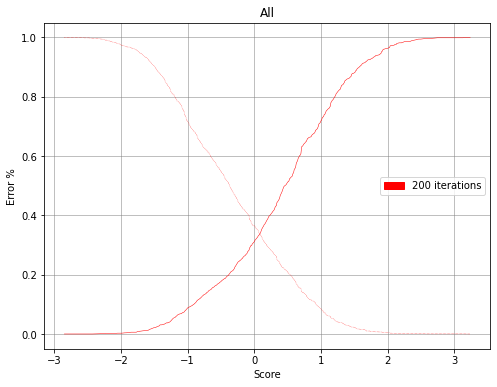

In [47]:
param['num_round']=100
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=1)

styled_logs=[    
    {   'log':log200,
        'style':['r:','r-'],
        'label':'200 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/Checkpoint.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))


[0]	train-error:0.18204	train-logloss:0.58003	train-auc:0.81124	train-f1:0.63048	eval-error:0.27145	eval-logloss:0.60954	eval-auc:0.74009	eval-f1:0.45977
[1]	train-error:0.18032	train-logloss:0.51104	train-auc:0.85405	train-f1:0.64363	eval-error:0.26898	eval-logloss:0.55361	eval-auc:0.78164	eval-f1:0.48418
[2]	train-error:0.16215	train-logloss:0.46224	train-auc:0.87599	train-f1:0.67976	eval-error:0.23762	eval-logloss:0.51053	eval-auc:0.80942	eval-f1:0.53548
[3]	train-error:0.15393	train-logloss:0.43425	train-auc:0.88487	train-f1:0.69967	eval-error:0.23515	eval-logloss:0.49885	eval-auc:0.80308	eval-f1:0.53809
[4]	train-error:0.15118	train-logloss:0.41890	train-auc:0.88625	train-f1:0.71044	eval-error:0.22607	eval-logloss:0.48815	eval-auc:0.80681	eval-f1:0.55519
[5]	train-error:0.15118	train-logloss:0.40701	train-auc:0.89377	train-f1:0.70422	eval-error:0.22855	eval-logloss:0.48273	eval-auc:0.80839	eval-f1:0.54215
[6]	train-error:0.14981	train-logloss:0.39982	train-auc:0.89521	train-f1:0.7

[53]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[54]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[55]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[56]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[57]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[58]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train-f1:0.69481	eval-error:0.23680	eval-logloss:0.47745	eval-auc:0.80839	eval-f1:0.50602
[59]	train-error:0.15118	train-logloss:0.39587	train-auc:0.89521	train

[6]	train-error:0.14433	train-logloss:0.38532	train-auc:0.89196	train-f1:0.67541	eval-error:0.22690	eval-logloss:0.47934	eval-auc:0.80436	eval-f1:0.52992
[7]	train-error:0.14193	train-logloss:0.37070	train-auc:0.90132	train-f1:0.68349	eval-error:0.22690	eval-logloss:0.47862	eval-auc:0.80240	eval-f1:0.54243
[8]	train-error:0.14330	train-logloss:0.36972	train-auc:0.90132	train-f1:0.67846	eval-error:0.22772	eval-logloss:0.47842	eval-auc:0.80240	eval-f1:0.54000
[9]	train-error:0.14330	train-logloss:0.36907	train-auc:0.90132	train-f1:0.67647	eval-error:0.22607	eval-logloss:0.47835	eval-auc:0.80240	eval-f1:0.54027
[10]	train-error:0.14364	train-logloss:0.36863	train-auc:0.90132	train-f1:0.67494	eval-error:0.22525	eval-logloss:0.47833	eval-auc:0.80240	eval-f1:0.53963
[11]	train-error:0.14364	train-logloss:0.36834	train-auc:0.90132	train-f1:0.67494	eval-error:0.22525	eval-logloss:0.47834	eval-auc:0.80240	eval-f1:0.53963
[12]	train-error:0.14398	train-logloss:0.36814	train-auc:0.90132	train-f1:

[59]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47840	eval-auc:0.80240	eval-f1:0.53559
[60]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47841	eval-auc:0.80240	eval-f1:0.53559
[61]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47840	eval-auc:0.80240	eval-f1:0.53559
[62]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47840	eval-auc:0.80240	eval-f1:0.53559
[63]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47840	eval-auc:0.80240	eval-f1:0.53559
[64]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train-f1:0.67185	eval-error:0.22607	eval-logloss:0.47840	eval-auc:0.80240	eval-f1:0.53559
[65]	train-error:0.14467	train-logloss:0.36769	train-auc:0.90132	train

[12]	train-error:0.15358	train-logloss:0.37727	train-auc:0.89995	train-f1:0.64331	eval-error:0.23927	eval-logloss:0.49497	eval-auc:0.78624	eval-f1:0.46691
[13]	train-error:0.15393	train-logloss:0.37711	train-auc:0.89995	train-f1:0.64223	eval-error:0.23927	eval-logloss:0.49500	eval-auc:0.78624	eval-f1:0.46691
[14]	train-error:0.15324	train-logloss:0.37700	train-auc:0.89995	train-f1:0.64269	eval-error:0.24010	eval-logloss:0.49502	eval-auc:0.78624	eval-f1:0.46211
[15]	train-error:0.15221	train-logloss:0.37692	train-auc:0.89995	train-f1:0.64423	eval-error:0.23845	eval-logloss:0.49504	eval-auc:0.78624	eval-f1:0.46182
[16]	train-error:0.15221	train-logloss:0.37686	train-auc:0.89995	train-f1:0.64423	eval-error:0.23845	eval-logloss:0.49505	eval-auc:0.78624	eval-f1:0.46182
[17]	train-error:0.15221	train-logloss:0.37682	train-auc:0.89995	train-f1:0.64423	eval-error:0.23927	eval-logloss:0.49506	eval-auc:0.78624	eval-f1:0.45896
[18]	train-error:0.15255	train-logloss:0.37680	train-auc:0.89995	train

[65]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[66]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[67]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[68]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[69]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[70]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train-f1:0.64314	eval-error:0.23927	eval-logloss:0.49508	eval-auc:0.78624	eval-f1:0.45896
[71]	train-error:0.15255	train-logloss:0.37673	train-auc:0.89995	train

[18]	train-error:0.16250	train-logloss:0.39386	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[19]	train-error:0.16250	train-logloss:0.39385	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[20]	train-error:0.16250	train-logloss:0.39384	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[21]	train-error:0.16250	train-logloss:0.39383	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[22]	train-error:0.16250	train-logloss:0.39383	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[23]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[24]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train

[71]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[72]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[73]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[74]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[75]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[76]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train-f1:0.66335	eval-error:0.22360	eval-logloss:0.46595	eval-auc:0.81741	eval-f1:0.55058
[77]	train-error:0.16250	train-logloss:0.39382	train-auc:0.89140	train

[24]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[25]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[26]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[27]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[28]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[29]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[30]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train

[77]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[78]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[79]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[80]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[81]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[82]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train-f1:0.66314	eval-error:0.21617	eval-logloss:0.47413	eval-auc:0.81207	eval-f1:0.53873
[83]	train-error:0.15290	train-logloss:0.37763	train-auc:0.89991	train

[30]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[31]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[32]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[33]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[34]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[35]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[36]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train

[83]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[84]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[85]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[86]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[87]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[88]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train-f1:0.64844	eval-error:0.23432	eval-logloss:0.49237	eval-auc:0.79034	eval-f1:0.51203
[89]	train-error:0.15873	train-logloss:0.40420	train-auc:0.88425	train

[36]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[37]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[38]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[39]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[40]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[41]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[42]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train

[89]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[90]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[91]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[92]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[93]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[94]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train-f1:0.60611	eval-error:0.23432	eval-logloss:0.47251	eval-auc:0.81643	eval-f1:0.48551
[95]	train-error:0.15907	train-logloss:0.39083	train-auc:0.88521	train

[42]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[43]	train-error:0.14947	train-logloss:0.37295	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[44]	train-error:0.14947	train-logloss:0.37295	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[45]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[46]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[47]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[48]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train

[95]	train-error:0.14947	train-logloss:0.37295	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[96]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[97]	train-error:0.14947	train-logloss:0.37295	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[98]	train-error:0.14947	train-logloss:0.37294	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[99]	train-error:0.14947	train-logloss:0.37295	train-auc:0.89649	train-f1:0.68314	eval-error:0.23102	eval-logloss:0.46762	eval-auc:0.81675	eval-f1:0.51389
[0]	train-error:0.18752	train-logloss:0.57832	train-auc:0.80080	train-f1:0.56205	eval-error:0.26073	eval-logloss:0.60125	eval-auc:0.76115	eval-f1:0.42546
[1]	train-error:0.17484	train-logloss:0.51070	train-auc:0.83912	train-f

[48]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[49]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[50]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[51]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[52]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[53]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train-f1:0.62975	eval-error:0.24918	eval-logloss:0.49100	eval-auc:0.79625	eval-f1:0.41473
[54]	train-error:0.15358	train-logloss:0.39287	train-auc:0.88639	train

[1]	train-error:0.18444	train-logloss:0.51336	train-auc:0.86050	train-f1:0.65733	eval-error:0.25908	eval-logloss:0.55053	eval-auc:0.78475	eval-f1:0.51242
[2]	train-error:0.16970	train-logloss:0.46588	train-auc:0.87993	train-f1:0.66395	eval-error:0.24588	eval-logloss:0.52129	eval-auc:0.79144	eval-f1:0.49832
[3]	train-error:0.16112	train-logloss:0.43751	train-auc:0.89275	train-f1:0.68956	eval-error:0.24010	eval-logloss:0.50122	eval-auc:0.79817	eval-f1:0.52529
[4]	train-error:0.15873	train-logloss:0.41878	train-auc:0.89762	train-f1:0.68947	eval-error:0.23020	eval-logloss:0.49268	eval-auc:0.79987	eval-f1:0.53266
[5]	train-error:0.15084	train-logloss:0.40604	train-auc:0.90004	train-f1:0.70068	eval-error:0.23845	eval-logloss:0.49035	eval-auc:0.79643	eval-f1:0.50934
[6]	train-error:0.14913	train-logloss:0.40395	train-auc:0.90004	train-f1:0.70021	eval-error:0.24257	eval-logloss:0.48899	eval-auc:0.79643	eval-f1:0.49484
[7]	train-error:0.15427	train-logloss:0.40259	train-auc:0.90004	train-f1:0.6

[54]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[55]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[56]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[57]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[58]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[59]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train-f1:0.68365	eval-error:0.24092	eval-logloss:0.48691	eval-auc:0.79643	eval-f1:0.48227
[60]	train-error:0.15324	train-logloss:0.39982	train-auc:0.90004	train

[7]	train-error:0.14604	train-logloss:0.38295	train-auc:0.89351	train-f1:0.68066	eval-error:0.22112	eval-logloss:0.48363	eval-auc:0.79863	eval-f1:0.55184
[8]	train-error:0.15015	train-logloss:0.38193	train-auc:0.89351	train-f1:0.66818	eval-error:0.22195	eval-logloss:0.48346	eval-auc:0.79863	eval-f1:0.54637
[9]	train-error:0.15050	train-logloss:0.38126	train-auc:0.89351	train-f1:0.66717	eval-error:0.22195	eval-logloss:0.48341	eval-auc:0.79863	eval-f1:0.54484
[10]	train-error:0.15084	train-logloss:0.38081	train-auc:0.89351	train-f1:0.66565	eval-error:0.22112	eval-logloss:0.48340	eval-auc:0.79863	eval-f1:0.54422
[11]	train-error:0.15118	train-logloss:0.38050	train-auc:0.89351	train-f1:0.66464	eval-error:0.22360	eval-logloss:0.48342	eval-auc:0.79863	eval-f1:0.53675
[12]	train-error:0.15118	train-logloss:0.38029	train-auc:0.89351	train-f1:0.66464	eval-error:0.22277	eval-logloss:0.48343	eval-auc:0.79863	eval-f1:0.53767
[13]	train-error:0.15187	train-logloss:0.38015	train-auc:0.89351	train-f1

[60]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[61]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[62]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[63]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[64]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[65]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train-f1:0.66616	eval-error:0.22607	eval-logloss:0.48350	eval-auc:0.79863	eval-f1:0.52759
[66]	train-error:0.14947	train-logloss:0.37982	train-auc:0.89351	train

[13]	train-error:0.16455	train-logloss:0.39593	train-auc:0.87759	train-f1:0.61965	eval-error:0.24175	eval-logloss:0.49078	eval-auc:0.79604	eval-f1:0.47207
[14]	train-error:0.16455	train-logloss:0.39585	train-auc:0.87759	train-f1:0.61965	eval-error:0.24175	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.47207
[15]	train-error:0.16455	train-logloss:0.39580	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[16]	train-error:0.16455	train-logloss:0.39576	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[17]	train-error:0.16455	train-logloss:0.39573	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[18]	train-error:0.16455	train-logloss:0.39572	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[19]	train-error:0.16455	train-logloss:0.39570	train-auc:0.87759	train

[66]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[67]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[68]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[69]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[70]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[71]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train-f1:0.61965	eval-error:0.24257	eval-logloss:0.49079	eval-auc:0.79604	eval-f1:0.46931
[72]	train-error:0.16455	train-logloss:0.39567	train-auc:0.87759	train

[19]	train-error:0.13678	train-logloss:0.36283	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[20]	train-error:0.13678	train-logloss:0.36282	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[21]	train-error:0.13678	train-logloss:0.36281	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[22]	train-error:0.13678	train-logloss:0.36281	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[23]	train-error:0.13678	train-logloss:0.36281	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[24]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[25]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train

[72]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[73]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[74]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[75]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[76]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[77]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train-f1:0.68755	eval-error:0.22442	eval-logloss:0.47002	eval-auc:0.81604	eval-f1:0.52613
[78]	train-error:0.13678	train-logloss:0.36280	train-auc:0.90230	train

[25]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[26]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[27]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[28]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[29]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[30]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[31]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train

[78]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[79]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[80]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[81]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[82]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[83]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train-f1:0.68214	eval-error:0.23350	eval-logloss:0.47596	eval-auc:0.80517	eval-f1:0.54281
[84]	train-error:0.15495	train-logloss:0.38299	train-auc:0.89920	train

[31]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[32]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[33]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[34]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[35]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[36]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[37]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train

[84]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47694	eval-auc:0.80534	eval-f1:0.52743
[85]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[86]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[87]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[88]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[89]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train-f1:0.66917	eval-error:0.22030	eval-logloss:0.47693	eval-auc:0.80534	eval-f1:0.52743
[90]	train-error:0.15118	train-logloss:0.39636	train-auc:0.88620	train

[37]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[38]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[39]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[40]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[41]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[42]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[43]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train

[90]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[91]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[92]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[93]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[94]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[95]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train-f1:0.64902	eval-error:0.24752	eval-logloss:0.49117	eval-auc:0.79170	eval-f1:0.46043
[96]	train-error:0.15907	train-logloss:0.40390	train-auc:0.88199	train

[43]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[44]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[45]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[46]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[47]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[48]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[49]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train

[96]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[97]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[98]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[99]	train-error:0.15701	train-logloss:0.40531	train-auc:0.87716	train-f1:0.69344	eval-error:0.22360	eval-logloss:0.47869	eval-auc:0.80153	eval-f1:0.55791
[0]	train-error:0.19506	train-logloss:0.58019	train-auc:0.81786	train-f1:0.61424	eval-error:0.25248	eval-logloss:0.60640	eval-auc:0.74765	eval-f1:0.49836
[1]	train-error:0.16970	train-logloss:0.51433	train-auc:0.84501	train-f1:0.65979	eval-error:0.25743	eval-logloss:0.56221	eval-auc:0.76509	eval-f1:0.49839
[2]	train-error:0.17347	train-logloss:0.47288	train-auc:0.85874	train-f1

[49]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[50]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[51]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[52]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[53]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[54]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train-f1:0.65916	eval-error:0.24092	eval-logloss:0.48985	eval-auc:0.79664	eval-f1:0.49828
[55]	train-error:0.16592	train-logloss:0.41141	train-auc:0.87752	train

[2]	train-error:0.16147	train-logloss:0.46869	train-auc:0.86884	train-f1:0.64128	eval-error:0.25495	eval-logloss:0.52562	eval-auc:0.78436	eval-f1:0.45310
[3]	train-error:0.16695	train-logloss:0.44227	train-auc:0.87743	train-f1:0.61864	eval-error:0.25495	eval-logloss:0.50840	eval-auc:0.78938	eval-f1:0.44723
[4]	train-error:0.15598	train-logloss:0.42301	train-auc:0.88422	train-f1:0.65187	eval-error:0.24340	eval-logloss:0.49553	eval-auc:0.79348	eval-f1:0.47602
[5]	train-error:0.16044	train-logloss:0.40738	train-auc:0.89142	train-f1:0.63665	eval-error:0.25248	eval-logloss:0.48961	eval-auc:0.79540	eval-f1:0.44765
[6]	train-error:0.15187	train-logloss:0.39610	train-auc:0.89514	train-f1:0.66667	eval-error:0.24340	eval-logloss:0.48560	eval-auc:0.79524	eval-f1:0.48517
[7]	train-error:0.15290	train-logloss:0.39466	train-auc:0.89514	train-f1:0.66058	eval-error:0.24340	eval-logloss:0.48503	eval-auc:0.79524	eval-f1:0.47788
[8]	train-error:0.15324	train-logloss:0.39372	train-auc:0.89514	train-f1:0.6

[55]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[56]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[57]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[58]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[59]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[60]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train-f1:0.64409	eval-error:0.24505	eval-logloss:0.48439	eval-auc:0.79524	eval-f1:0.44898
[61]	train-error:0.15495	train-logloss:0.39178	train-auc:0.89514	train

[8]	train-error:0.15564	train-logloss:0.39816	train-auc:0.88602	train-f1:0.66764	eval-error:0.23680	eval-logloss:0.48628	eval-auc:0.80336	eval-f1:0.50602
[9]	train-error:0.15598	train-logloss:0.39759	train-auc:0.88602	train-f1:0.66667	eval-error:0.23762	eval-logloss:0.48606	eval-auc:0.80336	eval-f1:0.50173
[10]	train-error:0.15564	train-logloss:0.39721	train-auc:0.88602	train-f1:0.66716	eval-error:0.23680	eval-logloss:0.48593	eval-auc:0.80336	eval-f1:0.50260
[11]	train-error:0.15701	train-logloss:0.39696	train-auc:0.88602	train-f1:0.66324	eval-error:0.23597	eval-logloss:0.48585	eval-auc:0.80336	eval-f1:0.50347
[12]	train-error:0.15838	train-logloss:0.39678	train-auc:0.88602	train-f1:0.65929	eval-error:0.23762	eval-logloss:0.48581	eval-auc:0.80336	eval-f1:0.49826
[13]	train-error:0.15735	train-logloss:0.39666	train-auc:0.88602	train-f1:0.66075	eval-error:0.23762	eval-logloss:0.48578	eval-auc:0.80336	eval-f1:0.49826
[14]	train-error:0.15701	train-logloss:0.39657	train-auc:0.88602	train-f

[61]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[62]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[63]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[64]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[65]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[66]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train-f1:0.66173	eval-error:0.23515	eval-logloss:0.48572	eval-auc:0.80336	eval-f1:0.50088
[67]	train-error:0.15667	train-logloss:0.39638	train-auc:0.88602	train

[14]	train-error:0.16387	train-logloss:0.40041	train-auc:0.88589	train-f1:0.64382	eval-error:0.23020	eval-logloss:0.47998	eval-auc:0.80539	eval-f1:0.50267
[15]	train-error:0.16387	train-logloss:0.40036	train-auc:0.88589	train-f1:0.64382	eval-error:0.23020	eval-logloss:0.47996	eval-auc:0.80539	eval-f1:0.50267
[16]	train-error:0.16387	train-logloss:0.40032	train-auc:0.88589	train-f1:0.64382	eval-error:0.23020	eval-logloss:0.47996	eval-auc:0.80539	eval-f1:0.50267
[17]	train-error:0.16421	train-logloss:0.40029	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47995	eval-auc:0.80539	eval-f1:0.50000
[18]	train-error:0.16421	train-logloss:0.40027	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47995	eval-auc:0.80539	eval-f1:0.50000
[19]	train-error:0.16421	train-logloss:0.40026	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[20]	train-error:0.16421	train-logloss:0.40025	train-auc:0.88589	train

[67]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[68]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[69]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[70]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[71]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[72]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train-f1:0.64280	eval-error:0.23102	eval-logloss:0.47994	eval-auc:0.80539	eval-f1:0.50000
[73]	train-error:0.16421	train-logloss:0.40022	train-auc:0.88589	train

[20]	train-error:0.14981	train-logloss:0.39277	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48229	eval-auc:0.80360	eval-f1:0.45796
[21]	train-error:0.14981	train-logloss:0.39277	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48229	eval-auc:0.80360	eval-f1:0.45796
[22]	train-error:0.14981	train-logloss:0.39276	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48229	eval-auc:0.80360	eval-f1:0.45796
[23]	train-error:0.14981	train-logloss:0.39276	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[24]	train-error:0.14981	train-logloss:0.39276	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[25]	train-error:0.14981	train-logloss:0.39276	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[26]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train

[73]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[74]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[75]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[76]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[77]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[78]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train-f1:0.67606	eval-error:0.25000	eval-logloss:0.48228	eval-auc:0.80360	eval-f1:0.45796
[79]	train-error:0.14981	train-logloss:0.39275	train-auc:0.89744	train

[26]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[27]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[28]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[29]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[30]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[31]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[32]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train

[79]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[80]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[81]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[82]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[83]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[84]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train-f1:0.66048	eval-error:0.23597	eval-logloss:0.48999	eval-auc:0.78983	eval-f1:0.49470
[85]	train-error:0.16318	train-logloss:0.40064	train-auc:0.89506	train

[32]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[33]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[34]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[35]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[36]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[37]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[38]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train

[85]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[86]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[87]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[88]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[89]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[90]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train-f1:0.64677	eval-error:0.23350	eval-logloss:0.47667	eval-auc:0.80894	eval-f1:0.48825
[91]	train-error:0.15015	train-logloss:0.38898	train-auc:0.88265	train

[38]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[39]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[40]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[41]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[42]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[43]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[44]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train

[91]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[92]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[93]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[94]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[95]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[96]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train-f1:0.68532	eval-error:0.22772	eval-logloss:0.48047	eval-auc:0.80362	eval-f1:0.52249
[97]	train-error:0.14261	train-logloss:0.36987	train-auc:0.90092	train

[44]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[45]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[46]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[47]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[48]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[49]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[50]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train

[97]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[98]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[99]	train-error:0.15873	train-logloss:0.40715	train-auc:0.86765	train-f1:0.64025	eval-error:0.24010	eval-logloss:0.48713	eval-auc:0.79731	eval-f1:0.47756
[0]	train-error:0.22695	train-logloss:0.58864	train-auc:0.79385	train-f1:0.59683	eval-error:0.25412	eval-logloss:0.60512	eval-auc:0.75049	eval-f1:0.56863
[1]	train-error:0.17175	train-logloss:0.51334	train-auc:0.84779	train-f1:0.67148	eval-error:0.24092	eval-logloss:0.54820	eval-auc:0.78749	eval-f1:0.56024
[2]	train-error:0.16970	train-logloss:0.47636	train-auc:0.85281	train-f1:0.65165	eval-error:0.24010	eval-logloss:0.52334	eval-auc:0.78422	eval-f1:0.52683
[3]	train-error:0.16318	train-logloss:0.44083	train-auc:0.87521	train-f1:

[50]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[51]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[52]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[53]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[54]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[55]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train-f1:0.66863	eval-error:0.22277	eval-logloss:0.47619	eval-auc:0.80824	eval-f1:0.52962
[56]	train-error:0.15461	train-logloss:0.39844	train-auc:0.88883	train

[3]	train-error:0.14981	train-logloss:0.42399	train-auc:0.86707	train-f1:0.65235	eval-error:0.23350	eval-logloss:0.50495	eval-auc:0.79313	eval-f1:0.51458
[4]	train-error:0.15153	train-logloss:0.40592	train-auc:0.86940	train-f1:0.63289	eval-error:0.23597	eval-logloss:0.49424	eval-auc:0.79724	eval-f1:0.48375
[5]	train-error:0.14467	train-logloss:0.39134	train-auc:0.87835	train-f1:0.65913	eval-error:0.23020	eval-logloss:0.49280	eval-auc:0.79328	eval-f1:0.50619
[6]	train-error:0.14398	train-logloss:0.38872	train-auc:0.87835	train-f1:0.64706	eval-error:0.23267	eval-logloss:0.49270	eval-auc:0.79328	eval-f1:0.48540
[7]	train-error:0.14467	train-logloss:0.38707	train-auc:0.87835	train-f1:0.63870	eval-error:0.23597	eval-logloss:0.49291	eval-auc:0.79328	eval-f1:0.47232
[8]	train-error:0.14330	train-logloss:0.38602	train-auc:0.87835	train-f1:0.64089	eval-error:0.23597	eval-logloss:0.49320	eval-auc:0.79328	eval-f1:0.47037
[9]	train-error:0.14398	train-logloss:0.38533	train-auc:0.87835	train-f1:0.6

[56]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[57]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[58]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[59]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[60]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[61]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train-f1:0.63176	eval-error:0.23680	eval-logloss:0.49439	eval-auc:0.79328	eval-f1:0.45951
[62]	train-error:0.14467	train-logloss:0.38389	train-auc:0.87835	train

[9]	train-error:0.15941	train-logloss:0.38917	train-auc:0.88702	train-f1:0.66951	eval-error:0.20792	eval-logloss:0.46960	eval-auc:0.81340	eval-f1:0.58553
[10]	train-error:0.16010	train-logloss:0.38881	train-auc:0.88702	train-f1:0.66762	eval-error:0.20792	eval-logloss:0.46949	eval-auc:0.81340	eval-f1:0.58553
[11]	train-error:0.15941	train-logloss:0.38857	train-auc:0.88702	train-f1:0.66809	eval-error:0.20792	eval-logloss:0.46942	eval-auc:0.81340	eval-f1:0.58553
[12]	train-error:0.15975	train-logloss:0.38840	train-auc:0.88702	train-f1:0.66714	eval-error:0.20875	eval-logloss:0.46939	eval-auc:0.81340	eval-f1:0.58320
[13]	train-error:0.16044	train-logloss:0.38829	train-auc:0.88702	train-f1:0.66476	eval-error:0.20875	eval-logloss:0.46936	eval-auc:0.81340	eval-f1:0.58182
[14]	train-error:0.16044	train-logloss:0.38821	train-auc:0.88702	train-f1:0.66476	eval-error:0.20875	eval-logloss:0.46935	eval-auc:0.81340	eval-f1:0.58182
[15]	train-error:0.16078	train-logloss:0.38815	train-auc:0.88702	train-

[62]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[63]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[64]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[65]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[66]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[67]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train-f1:0.66380	eval-error:0.21205	eval-logloss:0.46932	eval-auc:0.81340	eval-f1:0.57095
[68]	train-error:0.16078	train-logloss:0.38803	train-auc:0.88702	train

[15]	train-error:0.16352	train-logloss:0.41016	train-auc:0.88096	train-f1:0.61870	eval-error:0.24588	eval-logloss:0.49022	eval-auc:0.79631	eval-f1:0.45620
[16]	train-error:0.16352	train-logloss:0.41012	train-auc:0.88096	train-f1:0.61870	eval-error:0.24588	eval-logloss:0.49022	eval-auc:0.79631	eval-f1:0.45620
[17]	train-error:0.16352	train-logloss:0.41009	train-auc:0.88096	train-f1:0.61870	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45620
[18]	train-error:0.16352	train-logloss:0.41006	train-auc:0.88096	train-f1:0.61870	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45620
[19]	train-error:0.16318	train-logloss:0.41005	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[20]	train-error:0.16318	train-logloss:0.41004	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[21]	train-error:0.16318	train-logloss:0.41003	train-auc:0.88096	train

[68]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[69]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[70]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[71]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[72]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[73]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train-f1:0.61859	eval-error:0.24588	eval-logloss:0.49021	eval-auc:0.79631	eval-f1:0.45421
[74]	train-error:0.16318	train-logloss:0.41001	train-auc:0.88096	train

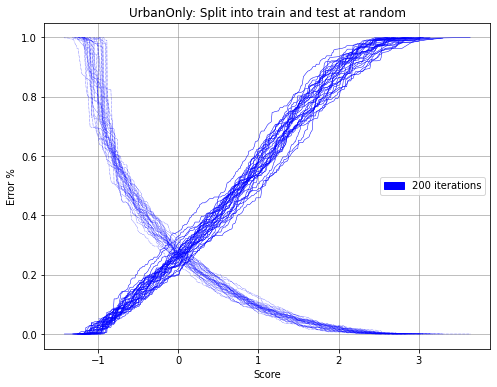

In [48]:
# Only for Urban Areas now
urban=True
area= 'Urban' if urban else 'Rural'
param = GLOBAL_PARAMS[area]
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=100
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.28132	train-logloss:0.63160	train-auc:0.76929	train-f1:0.75235	eval-error:0.34644	eval-logloss:0.65195	eval-auc:0.69342	eval-f1:0.69776
[1]	train-error:0.24593	train-logloss:0.59192	train-auc:0.82586	train-f1:0.78734	eval-error:0.30579	eval-logloss:0.62333	eval-auc:0.74695	eval-f1:0.74024
[2]	train-error:0.24211	train-logloss:0.56185	train-auc:0.83649	train-f1:0.78803	eval-error:0.28900	eval-logloss:0.60083	eval-auc:0.76332	eval-f1:0.74981
[3]	train-error:0.23085	train-logloss:0.53390	train-auc:0.85640	train-f1:0.79522	eval-error:0.29209	eval-logloss:0.58626	eval-auc:0.77304	eval-f1:0.74429
[4]	train-error:0.22763	train-logloss:0.52164	train-auc:0.86123	train-f1:0.80014	eval-error:0.28635	eval-logloss:0.58129	eval-auc:0.77258	eval-f1:0.75096
[5]	train-error:0.22140	train-logloss:0.50341	train-auc:0.86855	train-f1:0.80531	eval-error:0.27972	eval-logloss:0.57403	eval-auc:0.77740	eval-f1:0.75607
[6]	train-error:0.21778	train-logloss:0.49281	train-auc:0.87273	train-f1:0.8

[53]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[54]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[55]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[56]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[57]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[58]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train-f1:0.82423	eval-error:0.27088	eval-logloss:0.56752	eval-auc:0.79282	eval-f1:0.76083
[59]	train-error:0.19666	train-logloss:0.44288	train-auc:0.89612	train

[6]	train-error:0.20993	train-logloss:0.49600	train-auc:0.87256	train-f1:0.80609	eval-error:0.27530	eval-logloss:0.56507	eval-auc:0.78719	eval-f1:0.75150
[7]	train-error:0.20652	train-logloss:0.48574	train-auc:0.87730	train-f1:0.80921	eval-error:0.27486	eval-logloss:0.56098	eval-auc:0.79021	eval-f1:0.75100
[8]	train-error:0.20149	train-logloss:0.47471	train-auc:0.88214	train-f1:0.81236	eval-error:0.26911	eval-logloss:0.55740	eval-auc:0.79158	eval-f1:0.75493
[9]	train-error:0.19867	train-logloss:0.46822	train-auc:0.88665	train-f1:0.81456	eval-error:0.26734	eval-logloss:0.55508	eval-auc:0.79302	eval-f1:0.75713
[10]	train-error:0.19867	train-logloss:0.46821	train-auc:0.88665	train-f1:0.81456	eval-error:0.26734	eval-logloss:0.55504	eval-auc:0.79302	eval-f1:0.75713
[11]	train-error:0.19867	train-logloss:0.46820	train-auc:0.88665	train-f1:0.81456	eval-error:0.26734	eval-logloss:0.55501	eval-auc:0.79302	eval-f1:0.75713
[12]	train-error:0.19887	train-logloss:0.46819	train-auc:0.88665	train-f1:

[59]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[60]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[61]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[62]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[63]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[64]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train-f1:0.81508	eval-error:0.26734	eval-logloss:0.55493	eval-auc:0.79302	eval-f1:0.75713
[65]	train-error:0.19827	train-logloss:0.46818	train-auc:0.88665	train

[12]	train-error:0.19505	train-logloss:0.46873	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55924	eval-auc:0.78643	eval-f1:0.74591
[13]	train-error:0.19505	train-logloss:0.46872	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55922	eval-auc:0.78643	eval-f1:0.74591
[14]	train-error:0.19505	train-logloss:0.46872	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55920	eval-auc:0.78643	eval-f1:0.74591
[15]	train-error:0.19505	train-logloss:0.46872	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55919	eval-auc:0.78643	eval-f1:0.74591
[16]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55918	eval-auc:0.78643	eval-f1:0.74591
[17]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28148	eval-logloss:0.55917	eval-auc:0.78643	eval-f1:0.74591
[18]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train

[65]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[66]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[67]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[68]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[69]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[70]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train-f1:0.82370	eval-error:0.28193	eval-logloss:0.55916	eval-auc:0.78643	eval-f1:0.74561
[71]	train-error:0.19505	train-logloss:0.46871	train-auc:0.88505	train

[18]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[19]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[20]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[21]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[22]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[23]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[24]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train

[71]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[72]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[73]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[74]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[75]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[76]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train-f1:0.81769	eval-error:0.27707	eval-logloss:0.55264	eval-auc:0.79088	eval-f1:0.75050
[77]	train-error:0.20229	train-logloss:0.46810	train-auc:0.88435	train

[24]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55355	eval-auc:0.79410	eval-f1:0.75130
[25]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[26]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[27]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[28]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[29]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[30]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train

[77]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[78]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[79]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[80]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[81]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[82]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train-f1:0.82155	eval-error:0.27441	eval-logloss:0.55354	eval-auc:0.79410	eval-f1:0.75130
[83]	train-error:0.18982	train-logloss:0.45135	train-auc:0.89218	train

[30]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[31]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[32]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[33]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[34]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[35]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[36]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train

[83]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[84]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[85]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[86]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[87]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[88]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train-f1:0.82480	eval-error:0.29121	eval-logloss:0.57535	eval-auc:0.78302	eval-f1:0.74106
[89]	train-error:0.19204	train-logloss:0.45471	train-auc:0.89028	train

[36]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[37]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[38]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[39]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[40]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[41]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[42]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train

[89]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[90]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[91]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[92]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[93]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[94]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train-f1:0.81793	eval-error:0.28590	eval-logloss:0.55569	eval-auc:0.78676	eval-f1:0.73964
[95]	train-error:0.19525	train-logloss:0.45433	train-auc:0.89082	train

[42]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[43]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[44]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[45]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[46]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[47]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[48]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train

[95]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[96]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[97]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[98]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[99]	train-error:0.19566	train-logloss:0.46841	train-auc:0.88417	train-f1:0.81789	eval-error:0.28679	eval-logloss:0.56683	eval-auc:0.77953	eval-f1:0.74092
[0]	train-error:0.28775	train-logloss:0.63522	train-auc:0.75766	train-f1:0.73534	eval-error:0.33937	eval-logloss:0.65313	eval-auc:0.69562	eval-f1:0.69255
[1]	train-error:0.26161	train-logloss:0.59590	train-auc:0.80154	train-f

[48]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[49]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[50]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[51]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[52]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[53]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train-f1:0.81531	eval-error:0.27486	eval-logloss:0.55957	eval-auc:0.78336	eval-f1:0.75318
[54]	train-error:0.20089	train-logloss:0.45772	train-auc:0.88773	train

[1]	train-error:0.25819	train-logloss:0.59282	train-auc:0.81508	train-f1:0.76388	eval-error:0.32170	eval-logloss:0.62191	eval-auc:0.73672	eval-f1:0.71629
[2]	train-error:0.23608	train-logloss:0.55304	train-auc:0.84359	train-f1:0.78187	eval-error:0.30490	eval-logloss:0.59801	eval-auc:0.75890	eval-f1:0.72792
[3]	train-error:0.22662	train-logloss:0.52822	train-auc:0.85837	train-f1:0.79249	eval-error:0.30446	eval-logloss:0.58903	eval-auc:0.76394	eval-f1:0.72991
[4]	train-error:0.21275	train-logloss:0.50845	train-auc:0.86953	train-f1:0.79977	eval-error:0.29651	eval-logloss:0.58088	eval-auc:0.76754	eval-f1:0.73041
[5]	train-error:0.20772	train-logloss:0.49251	train-auc:0.87512	train-f1:0.80923	eval-error:0.28281	eval-logloss:0.57464	eval-auc:0.77167	eval-f1:0.75078
[6]	train-error:0.20390	train-logloss:0.47625	train-auc:0.88073	train-f1:0.81117	eval-error:0.28369	eval-logloss:0.56719	eval-auc:0.77934	eval-f1:0.74665
[7]	train-error:0.19807	train-logloss:0.46875	train-auc:0.88418	train-f1:0.8

[54]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[55]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[56]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[57]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[58]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[59]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train-f1:0.82900	eval-error:0.27441	eval-logloss:0.57980	eval-auc:0.78253	eval-f1:0.75289
[60]	train-error:0.18259	train-logloss:0.44757	train-auc:0.89435	train

[7]	train-error:0.19666	train-logloss:0.47584	train-auc:0.87885	train-f1:0.81740	eval-error:0.29253	eval-logloss:0.56716	eval-auc:0.77372	eval-f1:0.73562
[8]	train-error:0.19505	train-logloss:0.46902	train-auc:0.88072	train-f1:0.81903	eval-error:0.29739	eval-logloss:0.56560	eval-auc:0.77504	eval-f1:0.73091
[9]	train-error:0.19123	train-logloss:0.46154	train-auc:0.88402	train-f1:0.82287	eval-error:0.29121	eval-logloss:0.56390	eval-auc:0.77786	eval-f1:0.73693
[10]	train-error:0.18600	train-logloss:0.45421	train-auc:0.88803	train-f1:0.82784	eval-error:0.28767	eval-logloss:0.56240	eval-auc:0.77913	eval-f1:0.73887
[11]	train-error:0.18480	train-logloss:0.44986	train-auc:0.89143	train-f1:0.82877	eval-error:0.28811	eval-logloss:0.56024	eval-auc:0.78047	eval-f1:0.73878
[12]	train-error:0.18560	train-logloss:0.44736	train-auc:0.89299	train-f1:0.82777	eval-error:0.28900	eval-logloss:0.56066	eval-auc:0.77994	eval-f1:0.73798
[13]	train-error:0.18560	train-logloss:0.44736	train-auc:0.89299	train-f1

[60]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[61]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[62]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[63]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[64]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[65]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train-f1:0.82777	eval-error:0.28811	eval-logloss:0.56062	eval-auc:0.77994	eval-f1:0.73899
[66]	train-error:0.18560	train-logloss:0.44735	train-auc:0.89299	train

[13]	train-error:0.18017	train-logloss:0.44471	train-auc:0.90028	train-f1:0.83308	eval-error:0.27397	eval-logloss:0.54910	eval-auc:0.79458	eval-f1:0.75259
[14]	train-error:0.18017	train-logloss:0.44472	train-auc:0.90028	train-f1:0.83308	eval-error:0.27397	eval-logloss:0.54909	eval-auc:0.79458	eval-f1:0.75259
[15]	train-error:0.18017	train-logloss:0.44473	train-auc:0.90028	train-f1:0.83308	eval-error:0.27397	eval-logloss:0.54908	eval-auc:0.79458	eval-f1:0.75259
[16]	train-error:0.18058	train-logloss:0.44473	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54908	eval-auc:0.79458	eval-f1:0.75259
[17]	train-error:0.18058	train-logloss:0.44473	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[18]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[19]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train

[66]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[67]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[68]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[69]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[70]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[71]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train-f1:0.83278	eval-error:0.27397	eval-logloss:0.54907	eval-auc:0.79458	eval-f1:0.75259
[72]	train-error:0.18058	train-logloss:0.44474	train-auc:0.90028	train

[19]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[20]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[21]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[22]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[23]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[24]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[25]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train

[72]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[73]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[74]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[75]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[76]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[77]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train-f1:0.81520	eval-error:0.28944	eval-logloss:0.56616	eval-auc:0.77909	eval-f1:0.73276
[78]	train-error:0.19264	train-logloss:0.46086	train-auc:0.88910	train

[25]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[26]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[27]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[28]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[29]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[30]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[31]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train

[78]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[79]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[80]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[81]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[82]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[83]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train-f1:0.83024	eval-error:0.27265	eval-logloss:0.57494	eval-auc:0.78543	eval-f1:0.76020
[84]	train-error:0.18600	train-logloss:0.44632	train-auc:0.89587	train

[31]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[32]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[33]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[34]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[35]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[36]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[37]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train

[84]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[85]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[86]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[87]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[88]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[89]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train-f1:0.82263	eval-error:0.27574	eval-logloss:0.55501	eval-auc:0.78831	eval-f1:0.75529
[90]	train-error:0.19485	train-logloss:0.45007	train-auc:0.89416	train

[37]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[38]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[39]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[40]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[41]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[42]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[43]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train

[90]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[91]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[92]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[93]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[94]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[95]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train-f1:0.82189	eval-error:0.28414	eval-logloss:0.59592	eval-auc:0.77821	eval-f1:0.74834
[96]	train-error:0.19767	train-logloss:0.45542	train-auc:0.89159	train

[43]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[44]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[45]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[46]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[47]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[48]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[49]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train

[96]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[97]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[98]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[99]	train-error:0.19566	train-logloss:0.46076	train-auc:0.88589	train-f1:0.82503	eval-error:0.28414	eval-logloss:0.55530	eval-auc:0.78532	eval-f1:0.74971
[0]	train-error:0.27830	train-logloss:0.63158	train-auc:0.76537	train-f1:0.75072	eval-error:0.31949	eval-logloss:0.64882	eval-auc:0.69943	eval-f1:0.72053
[1]	train-error:0.25659	train-logloss:0.59348	train-auc:0.82098	train-f1:0.76664	eval-error:0.32170	eval-logloss:0.62699	eval-auc:0.73377	eval-f1:0.71406
[2]	train-error:0.24613	train-logloss:0.55795	train-auc:0.84849	train-f1

[49]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[50]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[51]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[52]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[53]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[54]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train-f1:0.83137	eval-error:0.27795	eval-logloss:0.55816	eval-auc:0.78894	eval-f1:0.74890
[55]	train-error:0.18118	train-logloss:0.44800	train-auc:0.89780	train

[2]	train-error:0.23608	train-logloss:0.56284	train-auc:0.83054	train-f1:0.78130	eval-error:0.31551	eval-logloss:0.60961	eval-auc:0.74316	eval-f1:0.71486
[3]	train-error:0.22441	train-logloss:0.54165	train-auc:0.84569	train-f1:0.79249	eval-error:0.30270	eval-logloss:0.59896	eval-auc:0.75097	eval-f1:0.72742
[4]	train-error:0.21556	train-logloss:0.52085	train-auc:0.85722	train-f1:0.80126	eval-error:0.30093	eval-logloss:0.59003	eval-auc:0.75632	eval-f1:0.73178
[5]	train-error:0.20330	train-logloss:0.50230	train-auc:0.86575	train-f1:0.81113	eval-error:0.30137	eval-logloss:0.58127	eval-auc:0.76375	eval-f1:0.72807
[6]	train-error:0.19706	train-logloss:0.48609	train-auc:0.87468	train-f1:0.81551	eval-error:0.29209	eval-logloss:0.57113	eval-auc:0.77354	eval-f1:0.73655
[7]	train-error:0.19505	train-logloss:0.47819	train-auc:0.87807	train-f1:0.81869	eval-error:0.28900	eval-logloss:0.56789	eval-auc:0.77592	eval-f1:0.73923
[8]	train-error:0.19505	train-logloss:0.47817	train-auc:0.87807	train-f1:0.8

[55]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[56]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[57]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[58]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[59]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[60]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train-f1:0.81918	eval-error:0.28988	eval-logloss:0.56757	eval-auc:0.77592	eval-f1:0.73885
[61]	train-error:0.19485	train-logloss:0.47813	train-auc:0.87807	train

[8]	train-error:0.19023	train-logloss:0.46335	train-auc:0.88557	train-f1:0.82514	eval-error:0.28104	eval-logloss:0.55915	eval-auc:0.78449	eval-f1:0.75059
[9]	train-error:0.18661	train-logloss:0.45836	train-auc:0.88909	train-f1:0.82885	eval-error:0.27883	eval-logloss:0.55999	eval-auc:0.78372	eval-f1:0.75187
[10]	train-error:0.18661	train-logloss:0.45254	train-auc:0.88957	train-f1:0.82954	eval-error:0.27486	eval-logloss:0.55898	eval-auc:0.78519	eval-f1:0.75760
[11]	train-error:0.18661	train-logloss:0.45253	train-auc:0.88957	train-f1:0.82954	eval-error:0.27486	eval-logloss:0.55896	eval-auc:0.78519	eval-f1:0.75760
[12]	train-error:0.18661	train-logloss:0.45252	train-auc:0.88957	train-f1:0.82954	eval-error:0.27486	eval-logloss:0.55894	eval-auc:0.78519	eval-f1:0.75760
[13]	train-error:0.18661	train-logloss:0.45252	train-auc:0.88957	train-f1:0.82954	eval-error:0.27486	eval-logloss:0.55893	eval-auc:0.78519	eval-f1:0.75760
[14]	train-error:0.18681	train-logloss:0.45252	train-auc:0.88957	train-f

[61]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[62]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[63]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[64]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[65]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[66]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train-f1:0.82927	eval-error:0.27486	eval-logloss:0.55890	eval-auc:0.78519	eval-f1:0.75760
[67]	train-error:0.18721	train-logloss:0.45251	train-auc:0.88957	train

[14]	train-error:0.19184	train-logloss:0.46195	train-auc:0.88839	train-f1:0.81932	eval-error:0.27441	eval-logloss:0.55521	eval-auc:0.78937	eval-f1:0.75386
[15]	train-error:0.19184	train-logloss:0.46195	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55521	eval-auc:0.78937	eval-f1:0.75357
[16]	train-error:0.19184	train-logloss:0.46195	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55520	eval-auc:0.78937	eval-f1:0.75357
[17]	train-error:0.19184	train-logloss:0.46195	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55520	eval-auc:0.78937	eval-f1:0.75357
[18]	train-error:0.19184	train-logloss:0.46195	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55520	eval-auc:0.78937	eval-f1:0.75357
[19]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[20]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train

[67]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[68]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[69]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[70]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[71]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[72]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train-f1:0.81932	eval-error:0.27486	eval-logloss:0.55519	eval-auc:0.78937	eval-f1:0.75357
[73]	train-error:0.19184	train-logloss:0.46194	train-auc:0.88839	train

[20]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[21]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[22]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[23]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[24]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[25]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[26]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train

[73]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[74]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[75]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[76]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[77]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[78]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train-f1:0.81464	eval-error:0.27353	eval-logloss:0.56665	eval-auc:0.79478	eval-f1:0.75407
[79]	train-error:0.19545	train-logloss:0.45470	train-auc:0.89314	train

[26]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[27]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[28]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[29]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[30]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[31]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[32]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train

[79]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[80]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[81]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[82]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[83]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[84]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train-f1:0.81930	eval-error:0.27574	eval-logloss:0.55714	eval-auc:0.78731	eval-f1:0.75258
[85]	train-error:0.18982	train-logloss:0.45611	train-auc:0.89211	train

[32]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[33]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[34]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[35]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[36]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[37]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[38]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train

[85]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[86]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[87]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[88]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[89]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[90]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train-f1:0.82642	eval-error:0.28458	eval-logloss:0.55698	eval-auc:0.78291	eval-f1:0.74485
[91]	train-error:0.19184	train-logloss:0.45237	train-auc:0.89149	train

[38]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[39]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[40]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[41]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[42]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[43]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[44]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train

[91]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[92]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[93]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[94]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[95]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[96]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train-f1:0.82198	eval-error:0.28414	eval-logloss:0.55936	eval-auc:0.78595	eval-f1:0.74454
[97]	train-error:0.18761	train-logloss:0.45355	train-auc:0.89238	train

[44]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[45]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[46]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[47]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[48]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[49]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[50]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train

[97]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[98]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[99]	train-error:0.19666	train-logloss:0.45982	train-auc:0.88584	train-f1:0.82088	eval-error:0.27883	eval-logloss:0.56022	eval-auc:0.78190	eval-f1:0.75109
[0]	train-error:0.29660	train-logloss:0.63689	train-auc:0.74436	train-f1:0.76229	eval-error:0.33407	eval-logloss:0.65273	eval-auc:0.68590	eval-f1:0.73913
[1]	train-error:0.25457	train-logloss:0.59534	train-auc:0.80402	train-f1:0.78737	eval-error:0.31772	eval-logloss:0.62517	eval-auc:0.73002	eval-f1:0.74109
[2]	train-error:0.24472	train-logloss:0.56575	train-auc:0.83265	train-f1:0.78021	eval-error:0.30623	eval-logloss:0.60415	eval-auc:0.75592	eval-f1:0.73397
[3]	train-error:0.22703	train-logloss:0.54210	train-auc:0.85141	train-f1:

[50]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[51]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[52]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[53]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[54]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[55]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train-f1:0.82839	eval-error:0.26911	eval-logloss:0.56289	eval-auc:0.79533	eval-f1:0.76089
[56]	train-error:0.18862	train-logloss:0.44655	train-auc:0.90172	train

[3]	train-error:0.22220	train-logloss:0.53332	train-auc:0.85985	train-f1:0.80583	eval-error:0.29076	eval-logloss:0.58627	eval-auc:0.77278	eval-f1:0.74847
[4]	train-error:0.20953	train-logloss:0.51239	train-auc:0.86879	train-f1:0.81419	eval-error:0.28811	eval-logloss:0.57288	eval-auc:0.78131	eval-f1:0.74611
[5]	train-error:0.20913	train-logloss:0.49657	train-auc:0.87167	train-f1:0.81382	eval-error:0.28502	eval-logloss:0.56280	eval-auc:0.78732	eval-f1:0.74932
[6]	train-error:0.20189	train-logloss:0.48455	train-auc:0.87843	train-f1:0.81884	eval-error:0.27707	eval-logloss:0.55747	eval-auc:0.78924	eval-f1:0.75517
[7]	train-error:0.20109	train-logloss:0.47362	train-auc:0.88382	train-f1:0.81923	eval-error:0.27000	eval-logloss:0.55214	eval-auc:0.79288	eval-f1:0.75935
[8]	train-error:0.19425	train-logloss:0.46603	train-auc:0.88860	train-f1:0.82557	eval-error:0.27353	eval-logloss:0.55235	eval-auc:0.79166	eval-f1:0.75543
[9]	train-error:0.18942	train-logloss:0.45696	train-auc:0.89037	train-f1:0.8

[56]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[57]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[58]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[59]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[60]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[61]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train-f1:0.82915	eval-error:0.27000	eval-logloss:0.54782	eval-auc:0.79555	eval-f1:0.75783
[62]	train-error:0.18902	train-logloss:0.45692	train-auc:0.89037	train

[9]	train-error:0.20008	train-logloss:0.46246	train-auc:0.88640	train-f1:0.82235	eval-error:0.27088	eval-logloss:0.55734	eval-auc:0.78682	eval-f1:0.76504
[10]	train-error:0.19324	train-logloss:0.45670	train-auc:0.88837	train-f1:0.82744	eval-error:0.27309	eval-logloss:0.55633	eval-auc:0.78697	eval-f1:0.76046
[11]	train-error:0.19304	train-logloss:0.45669	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55631	eval-auc:0.78697	eval-f1:0.76094
[12]	train-error:0.19304	train-logloss:0.45668	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55629	eval-auc:0.78697	eval-f1:0.76094
[13]	train-error:0.19304	train-logloss:0.45667	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55627	eval-auc:0.78697	eval-f1:0.76094
[14]	train-error:0.19304	train-logloss:0.45667	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55627	eval-auc:0.78697	eval-f1:0.76094
[15]	train-error:0.19304	train-logloss:0.45667	train-auc:0.88837	train-

[62]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[63]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[64]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[65]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[66]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[67]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train-f1:0.82765	eval-error:0.27265	eval-logloss:0.55625	eval-auc:0.78697	eval-f1:0.76094
[68]	train-error:0.19304	train-logloss:0.45666	train-auc:0.88837	train

[15]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55717	eval-auc:0.78581	eval-f1:0.75178
[16]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55716	eval-auc:0.78581	eval-f1:0.75178
[17]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55716	eval-auc:0.78581	eval-f1:0.75178
[18]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[19]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[20]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[21]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train

[68]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[69]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[70]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[71]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[72]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[73]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train-f1:0.83771	eval-error:0.27751	eval-logloss:0.55715	eval-auc:0.78581	eval-f1:0.75178
[74]	train-error:0.17897	train-logloss:0.44248	train-auc:0.90018	train

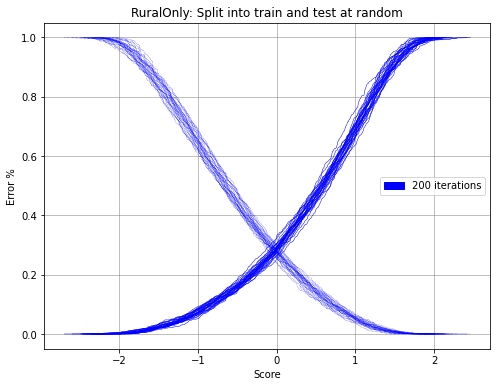

In [49]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=100
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]


_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.19025	train-logloss:0.57294	train-auc:0.82351	train-f1:0.52712	eval-error:0.24498	eval-logloss:0.59588	eval-auc:0.75712	eval-f1:0.42436
[1]	train-error:0.15649	train-logloss:0.49855	train-auc:0.85748	train-f1:0.69091	eval-error:0.22659	eval-logloss:0.54280	eval-auc:0.78318	eval-f1:0.55354
[2]	train-error:0.14456	train-logloss:0.44555	train-auc:0.88589	train-f1:0.69886	eval-error:0.21990	eval-logloss:0.50982	eval-auc:0.79485	eval-f1:0.54419
[3]	train-error:0.13229	train-logloss:0.40557	train-auc:0.89685	train-f1:0.72943	eval-error:0.22659	eval-logloss:0.49126	eval-auc:0.80049	eval-f1:0.53033
[4]	train-error:0.12308	train-logloss:0.37260	train-auc:0.91329	train-f1:0.73935	eval-error:0.22492	eval-logloss:0.47870	eval-auc:0.80539	eval-f1:0.52050
[5]	train-error:0.11149	train-logloss:0.35048	train-auc:0.92163	train-f1:0.76825	eval-error:0.21990	eval-logloss:0.47151	eval-auc:0.80540	eval-f1:0.53286
[6]	train-error:0.11251	train-logloss:0.33358	train-auc:0.92832	train-f1:0.7

[53]	train-error:0.01978	train-logloss:0.13811	train-auc:0.99719	train-f1:0.96239	eval-error:0.22324	eval-logloss:0.69460	eval-auc:0.79041	eval-f1:0.54202
[54]	train-error:0.01875	train-logloss:0.13659	train-auc:0.99732	train-f1:0.96435	eval-error:0.22408	eval-logloss:0.64016	eval-auc:0.79115	eval-f1:0.54110
[55]	train-error:0.01807	train-logloss:0.13581	train-auc:0.99738	train-f1:0.96565	eval-error:0.22408	eval-logloss:0.64109	eval-auc:0.79058	eval-f1:0.54110
[56]	train-error:0.01807	train-logloss:0.13381	train-auc:0.99747	train-f1:0.96561	eval-error:0.22157	eval-logloss:0.64169	eval-auc:0.79086	eval-f1:0.54389
[57]	train-error:0.01603	train-logloss:0.13151	train-auc:0.99756	train-f1:0.96962	eval-error:0.22074	eval-logloss:0.66637	eval-auc:0.79097	eval-f1:0.54639
[58]	train-error:0.01534	train-logloss:0.13010	train-auc:0.99766	train-f1:0.97095	eval-error:0.22074	eval-logloss:0.66588	eval-auc:0.79165	eval-f1:0.54639
[59]	train-error:0.01296	train-logloss:0.12682	train-auc:0.99844	train

[6]	train-error:0.11524	train-logloss:0.34761	train-auc:0.92518	train-f1:0.75000	eval-error:0.24080	eval-logloss:0.48068	eval-auc:0.79733	eval-f1:0.45038
[7]	train-error:0.10535	train-logloss:0.33246	train-auc:0.93173	train-f1:0.77462	eval-error:0.24080	eval-logloss:0.47802	eval-auc:0.79903	eval-f1:0.44828
[8]	train-error:0.10160	train-logloss:0.32077	train-auc:0.93992	train-f1:0.78375	eval-error:0.23244	eval-logloss:0.47568	eval-auc:0.80052	eval-f1:0.46743
[9]	train-error:0.09853	train-logloss:0.30844	train-auc:0.94635	train-f1:0.79012	eval-error:0.23328	eval-logloss:0.47811	eval-auc:0.79804	eval-f1:0.47259
[10]	train-error:0.09206	train-logloss:0.29690	train-auc:0.95016	train-f1:0.80631	eval-error:0.23161	eval-logloss:0.47815	eval-auc:0.79893	eval-f1:0.47834
[11]	train-error:0.08694	train-logloss:0.28446	train-auc:0.96006	train-f1:0.81902	eval-error:0.23746	eval-logloss:0.48051	eval-auc:0.79678	eval-f1:0.46415
[12]	train-error:0.08319	train-logloss:0.27531	train-auc:0.96540	train-f1:

[59]	train-error:0.01637	train-logloss:0.13136	train-auc:0.99867	train-f1:0.96931	eval-error:0.23829	eval-logloss:0.69958	eval-auc:0.78908	eval-f1:0.50088
[60]	train-error:0.01603	train-logloss:0.12828	train-auc:0.99875	train-f1:0.96997	eval-error:0.23662	eval-logloss:0.72771	eval-auc:0.78952	eval-f1:0.50611
[61]	train-error:0.01671	train-logloss:0.12750	train-auc:0.99881	train-f1:0.96869	eval-error:0.23662	eval-logloss:0.72568	eval-auc:0.78930	eval-f1:0.50611
[62]	train-error:0.01603	train-logloss:0.12520	train-auc:0.99886	train-f1:0.97001	eval-error:0.23579	eval-logloss:0.74999	eval-auc:0.79036	eval-f1:0.51042
[63]	train-error:0.01500	train-logloss:0.12377	train-auc:0.99905	train-f1:0.97194	eval-error:0.23579	eval-logloss:0.75057	eval-auc:0.79044	eval-f1:0.51211
[64]	train-error:0.01534	train-logloss:0.12227	train-auc:0.99915	train-f1:0.97132	eval-error:0.23662	eval-logloss:0.80265	eval-auc:0.79105	eval-f1:0.51123
[65]	train-error:0.01432	train-logloss:0.12151	train-auc:0.99918	train

[12]	train-error:0.10604	train-logloss:0.30733	train-auc:0.95151	train-f1:0.78388	eval-error:0.23077	eval-logloss:0.48441	eval-auc:0.79419	eval-f1:0.50180
[13]	train-error:0.10535	train-logloss:0.30119	train-auc:0.95479	train-f1:0.78616	eval-error:0.23077	eval-logloss:0.48424	eval-auc:0.79401	eval-f1:0.50360
[14]	train-error:0.10228	train-logloss:0.29334	train-auc:0.95794	train-f1:0.79310	eval-error:0.23244	eval-logloss:0.48478	eval-auc:0.79385	eval-f1:0.49638
[15]	train-error:0.09512	train-logloss:0.28902	train-auc:0.95984	train-f1:0.80930	eval-error:0.23328	eval-logloss:0.48767	eval-auc:0.79109	eval-f1:0.49548
[16]	train-error:0.08115	train-logloss:0.27118	train-auc:0.96716	train-f1:0.84176	eval-error:0.23244	eval-logloss:0.48465	eval-auc:0.79504	eval-f1:0.50357
[17]	train-error:0.07774	train-logloss:0.26374	train-auc:0.96974	train-f1:0.84901	eval-error:0.23077	eval-logloss:0.48478	eval-auc:0.79608	eval-f1:0.50714
[18]	train-error:0.07330	train-logloss:0.25910	train-auc:0.97167	train

[65]	train-error:0.01330	train-logloss:0.12567	train-auc:0.99934	train-f1:0.97612	eval-error:0.23328	eval-logloss:0.70119	eval-auc:0.78496	eval-f1:0.52792
[66]	train-error:0.01261	train-logloss:0.12268	train-auc:0.99939	train-f1:0.97737	eval-error:0.23495	eval-logloss:0.70206	eval-auc:0.78519	eval-f1:0.52129
[67]	train-error:0.01261	train-logloss:0.12106	train-auc:0.99951	train-f1:0.97737	eval-error:0.23662	eval-logloss:0.70444	eval-auc:0.78446	eval-f1:0.51624
[68]	train-error:0.01227	train-logloss:0.11921	train-auc:0.99957	train-f1:0.97799	eval-error:0.23746	eval-logloss:0.72947	eval-auc:0.78502	eval-f1:0.51370
[69]	train-error:0.01227	train-logloss:0.11727	train-auc:0.99960	train-f1:0.97799	eval-error:0.23829	eval-logloss:0.72950	eval-auc:0.78516	eval-f1:0.51282
[70]	train-error:0.01057	train-logloss:0.11560	train-auc:0.99963	train-f1:0.98113	eval-error:0.23997	eval-logloss:0.72963	eval-auc:0.78557	eval-f1:0.51107
[71]	train-error:0.01023	train-logloss:0.11460	train-auc:0.99964	train

[18]	train-error:0.07092	train-logloss:0.24444	train-auc:0.97527	train-f1:0.86458	eval-error:0.22575	eval-logloss:0.57196	eval-auc:0.80104	eval-f1:0.53767
[19]	train-error:0.06717	train-logloss:0.23925	train-auc:0.97704	train-f1:0.87233	eval-error:0.22241	eval-logloss:0.56930	eval-auc:0.80112	eval-f1:0.54452
[20]	train-error:0.06649	train-logloss:0.23627	train-auc:0.97764	train-f1:0.87362	eval-error:0.22157	eval-logloss:0.62286	eval-auc:0.80051	eval-f1:0.54701
[21]	train-error:0.06273	train-logloss:0.22987	train-auc:0.97910	train-f1:0.88160	eval-error:0.21990	eval-logloss:0.65208	eval-auc:0.79912	eval-f1:0.55649
[22]	train-error:0.05933	train-logloss:0.22581	train-auc:0.98138	train-f1:0.88832	eval-error:0.21990	eval-logloss:0.65260	eval-auc:0.80010	eval-f1:0.55649
[23]	train-error:0.05660	train-logloss:0.22069	train-auc:0.98254	train-f1:0.89413	eval-error:0.21655	eval-logloss:0.67974	eval-auc:0.80187	eval-f1:0.56027
[24]	train-error:0.05591	train-logloss:0.21447	train-auc:0.98408	train

[71]	train-error:0.00750	train-logloss:0.10760	train-auc:0.99947	train-f1:0.98668	eval-error:0.22074	eval-logloss:0.76238	eval-auc:0.80248	eval-f1:0.56721
[72]	train-error:0.00750	train-logloss:0.10710	train-auc:0.99950	train-f1:0.98668	eval-error:0.22157	eval-logloss:0.76226	eval-auc:0.80255	eval-f1:0.56629
[73]	train-error:0.00750	train-logloss:0.10447	train-auc:0.99958	train-f1:0.98668	eval-error:0.22157	eval-logloss:0.76311	eval-auc:0.80319	eval-f1:0.56770
[74]	train-error:0.00750	train-logloss:0.10296	train-auc:0.99961	train-f1:0.98668	eval-error:0.21906	eval-logloss:0.76473	eval-auc:0.80311	eval-f1:0.56908
[75]	train-error:0.00682	train-logloss:0.10182	train-auc:0.99963	train-f1:0.98789	eval-error:0.22157	eval-logloss:0.76220	eval-auc:0.80474	eval-f1:0.56343
[76]	train-error:0.00682	train-logloss:0.10053	train-auc:0.99966	train-f1:0.98789	eval-error:0.22241	eval-logloss:0.76503	eval-auc:0.80356	eval-f1:0.56393
[77]	train-error:0.00682	train-logloss:0.09984	train-auc:0.99967	train

[24]	train-error:0.06035	train-logloss:0.22090	train-auc:0.98345	train-f1:0.88805	eval-error:0.21154	eval-logloss:0.62832	eval-auc:0.81749	eval-f1:0.58457
[25]	train-error:0.05830	train-logloss:0.21688	train-auc:0.98424	train-f1:0.89170	eval-error:0.21572	eval-logloss:0.63016	eval-auc:0.81598	eval-f1:0.57843
[26]	train-error:0.05626	train-logloss:0.21285	train-auc:0.98545	train-f1:0.89577	eval-error:0.21488	eval-logloss:0.65683	eval-auc:0.81599	eval-f1:0.57938
[27]	train-error:0.05217	train-logloss:0.20561	train-auc:0.98690	train-f1:0.90359	eval-error:0.20903	eval-logloss:0.65387	eval-auc:0.81854	eval-f1:0.59016
[28]	train-error:0.05148	train-logloss:0.20245	train-auc:0.98755	train-f1:0.90437	eval-error:0.21070	eval-logloss:0.60818	eval-auc:0.81806	eval-f1:0.58688
[29]	train-error:0.04876	train-logloss:0.20008	train-auc:0.98786	train-f1:0.90978	eval-error:0.21070	eval-logloss:0.62929	eval-auc:0.81772	eval-f1:0.58553
[30]	train-error:0.04807	train-logloss:0.19795	train-auc:0.98851	train

[77]	train-error:0.00955	train-logloss:0.10728	train-auc:0.99964	train-f1:0.98286	eval-error:0.22492	eval-logloss:0.92521	eval-auc:0.80689	eval-f1:0.56683
[78]	train-error:0.00886	train-logloss:0.10503	train-auc:0.99968	train-f1:0.98411	eval-error:0.22659	eval-logloss:0.90184	eval-auc:0.80591	eval-f1:0.56361
[79]	train-error:0.00852	train-logloss:0.10341	train-auc:0.99970	train-f1:0.98471	eval-error:0.22492	eval-logloss:0.87260	eval-auc:0.80721	eval-f1:0.56543
[80]	train-error:0.00784	train-logloss:0.10132	train-auc:0.99972	train-f1:0.98595	eval-error:0.22659	eval-logloss:0.87251	eval-auc:0.80778	eval-f1:0.56361
[81]	train-error:0.00750	train-logloss:0.09895	train-auc:0.99974	train-f1:0.98655	eval-error:0.22492	eval-logloss:0.89480	eval-auc:0.80748	eval-f1:0.56683
[82]	train-error:0.00682	train-logloss:0.09809	train-auc:0.99976	train-f1:0.98779	eval-error:0.22742	eval-logloss:0.89442	eval-auc:0.80776	eval-f1:0.56129
[83]	train-error:0.00682	train-logloss:0.09751	train-auc:0.99977	train

[30]	train-error:0.03716	train-logloss:0.18316	train-auc:0.99231	train-f1:0.93259	eval-error:0.23746	eval-logloss:0.72817	eval-auc:0.80392	eval-f1:0.52508
[31]	train-error:0.03341	train-logloss:0.17867	train-auc:0.99324	train-f1:0.93913	eval-error:0.23829	eval-logloss:0.70067	eval-auc:0.80488	eval-f1:0.52101
[32]	train-error:0.03341	train-logloss:0.17417	train-auc:0.99386	train-f1:0.93928	eval-error:0.23913	eval-logloss:0.70045	eval-auc:0.80488	eval-f1:0.52174
[33]	train-error:0.03239	train-logloss:0.17287	train-auc:0.99409	train-f1:0.94118	eval-error:0.23829	eval-logloss:0.70023	eval-auc:0.80519	eval-f1:0.52261
[34]	train-error:0.03103	train-logloss:0.17041	train-auc:0.99473	train-f1:0.94379	eval-error:0.23579	eval-logloss:0.73016	eval-auc:0.80320	eval-f1:0.52525
[35]	train-error:0.02966	train-logloss:0.16794	train-auc:0.99520	train-f1:0.94633	eval-error:0.23662	eval-logloss:0.75960	eval-auc:0.80191	eval-f1:0.52437
[36]	train-error:0.02966	train-logloss:0.16674	train-auc:0.99529	train

[83]	train-error:0.00375	train-logloss:0.08806	train-auc:0.99993	train-f1:0.99339	eval-error:0.23495	eval-logloss:0.85805	eval-auc:0.79914	eval-f1:0.53707
[84]	train-error:0.00307	train-logloss:0.08750	train-auc:0.99996	train-f1:0.99459	eval-error:0.23579	eval-logloss:0.83033	eval-auc:0.79941	eval-f1:0.53618
[85]	train-error:0.00273	train-logloss:0.08556	train-auc:0.99996	train-f1:0.99519	eval-error:0.23411	eval-logloss:0.80720	eval-auc:0.79887	eval-f1:0.53795
[86]	train-error:0.00239	train-logloss:0.08426	train-auc:0.99996	train-f1:0.99579	eval-error:0.23495	eval-logloss:0.80777	eval-auc:0.79867	eval-f1:0.53554
[87]	train-error:0.00239	train-logloss:0.08293	train-auc:0.99997	train-f1:0.99579	eval-error:0.23495	eval-logloss:0.81240	eval-auc:0.79754	eval-f1:0.53707
[88]	train-error:0.00239	train-logloss:0.08229	train-auc:0.99997	train-f1:0.99579	eval-error:0.23579	eval-logloss:0.83727	eval-auc:0.79836	eval-f1:0.53465
[89]	train-error:0.00170	train-logloss:0.08148	train-auc:0.99997	train

[36]	train-error:0.03069	train-logloss:0.17835	train-auc:0.99298	train-f1:0.94102	eval-error:0.22408	eval-logloss:0.69070	eval-auc:0.79075	eval-f1:0.53952
[37]	train-error:0.02830	train-logloss:0.17553	train-auc:0.99339	train-f1:0.94579	eval-error:0.22575	eval-logloss:0.69115	eval-auc:0.79161	eval-f1:0.53608
[38]	train-error:0.02557	train-logloss:0.17030	train-auc:0.99393	train-f1:0.95114	eval-error:0.22659	eval-logloss:0.68835	eval-auc:0.79281	eval-f1:0.53033
[39]	train-error:0.02353	train-logloss:0.16797	train-auc:0.99430	train-f1:0.95517	eval-error:0.22408	eval-logloss:0.71330	eval-auc:0.79377	eval-f1:0.53793
[40]	train-error:0.02387	train-logloss:0.16465	train-auc:0.99481	train-f1:0.95454	eval-error:0.22324	eval-logloss:0.71572	eval-auc:0.79290	eval-f1:0.53886
[41]	train-error:0.02387	train-logloss:0.16119	train-auc:0.99602	train-f1:0.95454	eval-error:0.22157	eval-logloss:0.74518	eval-auc:0.79121	eval-f1:0.54389
[42]	train-error:0.02318	train-logloss:0.15841	train-auc:0.99640	train

[89]	train-error:0.00239	train-logloss:0.08835	train-auc:0.99995	train-f1:0.99557	eval-error:0.23746	eval-logloss:0.96456	eval-auc:0.78194	eval-f1:0.51536
[90]	train-error:0.00239	train-logloss:0.08737	train-auc:0.99996	train-f1:0.99557	eval-error:0.23662	eval-logloss:0.96498	eval-auc:0.78276	eval-f1:0.51789
[91]	train-error:0.00170	train-logloss:0.08593	train-auc:0.99996	train-f1:0.99684	eval-error:0.23829	eval-logloss:0.99414	eval-auc:0.78318	eval-f1:0.51448
[92]	train-error:0.00136	train-logloss:0.08450	train-auc:0.99999	train-f1:0.99747	eval-error:0.23746	eval-logloss:0.99302	eval-auc:0.78243	eval-f1:0.51864
[93]	train-error:0.00102	train-logloss:0.08334	train-auc:0.99999	train-f1:0.99811	eval-error:0.23829	eval-logloss:0.99486	eval-auc:0.78196	eval-f1:0.51613
[94]	train-error:0.00102	train-logloss:0.08273	train-auc:0.99999	train-f1:0.99811	eval-error:0.23913	eval-logloss:0.99395	eval-auc:0.78274	eval-f1:0.51525
[95]	train-error:0.00102	train-logloss:0.08142	train-auc:0.99999	train

[42]	train-error:0.02489	train-logloss:0.15354	train-auc:0.99731	train-f1:0.95406	eval-error:0.23746	eval-logloss:0.79143	eval-auc:0.79905	eval-f1:0.51864
[43]	train-error:0.02489	train-logloss:0.15242	train-auc:0.99747	train-f1:0.95406	eval-error:0.23579	eval-logloss:0.76649	eval-auc:0.79940	eval-f1:0.52365
[44]	train-error:0.02318	train-logloss:0.14974	train-auc:0.99765	train-f1:0.95734	eval-error:0.23829	eval-logloss:0.79589	eval-auc:0.79878	eval-f1:0.51777
[45]	train-error:0.02114	train-logloss:0.14671	train-auc:0.99810	train-f1:0.96125	eval-error:0.23411	eval-logloss:0.77038	eval-auc:0.80017	eval-f1:0.52381
[46]	train-error:0.02080	train-logloss:0.14496	train-auc:0.99827	train-f1:0.96185	eval-error:0.23411	eval-logloss:0.77073	eval-auc:0.79995	eval-f1:0.52381
[47]	train-error:0.02012	train-logloss:0.14320	train-auc:0.99840	train-f1:0.96306	eval-error:0.23411	eval-logloss:0.77126	eval-auc:0.79987	eval-f1:0.52381
[48]	train-error:0.01978	train-logloss:0.14171	train-auc:0.99870	train

[95]	train-error:0.00205	train-logloss:0.08362	train-auc:0.99999	train-f1:0.99633	eval-error:0.24749	eval-logloss:1.01273	eval-auc:0.78795	eval-f1:0.51316
[96]	train-error:0.00205	train-logloss:0.08279	train-auc:0.99999	train-f1:0.99633	eval-error:0.24666	eval-logloss:1.01218	eval-auc:0.78843	eval-f1:0.51400
[97]	train-error:0.00205	train-logloss:0.08231	train-auc:1.00000	train-f1:0.99633	eval-error:0.24666	eval-logloss:0.98522	eval-auc:0.78866	eval-f1:0.51400
[98]	train-error:0.00170	train-logloss:0.08181	train-auc:1.00000	train-f1:0.99694	eval-error:0.24749	eval-logloss:0.95752	eval-auc:0.78944	eval-f1:0.51316
[99]	train-error:0.00170	train-logloss:0.07973	train-auc:1.00000	train-f1:0.99694	eval-error:0.24582	eval-logloss:0.93310	eval-auc:0.78855	eval-f1:0.51485
[0]	train-error:0.20593	train-logloss:0.58397	train-auc:0.80745	train-f1:0.58800	eval-error:0.25251	eval-logloss:0.60167	eval-auc:0.74660	eval-f1:0.49834
[1]	train-error:0.17081	train-logloss:0.51241	train-auc:0.85691	train-f

[48]	train-error:0.02216	train-logloss:0.15763	train-auc:0.99621	train-f1:0.95975	eval-error:0.23579	eval-logloss:0.96474	eval-auc:0.77354	eval-f1:0.51546
[49]	train-error:0.02148	train-logloss:0.15600	train-auc:0.99630	train-f1:0.96099	eval-error:0.24080	eval-logloss:1.05345	eval-auc:0.77144	eval-f1:0.50685
[50]	train-error:0.01943	train-logloss:0.15396	train-auc:0.99667	train-f1:0.96484	eval-error:0.24080	eval-logloss:1.05144	eval-auc:0.77123	eval-f1:0.50685
[51]	train-error:0.01943	train-logloss:0.15148	train-auc:0.99679	train-f1:0.96488	eval-error:0.24164	eval-logloss:1.02320	eval-auc:0.77162	eval-f1:0.50429
[52]	train-error:0.01705	train-logloss:0.14854	train-auc:0.99698	train-f1:0.96929	eval-error:0.24164	eval-logloss:1.07548	eval-auc:0.77045	eval-f1:0.50934
[53]	train-error:0.01637	train-logloss:0.14700	train-auc:0.99703	train-f1:0.97052	eval-error:0.23997	eval-logloss:1.07990	eval-auc:0.77020	eval-f1:0.51438
[54]	train-error:0.01637	train-logloss:0.14500	train-auc:0.99714	train

[1]	train-error:0.15956	train-logloss:0.49994	train-auc:0.86418	train-f1:0.67635	eval-error:0.22492	eval-logloss:0.53893	eval-auc:0.79911	eval-f1:0.55241
[2]	train-error:0.15547	train-logloss:0.44809	train-auc:0.88592	train-f1:0.69147	eval-error:0.21488	eval-logloss:0.50338	eval-auc:0.81265	eval-f1:0.56514
[3]	train-error:0.14286	train-logloss:0.41298	train-auc:0.89685	train-f1:0.69483	eval-error:0.22492	eval-logloss:0.48505	eval-auc:0.81361	eval-f1:0.52389
[4]	train-error:0.14149	train-logloss:0.39078	train-auc:0.90391	train-f1:0.69949	eval-error:0.22408	eval-logloss:0.47945	eval-auc:0.80630	eval-f1:0.52482
[5]	train-error:0.12922	train-logloss:0.37037	train-auc:0.90819	train-f1:0.72030	eval-error:0.21823	eval-logloss:0.47176	eval-auc:0.81001	eval-f1:0.53142
[6]	train-error:0.12513	train-logloss:0.35276	train-auc:0.91956	train-f1:0.73192	eval-error:0.21321	eval-logloss:0.46439	eval-auc:0.81483	eval-f1:0.54707
[7]	train-error:0.11422	train-logloss:0.33450	train-auc:0.92750	train-f1:0.7

[54]	train-error:0.01364	train-logloss:0.12617	train-auc:0.99916	train-f1:0.97399	eval-error:0.21990	eval-logloss:0.80922	eval-auc:0.80899	eval-f1:0.55196
[55]	train-error:0.01261	train-logloss:0.12406	train-auc:0.99935	train-f1:0.97599	eval-error:0.21823	eval-logloss:0.80875	eval-auc:0.80859	eval-f1:0.55537
[56]	train-error:0.01261	train-logloss:0.12233	train-auc:0.99940	train-f1:0.97599	eval-error:0.21990	eval-logloss:0.81241	eval-auc:0.80670	eval-f1:0.55196
[57]	train-error:0.01261	train-logloss:0.12096	train-auc:0.99944	train-f1:0.97599	eval-error:0.21990	eval-logloss:0.81555	eval-auc:0.80643	eval-f1:0.55348
[58]	train-error:0.01159	train-logloss:0.11795	train-auc:0.99951	train-f1:0.97798	eval-error:0.22241	eval-logloss:0.84080	eval-auc:0.80744	eval-f1:0.54915
[59]	train-error:0.01125	train-logloss:0.11608	train-auc:0.99957	train-f1:0.97861	eval-error:0.22157	eval-logloss:0.83920	eval-auc:0.80720	eval-f1:0.55161
[60]	train-error:0.01023	train-logloss:0.11475	train-auc:0.99963	train

[7]	train-error:0.10024	train-logloss:0.31676	train-auc:0.94155	train-f1:0.79030	eval-error:0.23244	eval-logloss:0.48287	eval-auc:0.79045	eval-f1:0.49455
[8]	train-error:0.10024	train-logloss:0.30220	train-auc:0.94852	train-f1:0.79030	eval-error:0.23411	eval-logloss:0.48342	eval-auc:0.79256	eval-f1:0.49640
[9]	train-error:0.09274	train-logloss:0.29235	train-auc:0.95167	train-f1:0.80654	eval-error:0.23579	eval-logloss:0.48527	eval-auc:0.79195	eval-f1:0.49822
[10]	train-error:0.08762	train-logloss:0.27878	train-auc:0.95985	train-f1:0.81734	eval-error:0.23997	eval-logloss:0.48625	eval-auc:0.79312	eval-f1:0.48658
[11]	train-error:0.08694	train-logloss:0.27143	train-auc:0.96280	train-f1:0.81928	eval-error:0.23746	eval-logloss:0.48310	eval-auc:0.79909	eval-f1:0.49466
[12]	train-error:0.08115	train-logloss:0.26577	train-auc:0.96547	train-f1:0.83239	eval-error:0.23829	eval-logloss:0.51057	eval-auc:0.79743	eval-f1:0.49378
[13]	train-error:0.07058	train-logloss:0.25240	train-auc:0.97139	train-f1

[60]	train-error:0.00989	train-logloss:0.11359	train-auc:0.99898	train-f1:0.98130	eval-error:0.23495	eval-logloss:0.76538	eval-auc:0.79457	eval-f1:0.50960
[61]	train-error:0.00955	train-logloss:0.11018	train-auc:0.99904	train-f1:0.98196	eval-error:0.23411	eval-logloss:0.76673	eval-auc:0.79336	eval-f1:0.51219
[62]	train-error:0.00955	train-logloss:0.10931	train-auc:0.99906	train-f1:0.98196	eval-error:0.23411	eval-logloss:0.76635	eval-auc:0.79357	eval-f1:0.51219
[63]	train-error:0.00955	train-logloss:0.10786	train-auc:0.99906	train-f1:0.98196	eval-error:0.23495	eval-logloss:0.76725	eval-auc:0.79248	eval-f1:0.51130
[64]	train-error:0.00921	train-logloss:0.10723	train-auc:0.99908	train-f1:0.98261	eval-error:0.23495	eval-logloss:0.77003	eval-auc:0.79107	eval-f1:0.51130
[65]	train-error:0.00852	train-logloss:0.10654	train-auc:0.99910	train-f1:0.98392	eval-error:0.23328	eval-logloss:0.79786	eval-auc:0.79083	eval-f1:0.51478
[66]	train-error:0.00818	train-logloss:0.10530	train-auc:0.99914	train

[13]	train-error:0.08319	train-logloss:0.26931	train-auc:0.96558	train-f1:0.84115	eval-error:0.21572	eval-logloss:0.46331	eval-auc:0.81429	eval-f1:0.52747
[14]	train-error:0.07808	train-logloss:0.26027	train-auc:0.96856	train-f1:0.85235	eval-error:0.21823	eval-logloss:0.46403	eval-auc:0.81614	eval-f1:0.52803
[15]	train-error:0.07603	train-logloss:0.25628	train-auc:0.96979	train-f1:0.85566	eval-error:0.21906	eval-logloss:0.49332	eval-auc:0.81551	eval-f1:0.52015
[16]	train-error:0.07330	train-logloss:0.25237	train-auc:0.97244	train-f1:0.86120	eval-error:0.21739	eval-logloss:0.51870	eval-auc:0.81581	eval-f1:0.52555
[17]	train-error:0.07262	train-logloss:0.24836	train-auc:0.97447	train-f1:0.86249	eval-error:0.21990	eval-logloss:0.49650	eval-auc:0.81266	eval-f1:0.52095
[18]	train-error:0.07058	train-logloss:0.24281	train-auc:0.97599	train-f1:0.86705	eval-error:0.22241	eval-logloss:0.47208	eval-auc:0.81464	eval-f1:0.51460
[19]	train-error:0.07024	train-logloss:0.23885	train-auc:0.97664	train

[66]	train-error:0.01159	train-logloss:0.11892	train-auc:0.99961	train-f1:0.97949	eval-error:0.22074	eval-logloss:0.71740	eval-auc:0.81160	eval-f1:0.54007
[67]	train-error:0.01159	train-logloss:0.11745	train-auc:0.99963	train-f1:0.97949	eval-error:0.22074	eval-logloss:0.71850	eval-auc:0.81217	eval-f1:0.54007
[68]	train-error:0.01125	train-logloss:0.11680	train-auc:0.99967	train-f1:0.98008	eval-error:0.22074	eval-logloss:0.71923	eval-auc:0.81167	eval-f1:0.54007
[69]	train-error:0.01057	train-logloss:0.11502	train-auc:0.99970	train-f1:0.98131	eval-error:0.21906	eval-logloss:0.71947	eval-auc:0.81133	eval-f1:0.54514
[70]	train-error:0.01057	train-logloss:0.11412	train-auc:0.99971	train-f1:0.98131	eval-error:0.21823	eval-logloss:0.69464	eval-auc:0.81140	eval-f1:0.54922
[71]	train-error:0.00921	train-logloss:0.11272	train-auc:0.99972	train-f1:0.98376	eval-error:0.21990	eval-logloss:0.69555	eval-auc:0.81088	eval-f1:0.54733
[72]	train-error:0.00921	train-logloss:0.11120	train-auc:0.99974	train

[19]	train-error:0.06546	train-logloss:0.23079	train-auc:0.98042	train-f1:0.87516	eval-error:0.22324	eval-logloss:0.58842	eval-auc:0.79974	eval-f1:0.54975
[20]	train-error:0.06035	train-logloss:0.22533	train-auc:0.98222	train-f1:0.88558	eval-error:0.22241	eval-logloss:0.59071	eval-auc:0.79856	eval-f1:0.55068
[21]	train-error:0.05898	train-logloss:0.22259	train-auc:0.98259	train-f1:0.88831	eval-error:0.22157	eval-logloss:0.59182	eval-auc:0.79825	eval-f1:0.55312
[22]	train-error:0.05421	train-logloss:0.21854	train-auc:0.98348	train-f1:0.89788	eval-error:0.22157	eval-logloss:0.59094	eval-auc:0.79943	eval-f1:0.55611
[23]	train-error:0.05421	train-logloss:0.21683	train-auc:0.98433	train-f1:0.89788	eval-error:0.22157	eval-logloss:0.59059	eval-auc:0.79935	eval-f1:0.55611
[24]	train-error:0.05285	train-logloss:0.21361	train-auc:0.98505	train-f1:0.90019	eval-error:0.22324	eval-logloss:0.59010	eval-auc:0.79929	eval-f1:0.55126
[25]	train-error:0.05217	train-logloss:0.21041	train-auc:0.98567	train

[72]	train-error:0.00989	train-logloss:0.10953	train-auc:0.99901	train-f1:0.98224	eval-error:0.22993	eval-logloss:0.89767	eval-auc:0.78370	eval-f1:0.55285
[73]	train-error:0.00852	train-logloss:0.10843	train-auc:0.99922	train-f1:0.98469	eval-error:0.22826	eval-logloss:0.92137	eval-auc:0.78390	eval-f1:0.55610
[74]	train-error:0.00886	train-logloss:0.10723	train-auc:0.99923	train-f1:0.98409	eval-error:0.22742	eval-logloss:0.92165	eval-auc:0.78400	eval-f1:0.55700
[75]	train-error:0.00886	train-logloss:0.10662	train-auc:0.99926	train-f1:0.98409	eval-error:0.22826	eval-logloss:0.90018	eval-auc:0.78429	eval-f1:0.55465
[76]	train-error:0.00852	train-logloss:0.10415	train-auc:0.99935	train-f1:0.98471	eval-error:0.22575	eval-logloss:0.89900	eval-auc:0.78346	eval-f1:0.55882
[77]	train-error:0.00852	train-logloss:0.10349	train-auc:0.99936	train-f1:0.98471	eval-error:0.22575	eval-logloss:0.89819	eval-auc:0.78410	eval-f1:0.55882
[78]	train-error:0.00818	train-logloss:0.10236	train-auc:0.99939	train

[25]	train-error:0.05046	train-logloss:0.21115	train-auc:0.98746	train-f1:0.90998	eval-error:0.21238	eval-logloss:0.59513	eval-auc:0.82733	eval-f1:0.59295
[26]	train-error:0.04739	train-logloss:0.20870	train-auc:0.98805	train-f1:0.91581	eval-error:0.21238	eval-logloss:0.56865	eval-auc:0.82655	eval-f1:0.59425
[27]	train-error:0.04739	train-logloss:0.20596	train-auc:0.98850	train-f1:0.91581	eval-error:0.21739	eval-logloss:0.57116	eval-auc:0.82490	eval-f1:0.58730
[28]	train-error:0.04262	train-logloss:0.20016	train-auc:0.99008	train-f1:0.92465	eval-error:0.22074	eval-logloss:0.57103	eval-auc:0.82582	eval-f1:0.57962
[29]	train-error:0.04160	train-logloss:0.19675	train-auc:0.99105	train-f1:0.92677	eval-error:0.21488	eval-logloss:0.56918	eval-auc:0.82631	eval-f1:0.58880
[30]	train-error:0.04091	train-logloss:0.19517	train-auc:0.99150	train-f1:0.92788	eval-error:0.21823	eval-logloss:0.56969	eval-auc:0.82585	eval-f1:0.58240
[31]	train-error:0.04023	train-logloss:0.19392	train-auc:0.99170	train

[78]	train-error:0.00580	train-logloss:0.10431	train-auc:0.99991	train-f1:0.99008	eval-error:0.21990	eval-logloss:0.78219	eval-auc:0.81664	eval-f1:0.58583
[79]	train-error:0.00511	train-logloss:0.10295	train-auc:0.99992	train-f1:0.99125	eval-error:0.21906	eval-logloss:0.80979	eval-auc:0.81643	eval-f1:0.58675
[80]	train-error:0.00477	train-logloss:0.10153	train-auc:0.99992	train-f1:0.99184	eval-error:0.21906	eval-logloss:0.80966	eval-auc:0.81657	eval-f1:0.58675
[81]	train-error:0.00477	train-logloss:0.10114	train-auc:0.99992	train-f1:0.99184	eval-error:0.21906	eval-logloss:0.81022	eval-auc:0.81622	eval-f1:0.58675
[82]	train-error:0.00477	train-logloss:0.10014	train-auc:0.99993	train-f1:0.99184	eval-error:0.21990	eval-logloss:0.84008	eval-auc:0.81583	eval-f1:0.58583
[83]	train-error:0.00477	train-logloss:0.09980	train-auc:0.99993	train-f1:0.99184	eval-error:0.21990	eval-logloss:0.83989	eval-auc:0.81577	eval-f1:0.58713
[84]	train-error:0.00443	train-logloss:0.09872	train-auc:0.99995	train

[31]	train-error:0.03819	train-logloss:0.20334	train-auc:0.98919	train-f1:0.92602	eval-error:0.21488	eval-logloss:0.53509	eval-auc:0.81061	eval-f1:0.56068
[32]	train-error:0.03580	train-logloss:0.19876	train-auc:0.98992	train-f1:0.93060	eval-error:0.21488	eval-logloss:0.59283	eval-auc:0.80872	eval-f1:0.55918
[33]	train-error:0.03478	train-logloss:0.19723	train-auc:0.99013	train-f1:0.93272	eval-error:0.21321	eval-logloss:0.59360	eval-auc:0.80835	eval-f1:0.56261
[34]	train-error:0.03478	train-logloss:0.19503	train-auc:0.99049	train-f1:0.93281	eval-error:0.21488	eval-logloss:0.59406	eval-auc:0.80782	eval-f1:0.56218
[35]	train-error:0.03478	train-logloss:0.18322	train-auc:0.99087	train-f1:0.93290	eval-error:0.21572	eval-logloss:0.62338	eval-auc:0.80757	eval-f1:0.56122
[36]	train-error:0.03375	train-logloss:0.18159	train-auc:0.99194	train-f1:0.93491	eval-error:0.21488	eval-logloss:0.62345	eval-auc:0.80742	eval-f1:0.56367
[37]	train-error:0.03069	train-logloss:0.17792	train-auc:0.99293	train

[84]	train-error:0.00443	train-logloss:0.09651	train-auc:0.99974	train-f1:0.99175	eval-error:0.21739	eval-logloss:0.95077	eval-auc:0.79128	eval-f1:0.57516
[85]	train-error:0.00375	train-logloss:0.09512	train-auc:0.99975	train-f1:0.99303	eval-error:0.21739	eval-logloss:0.97207	eval-auc:0.79163	eval-f1:0.57516
[86]	train-error:0.00409	train-logloss:0.09426	train-auc:0.99978	train-f1:0.99240	eval-error:0.21655	eval-logloss:0.97269	eval-auc:0.79142	eval-f1:0.57610
[87]	train-error:0.00409	train-logloss:0.09384	train-auc:0.99978	train-f1:0.99240	eval-error:0.21655	eval-logloss:0.94734	eval-auc:0.79155	eval-f1:0.57749
[88]	train-error:0.00409	train-logloss:0.09279	train-auc:0.99978	train-f1:0.99240	eval-error:0.21823	eval-logloss:0.95127	eval-auc:0.79129	eval-f1:0.57422
[89]	train-error:0.00409	train-logloss:0.09225	train-auc:0.99979	train-f1:0.99240	eval-error:0.21990	eval-logloss:0.97632	eval-auc:0.79104	eval-f1:0.57236
[90]	train-error:0.00375	train-logloss:0.09199	train-auc:0.99980	train

[37]	train-error:0.03546	train-logloss:0.17703	train-auc:0.99318	train-f1:0.93635	eval-error:0.22742	eval-logloss:0.77411	eval-auc:0.79646	eval-f1:0.54967
[38]	train-error:0.03375	train-logloss:0.17553	train-auc:0.99348	train-f1:0.93937	eval-error:0.22910	eval-logloss:0.77442	eval-auc:0.79627	eval-f1:0.54636
[39]	train-error:0.03341	train-logloss:0.17403	train-auc:0.99396	train-f1:0.94002	eval-error:0.23161	eval-logloss:0.79752	eval-auc:0.79700	eval-f1:0.54215
[40]	train-error:0.03273	train-logloss:0.17150	train-auc:0.99426	train-f1:0.94132	eval-error:0.23328	eval-logloss:0.79923	eval-auc:0.79590	eval-f1:0.53884
[41]	train-error:0.03171	train-logloss:0.16911	train-auc:0.99453	train-f1:0.94326	eval-error:0.23495	eval-logloss:0.80218	eval-auc:0.79474	eval-f1:0.53400
[42]	train-error:0.03034	train-logloss:0.16755	train-auc:0.99463	train-f1:0.94583	eval-error:0.23328	eval-logloss:0.80179	eval-auc:0.79478	eval-f1:0.53884
[43]	train-error:0.03000	train-logloss:0.16618	train-auc:0.99476	train

[90]	train-error:0.00545	train-logloss:0.09000	train-auc:0.99989	train-f1:0.99042	eval-error:0.21906	eval-logloss:0.98748	eval-auc:0.78399	eval-f1:0.57329
[91]	train-error:0.00511	train-logloss:0.08904	train-auc:0.99991	train-f1:0.99101	eval-error:0.21990	eval-logloss:0.99028	eval-auc:0.78257	eval-f1:0.57096
[92]	train-error:0.00511	train-logloss:0.08838	train-auc:0.99991	train-f1:0.99101	eval-error:0.21990	eval-logloss:0.99067	eval-auc:0.78203	eval-f1:0.57096
[93]	train-error:0.00477	train-logloss:0.08739	train-auc:0.99993	train-f1:0.99161	eval-error:0.21906	eval-logloss:0.98654	eval-auc:0.78251	eval-f1:0.57190
[94]	train-error:0.00477	train-logloss:0.08667	train-auc:0.99994	train-f1:0.99161	eval-error:0.21906	eval-logloss:0.98827	eval-auc:0.78290	eval-f1:0.57190
[95]	train-error:0.00477	train-logloss:0.08597	train-auc:0.99994	train-f1:0.99161	eval-error:0.22074	eval-logloss:1.01213	eval-auc:0.78300	eval-f1:0.56863
[96]	train-error:0.00443	train-logloss:0.08501	train-auc:0.99995	train

[43]	train-error:0.02216	train-logloss:0.15807	train-auc:0.99532	train-f1:0.95945	eval-error:0.22241	eval-logloss:0.65387	eval-auc:0.79680	eval-f1:0.56106
[44]	train-error:0.02216	train-logloss:0.15725	train-auc:0.99576	train-f1:0.95945	eval-error:0.22324	eval-logloss:0.65330	eval-auc:0.79669	eval-f1:0.56013
[45]	train-error:0.02148	train-logloss:0.15407	train-auc:0.99667	train-f1:0.96075	eval-error:0.22492	eval-logloss:0.65508	eval-auc:0.79631	eval-f1:0.55537
[46]	train-error:0.02080	train-logloss:0.15061	train-auc:0.99713	train-f1:0.96204	eval-error:0.22324	eval-logloss:0.65354	eval-auc:0.79787	eval-f1:0.55868
[47]	train-error:0.02080	train-logloss:0.14773	train-auc:0.99731	train-f1:0.96199	eval-error:0.22492	eval-logloss:0.70732	eval-auc:0.79833	eval-f1:0.55684
[48]	train-error:0.01978	train-logloss:0.14693	train-auc:0.99745	train-f1:0.96384	eval-error:0.22492	eval-logloss:0.68019	eval-auc:0.79815	eval-f1:0.55684
[49]	train-error:0.01943	train-logloss:0.14494	train-auc:0.99757	train

[96]	train-error:0.00239	train-logloss:0.08296	train-auc:0.99989	train-f1:0.99572	eval-error:0.22993	eval-logloss:0.85889	eval-auc:0.79465	eval-f1:0.55859
[97]	train-error:0.00239	train-logloss:0.08219	train-auc:0.99989	train-f1:0.99572	eval-error:0.23077	eval-logloss:0.86029	eval-auc:0.79422	eval-f1:0.55769
[98]	train-error:0.00239	train-logloss:0.08037	train-auc:0.99989	train-f1:0.99572	eval-error:0.23077	eval-logloss:0.86222	eval-auc:0.79276	eval-f1:0.55627
[99]	train-error:0.00205	train-logloss:0.07957	train-auc:0.99989	train-f1:0.99634	eval-error:0.22993	eval-logloss:0.85845	eval-auc:0.79346	eval-f1:0.55717
[0]	train-error:0.20934	train-logloss:0.57907	train-auc:0.82779	train-f1:0.65813	eval-error:0.28261	eval-logloss:0.60833	eval-auc:0.73203	eval-f1:0.54324
[1]	train-error:0.17047	train-logloss:0.50598	train-auc:0.86571	train-f1:0.66353	eval-error:0.25585	eval-logloss:0.55756	eval-auc:0.76543	eval-f1:0.49000
[2]	train-error:0.15615	train-logloss:0.45672	train-auc:0.88835	train-f1

[49]	train-error:0.01739	train-logloss:0.14668	train-auc:0.99733	train-f1:0.96892	eval-error:0.22993	eval-logloss:0.84468	eval-auc:0.78360	eval-f1:0.56418
[50]	train-error:0.01637	train-logloss:0.14490	train-auc:0.99748	train-f1:0.97070	eval-error:0.22826	eval-logloss:0.84445	eval-auc:0.78332	eval-f1:0.56872
[51]	train-error:0.01637	train-logloss:0.14403	train-auc:0.99752	train-f1:0.97066	eval-error:0.22993	eval-logloss:0.84571	eval-auc:0.78257	eval-f1:0.56140
[52]	train-error:0.01637	train-logloss:0.14278	train-auc:0.99760	train-f1:0.97066	eval-error:0.23077	eval-logloss:0.84583	eval-auc:0.78249	eval-f1:0.55910
[53]	train-error:0.01603	train-logloss:0.14024	train-auc:0.99781	train-f1:0.97129	eval-error:0.23077	eval-logloss:0.84440	eval-auc:0.78384	eval-f1:0.55910
[54]	train-error:0.01534	train-logloss:0.13846	train-auc:0.99790	train-f1:0.97251	eval-error:0.23161	eval-logloss:0.81914	eval-auc:0.78349	eval-f1:0.55821
[55]	train-error:0.01500	train-logloss:0.13745	train-auc:0.99794	train

[2]	train-error:0.15990	train-logloss:0.45216	train-auc:0.88580	train-f1:0.67498	eval-error:0.23495	eval-logloss:0.51777	eval-auc:0.79362	eval-f1:0.51300
[3]	train-error:0.14422	train-logloss:0.41706	train-auc:0.89677	train-f1:0.71087	eval-error:0.22492	eval-logloss:0.49995	eval-auc:0.79684	eval-f1:0.54174
[4]	train-error:0.13399	train-logloss:0.38824	train-auc:0.90778	train-f1:0.73101	eval-error:0.22910	eval-logloss:0.48806	eval-auc:0.80207	eval-f1:0.53559
[5]	train-error:0.12683	train-logloss:0.36681	train-auc:0.91742	train-f1:0.74486	eval-error:0.22910	eval-logloss:0.48150	eval-auc:0.80233	eval-f1:0.53082
[6]	train-error:0.11354	train-logloss:0.33778	train-auc:0.93103	train-f1:0.77301	eval-error:0.22910	eval-logloss:0.47419	eval-auc:0.80688	eval-f1:0.53559
[7]	train-error:0.10706	train-logloss:0.32818	train-auc:0.93409	train-f1:0.78726	eval-error:0.22241	eval-logloss:0.47166	eval-auc:0.80757	eval-f1:0.54915
[8]	train-error:0.10297	train-logloss:0.31887	train-auc:0.93918	train-f1:0.7

[55]	train-error:0.01671	train-logloss:0.12847	train-auc:0.99895	train-f1:0.96943	eval-error:0.22324	eval-logloss:0.75119	eval-auc:0.79073	eval-f1:0.55276
[56]	train-error:0.01637	train-logloss:0.12669	train-auc:0.99899	train-f1:0.97008	eval-error:0.22408	eval-logloss:0.75130	eval-auc:0.79166	eval-f1:0.55184
[57]	train-error:0.01637	train-logloss:0.12516	train-auc:0.99903	train-f1:0.97008	eval-error:0.22408	eval-logloss:0.77946	eval-auc:0.79162	eval-f1:0.55184
[58]	train-error:0.01637	train-logloss:0.12371	train-auc:0.99914	train-f1:0.97008	eval-error:0.22324	eval-logloss:0.75224	eval-auc:0.79204	eval-f1:0.55426
[59]	train-error:0.01603	train-logloss:0.12316	train-auc:0.99916	train-f1:0.97072	eval-error:0.22408	eval-logloss:0.75153	eval-auc:0.79173	eval-f1:0.55184
[60]	train-error:0.01603	train-logloss:0.12180	train-auc:0.99919	train-f1:0.97072	eval-error:0.22492	eval-logloss:0.74932	eval-auc:0.79335	eval-f1:0.55092
[61]	train-error:0.01432	train-logloss:0.12017	train-auc:0.99927	train

[8]	train-error:0.11729	train-logloss:0.33055	train-auc:0.94111	train-f1:0.75740	eval-error:0.22074	eval-logloss:0.47309	eval-auc:0.80463	eval-f1:0.53357
[9]	train-error:0.11047	train-logloss:0.32030	train-auc:0.94565	train-f1:0.77406	eval-error:0.21823	eval-logloss:0.47191	eval-auc:0.80431	eval-f1:0.53968
[10]	train-error:0.10467	train-logloss:0.30931	train-auc:0.94990	train-f1:0.78784	eval-error:0.22157	eval-logloss:0.47113	eval-auc:0.80473	eval-f1:0.53263
[11]	train-error:0.10092	train-logloss:0.30123	train-auc:0.95464	train-f1:0.79444	eval-error:0.22157	eval-logloss:0.47241	eval-auc:0.80392	eval-f1:0.53263
[12]	train-error:0.09683	train-logloss:0.29146	train-auc:0.96034	train-f1:0.80387	eval-error:0.21739	eval-logloss:0.49955	eval-auc:0.80320	eval-f1:0.54064
[13]	train-error:0.08728	train-logloss:0.28229	train-auc:0.96418	train-f1:0.82585	eval-error:0.22324	eval-logloss:0.50332	eval-auc:0.80076	eval-f1:0.52406
[14]	train-error:0.08728	train-logloss:0.27514	train-auc:0.96789	train-f

[61]	train-error:0.01057	train-logloss:0.12175	train-auc:0.99913	train-f1:0.98078	eval-error:0.23244	eval-logloss:0.85385	eval-auc:0.78693	eval-f1:0.53667
[62]	train-error:0.00989	train-logloss:0.11942	train-auc:0.99920	train-f1:0.98204	eval-error:0.23244	eval-logloss:0.85900	eval-auc:0.78714	eval-f1:0.53667
[63]	train-error:0.00955	train-logloss:0.11785	train-auc:0.99923	train-f1:0.98267	eval-error:0.23411	eval-logloss:0.85919	eval-auc:0.78656	eval-f1:0.53333
[64]	train-error:0.00886	train-logloss:0.11503	train-auc:0.99930	train-f1:0.98393	eval-error:0.23161	eval-logloss:0.85547	eval-auc:0.78807	eval-f1:0.53601
[65]	train-error:0.00784	train-logloss:0.11324	train-auc:0.99937	train-f1:0.98579	eval-error:0.23244	eval-logloss:0.85850	eval-auc:0.78754	eval-f1:0.53821
[66]	train-error:0.00750	train-logloss:0.11150	train-auc:0.99939	train-f1:0.98642	eval-error:0.23495	eval-logloss:0.85770	eval-auc:0.78771	eval-f1:0.53554
[67]	train-error:0.00648	train-logloss:0.10893	train-auc:0.99954	train

[14]	train-error:0.07740	train-logloss:0.27011	train-auc:0.96848	train-f1:0.84957	eval-error:0.23077	eval-logloss:0.52044	eval-auc:0.81530	eval-f1:0.50538
[15]	train-error:0.07501	train-logloss:0.25677	train-auc:0.97124	train-f1:0.85450	eval-error:0.23161	eval-logloss:0.57580	eval-auc:0.81638	eval-f1:0.50799
[16]	train-error:0.07569	train-logloss:0.25136	train-auc:0.97328	train-f1:0.85337	eval-error:0.23244	eval-logloss:0.57715	eval-auc:0.81520	eval-f1:0.50534
[17]	train-error:0.07467	train-logloss:0.24901	train-auc:0.97480	train-f1:0.85506	eval-error:0.23244	eval-logloss:0.57726	eval-auc:0.81509	eval-f1:0.50534
[18]	train-error:0.06785	train-logloss:0.24095	train-auc:0.97705	train-f1:0.86985	eval-error:0.22993	eval-logloss:0.60642	eval-auc:0.81468	eval-f1:0.51499
[19]	train-error:0.06444	train-logloss:0.23600	train-auc:0.97876	train-f1:0.87735	eval-error:0.22910	eval-logloss:0.61112	eval-auc:0.81140	eval-f1:0.52098
[20]	train-error:0.06273	train-logloss:0.23285	train-auc:0.97973	train

[67]	train-error:0.01023	train-logloss:0.11117	train-auc:0.99961	train-f1:0.98171	eval-error:0.23161	eval-logloss:0.74179	eval-auc:0.80125	eval-f1:0.53445
[68]	train-error:0.01023	train-logloss:0.11064	train-auc:0.99962	train-f1:0.98171	eval-error:0.23161	eval-logloss:0.74262	eval-auc:0.80087	eval-f1:0.53445
[69]	train-error:0.00989	train-logloss:0.10963	train-auc:0.99966	train-f1:0.98233	eval-error:0.23161	eval-logloss:0.74268	eval-auc:0.80137	eval-f1:0.53445
[70]	train-error:0.00955	train-logloss:0.10844	train-auc:0.99967	train-f1:0.98295	eval-error:0.23161	eval-logloss:0.74478	eval-auc:0.80076	eval-f1:0.53445
[71]	train-error:0.00852	train-logloss:0.10611	train-auc:0.99968	train-f1:0.98480	eval-error:0.22826	eval-logloss:0.76975	eval-auc:0.80186	eval-f1:0.54118
[72]	train-error:0.00852	train-logloss:0.10555	train-auc:0.99970	train-f1:0.98480	eval-error:0.22910	eval-logloss:0.76998	eval-auc:0.80093	eval-f1:0.54027
[73]	train-error:0.00784	train-logloss:0.10411	train-auc:0.99973	train

[20]	train-error:0.05523	train-logloss:0.21796	train-auc:0.98199	train-f1:0.89642	eval-error:0.22157	eval-logloss:0.53796	eval-auc:0.80383	eval-f1:0.54701
[21]	train-error:0.05319	train-logloss:0.21335	train-auc:0.98287	train-f1:0.90026	eval-error:0.22074	eval-logloss:0.53797	eval-auc:0.80409	eval-f1:0.54949
[22]	train-error:0.05046	train-logloss:0.20667	train-auc:0.98578	train-f1:0.90597	eval-error:0.22074	eval-logloss:0.56677	eval-auc:0.80539	eval-f1:0.54949
[23]	train-error:0.04944	train-logloss:0.20174	train-auc:0.98787	train-f1:0.90782	eval-error:0.22241	eval-logloss:0.62188	eval-auc:0.80390	eval-f1:0.54452
[24]	train-error:0.04705	train-logloss:0.19803	train-auc:0.98859	train-f1:0.91233	eval-error:0.22241	eval-logloss:0.64597	eval-auc:0.80443	eval-f1:0.54452
[25]	train-error:0.04501	train-logloss:0.19458	train-auc:0.98913	train-f1:0.91603	eval-error:0.22241	eval-logloss:0.64600	eval-auc:0.80486	eval-f1:0.54762
[26]	train-error:0.04501	train-logloss:0.19143	train-auc:0.98993	train

[73]	train-error:0.00477	train-logloss:0.09604	train-auc:0.99987	train-f1:0.99146	eval-error:0.22910	eval-logloss:1.02656	eval-auc:0.79189	eval-f1:0.56090
[74]	train-error:0.00477	train-logloss:0.09488	train-auc:0.99987	train-f1:0.99146	eval-error:0.22826	eval-logloss:1.02634	eval-auc:0.79223	eval-f1:0.56320
[75]	train-error:0.00443	train-logloss:0.09442	train-auc:0.99987	train-f1:0.99208	eval-error:0.22826	eval-logloss:1.02641	eval-auc:0.79215	eval-f1:0.56320
[76]	train-error:0.00375	train-logloss:0.09279	train-auc:0.99988	train-f1:0.99330	eval-error:0.22826	eval-logloss:1.05413	eval-auc:0.79141	eval-f1:0.56459
[77]	train-error:0.00341	train-logloss:0.09167	train-auc:0.99989	train-f1:0.99391	eval-error:0.22993	eval-logloss:1.05421	eval-auc:0.79131	eval-f1:0.56140
[78]	train-error:0.00341	train-logloss:0.09121	train-auc:0.99989	train-f1:0.99391	eval-error:0.23077	eval-logloss:1.03262	eval-auc:0.79088	eval-f1:0.56051
[79]	train-error:0.00341	train-logloss:0.09013	train-auc:0.99989	train

[26]	train-error:0.05353	train-logloss:0.22002	train-auc:0.98487	train-f1:0.90057	eval-error:0.22074	eval-logloss:0.59921	eval-auc:0.79012	eval-f1:0.55705
[27]	train-error:0.05080	train-logloss:0.21704	train-auc:0.98570	train-f1:0.90564	eval-error:0.22157	eval-logloss:0.60153	eval-auc:0.78770	eval-f1:0.55462
[28]	train-error:0.04841	train-logloss:0.21239	train-auc:0.98691	train-f1:0.91058	eval-error:0.22241	eval-logloss:0.63291	eval-auc:0.78539	eval-f1:0.55369
[29]	train-error:0.04603	train-logloss:0.20836	train-auc:0.98832	train-f1:0.91504	eval-error:0.22074	eval-logloss:0.60652	eval-auc:0.78579	eval-f1:0.55705
[30]	train-error:0.04603	train-logloss:0.20679	train-auc:0.98855	train-f1:0.91504	eval-error:0.21990	eval-logloss:0.60656	eval-auc:0.78607	eval-f1:0.55946
[31]	train-error:0.04535	train-logloss:0.20331	train-auc:0.98955	train-f1:0.91619	eval-error:0.21990	eval-logloss:0.66346	eval-auc:0.78404	eval-f1:0.55946
[32]	train-error:0.04466	train-logloss:0.20137	train-auc:0.98994	train

[79]	train-error:0.00818	train-logloss:0.10462	train-auc:0.99976	train-f1:0.98559	eval-error:0.22659	eval-logloss:1.10804	eval-auc:0.76886	eval-f1:0.54909
[80]	train-error:0.00716	train-logloss:0.10396	train-auc:0.99982	train-f1:0.98742	eval-error:0.22826	eval-logloss:1.11076	eval-auc:0.76750	eval-f1:0.54576
[81]	train-error:0.00716	train-logloss:0.10222	train-auc:0.99982	train-f1:0.98742	eval-error:0.22742	eval-logloss:1.11155	eval-auc:0.76841	eval-f1:0.54817
[82]	train-error:0.00682	train-logloss:0.10085	train-auc:0.99983	train-f1:0.98802	eval-error:0.22742	eval-logloss:1.11301	eval-auc:0.76759	eval-f1:0.54817
[83]	train-error:0.00648	train-logloss:0.10053	train-auc:0.99983	train-f1:0.98863	eval-error:0.22742	eval-logloss:1.11343	eval-auc:0.76717	eval-f1:0.54817
[84]	train-error:0.00648	train-logloss:0.09993	train-auc:0.99984	train-f1:0.98863	eval-error:0.22742	eval-logloss:1.11410	eval-auc:0.76628	eval-f1:0.54817
[85]	train-error:0.00580	train-logloss:0.09967	train-auc:0.99985	train

[32]	train-error:0.03580	train-logloss:0.18230	train-auc:0.99193	train-f1:0.93482	eval-error:0.22074	eval-logloss:0.66775	eval-auc:0.80802	eval-f1:0.55853
[33]	train-error:0.03478	train-logloss:0.17937	train-auc:0.99233	train-f1:0.93665	eval-error:0.22241	eval-logloss:0.67067	eval-auc:0.80785	eval-f1:0.55369
[34]	train-error:0.03307	train-logloss:0.17440	train-auc:0.99411	train-f1:0.93986	eval-error:0.22241	eval-logloss:0.67247	eval-auc:0.80770	eval-f1:0.55518
[35]	train-error:0.03000	train-logloss:0.17061	train-auc:0.99471	train-f1:0.94575	eval-error:0.22241	eval-logloss:0.69950	eval-auc:0.80719	eval-f1:0.55667
[36]	train-error:0.02898	train-logloss:0.16823	train-auc:0.99504	train-f1:0.94769	eval-error:0.22157	eval-logloss:0.69980	eval-auc:0.80575	eval-f1:0.55611
[37]	train-error:0.02762	train-logloss:0.16426	train-auc:0.99535	train-f1:0.95009	eval-error:0.22157	eval-logloss:0.70183	eval-auc:0.80570	eval-f1:0.55907
[38]	train-error:0.02659	train-logloss:0.16234	train-auc:0.99549	train

[85]	train-error:0.00307	train-logloss:0.09212	train-auc:0.99992	train-f1:0.99459	eval-error:0.23077	eval-logloss:0.90788	eval-auc:0.79958	eval-f1:0.54455
[86]	train-error:0.00307	train-logloss:0.09073	train-auc:0.99995	train-f1:0.99459	eval-error:0.22993	eval-logloss:0.90765	eval-auc:0.79990	eval-f1:0.54695
[87]	train-error:0.00307	train-logloss:0.08969	train-auc:0.99995	train-f1:0.99459	eval-error:0.22742	eval-logloss:0.88447	eval-auc:0.79944	eval-f1:0.55263
[88]	train-error:0.00273	train-logloss:0.08876	train-auc:0.99995	train-f1:0.99519	eval-error:0.22742	eval-logloss:0.88598	eval-auc:0.79886	eval-f1:0.55263
[89]	train-error:0.00273	train-logloss:0.08802	train-auc:0.99996	train-f1:0.99519	eval-error:0.22742	eval-logloss:0.88748	eval-auc:0.79826	eval-f1:0.55263
[90]	train-error:0.00273	train-logloss:0.08729	train-auc:0.99996	train-f1:0.99519	eval-error:0.22742	eval-logloss:0.88879	eval-auc:0.79734	eval-f1:0.55263
[91]	train-error:0.00273	train-logloss:0.08646	train-auc:0.99996	train

[38]	train-error:0.03341	train-logloss:0.17063	train-auc:0.99425	train-f1:0.93837	eval-error:0.22659	eval-logloss:0.76341	eval-auc:0.80680	eval-f1:0.55935
[39]	train-error:0.03171	train-logloss:0.16782	train-auc:0.99444	train-f1:0.94162	eval-error:0.22742	eval-logloss:0.78690	eval-auc:0.80676	eval-f1:0.55987
[40]	train-error:0.03000	train-logloss:0.16546	train-auc:0.99492	train-f1:0.94493	eval-error:0.22910	eval-logloss:0.76684	eval-auc:0.80573	eval-f1:0.55807
[41]	train-error:0.02966	train-logloss:0.16338	train-auc:0.99528	train-f1:0.94552	eval-error:0.22826	eval-logloss:0.78924	eval-auc:0.80510	eval-f1:0.55754
[42]	train-error:0.02762	train-logloss:0.16135	train-auc:0.99554	train-f1:0.94947	eval-error:0.22910	eval-logloss:0.79064	eval-auc:0.80360	eval-f1:0.55663
[43]	train-error:0.02762	train-logloss:0.15868	train-auc:0.99557	train-f1:0.94947	eval-error:0.23077	eval-logloss:0.76586	eval-auc:0.80303	eval-f1:0.55627
[44]	train-error:0.02591	train-logloss:0.15478	train-auc:0.99624	train

[91]	train-error:0.00273	train-logloss:0.08523	train-auc:0.99995	train-f1:0.99514	eval-error:0.22742	eval-logloss:0.91044	eval-auc:0.80452	eval-f1:0.56962
[92]	train-error:0.00273	train-logloss:0.08472	train-auc:0.99996	train-f1:0.99514	eval-error:0.22742	eval-logloss:0.91158	eval-auc:0.80380	eval-f1:0.56962
[93]	train-error:0.00273	train-logloss:0.08401	train-auc:0.99996	train-f1:0.99514	eval-error:0.22826	eval-logloss:0.91256	eval-auc:0.80367	eval-f1:0.56872
[94]	train-error:0.00273	train-logloss:0.08299	train-auc:0.99996	train-f1:0.99514	eval-error:0.22742	eval-logloss:0.91386	eval-auc:0.80383	eval-f1:0.56962
[95]	train-error:0.00273	train-logloss:0.08228	train-auc:0.99996	train-f1:0.99514	eval-error:0.22742	eval-logloss:0.91382	eval-auc:0.80394	eval-f1:0.56962
[96]	train-error:0.00273	train-logloss:0.08161	train-auc:0.99996	train-f1:0.99514	eval-error:0.22742	eval-logloss:0.91427	eval-auc:0.80368	eval-f1:0.56962
[97]	train-error:0.00273	train-logloss:0.08060	train-auc:0.99997	train

[44]	train-error:0.02489	train-logloss:0.15677	train-auc:0.99622	train-f1:0.95330	eval-error:0.23077	eval-logloss:0.84775	eval-auc:0.77504	eval-f1:0.53691
[45]	train-error:0.02387	train-logloss:0.15445	train-auc:0.99647	train-f1:0.95524	eval-error:0.22993	eval-logloss:0.85377	eval-auc:0.77375	eval-f1:0.53936
[46]	train-error:0.02182	train-logloss:0.15113	train-auc:0.99696	train-f1:0.95918	eval-error:0.23244	eval-logloss:0.88202	eval-auc:0.77142	eval-f1:0.53041
[47]	train-error:0.02114	train-logloss:0.14983	train-auc:0.99715	train-f1:0.96051	eval-error:0.23161	eval-logloss:0.88213	eval-auc:0.77164	eval-f1:0.53130
[48]	train-error:0.02080	train-logloss:0.14738	train-auc:0.99738	train-f1:0.96117	eval-error:0.23161	eval-logloss:0.88261	eval-auc:0.77263	eval-f1:0.53288
[49]	train-error:0.02046	train-logloss:0.14662	train-auc:0.99740	train-f1:0.96183	eval-error:0.23244	eval-logloss:0.88331	eval-auc:0.77256	eval-f1:0.53199
[50]	train-error:0.02012	train-logloss:0.14182	train-auc:0.99755	train

[97]	train-error:0.00239	train-logloss:0.08048	train-auc:0.99998	train-f1:0.99563	eval-error:0.22241	eval-logloss:1.02741	eval-auc:0.77394	eval-f1:0.55667
[98]	train-error:0.00239	train-logloss:0.07923	train-auc:0.99998	train-f1:0.99563	eval-error:0.22241	eval-logloss:1.05495	eval-auc:0.77316	eval-f1:0.55667
[99]	train-error:0.00273	train-logloss:0.07885	train-auc:0.99998	train-f1:0.99501	eval-error:0.22324	eval-logloss:1.05971	eval-auc:0.77386	eval-f1:0.55574
[0]	train-error:0.19468	train-logloss:0.57564	train-auc:0.82651	train-f1:0.64111	eval-error:0.24666	eval-logloss:0.60000	eval-auc:0.74847	eval-f1:0.55772
[1]	train-error:0.16570	train-logloss:0.49552	train-auc:0.87888	train-f1:0.65286	eval-error:0.25334	eval-logloss:0.54369	eval-auc:0.78417	eval-f1:0.49246
[2]	train-error:0.14831	train-logloss:0.44633	train-auc:0.89763	train-f1:0.69517	eval-error:0.22993	eval-logloss:0.51001	eval-auc:0.79886	eval-f1:0.54090
[3]	train-error:0.14354	train-logloss:0.41132	train-auc:0.90971	train-f1:

[50]	train-error:0.01603	train-logloss:0.13790	train-auc:0.99832	train-f1:0.97005	eval-error:0.21823	eval-logloss:0.76784	eval-auc:0.79967	eval-f1:0.57698
[51]	train-error:0.01637	train-logloss:0.13658	train-auc:0.99838	train-f1:0.96943	eval-error:0.21823	eval-logloss:0.76848	eval-auc:0.79975	eval-f1:0.57698
[52]	train-error:0.01500	train-logloss:0.13464	train-auc:0.99862	train-f1:0.97205	eval-error:0.21823	eval-logloss:0.76747	eval-auc:0.80034	eval-f1:0.57561
[53]	train-error:0.01432	train-logloss:0.13343	train-auc:0.99867	train-f1:0.97335	eval-error:0.21739	eval-logloss:0.79312	eval-auc:0.80036	eval-f1:0.57655
[54]	train-error:0.01364	train-logloss:0.13109	train-auc:0.99887	train-f1:0.97465	eval-error:0.21655	eval-logloss:0.79130	eval-auc:0.80140	eval-f1:0.57886
[55]	train-error:0.01330	train-logloss:0.13022	train-auc:0.99896	train-f1:0.97527	eval-error:0.21739	eval-logloss:0.79248	eval-auc:0.80118	eval-f1:0.57792
[56]	train-error:0.01296	train-logloss:0.12922	train-auc:0.99928	train

[3]	train-error:0.17559	train-logloss:0.42631	train-auc:0.89740	train-f1:0.69971	eval-error:0.22826	eval-logloss:0.48597	eval-auc:0.81338	eval-f1:0.58823
[4]	train-error:0.15513	train-logloss:0.39345	train-auc:0.91220	train-f1:0.71651	eval-error:0.23244	eval-logloss:0.47691	eval-auc:0.81018	eval-f1:0.54870
[5]	train-error:0.13706	train-logloss:0.37427	train-auc:0.92139	train-f1:0.74362	eval-error:0.23829	eval-logloss:0.46892	eval-auc:0.81286	eval-f1:0.51939
[6]	train-error:0.11660	train-logloss:0.35730	train-auc:0.92810	train-f1:0.77792	eval-error:0.23495	eval-logloss:0.46852	eval-auc:0.81008	eval-f1:0.51966
[7]	train-error:0.10467	train-logloss:0.34275	train-auc:0.93543	train-f1:0.79763	eval-error:0.23579	eval-logloss:0.46629	eval-auc:0.81144	eval-f1:0.51546
[8]	train-error:0.10365	train-logloss:0.33356	train-auc:0.93938	train-f1:0.80053	eval-error:0.23328	eval-logloss:0.46305	eval-auc:0.81393	eval-f1:0.51979
[9]	train-error:0.09922	train-logloss:0.32326	train-auc:0.94397	train-f1:0.8

[56]	train-error:0.01671	train-logloss:0.13684	train-auc:0.99829	train-f1:0.97050	eval-error:0.22241	eval-logloss:0.61030	eval-auc:0.81720	eval-f1:0.57508
[57]	train-error:0.01568	train-logloss:0.13537	train-auc:0.99840	train-f1:0.97229	eval-error:0.22157	eval-logloss:0.61125	eval-auc:0.81682	eval-f1:0.57600
[58]	train-error:0.01466	train-logloss:0.13373	train-auc:0.99845	train-f1:0.97411	eval-error:0.22241	eval-logloss:0.61026	eval-auc:0.81762	eval-f1:0.57508
[59]	train-error:0.01296	train-logloss:0.13213	train-auc:0.99852	train-f1:0.97716	eval-error:0.22241	eval-logloss:0.60981	eval-auc:0.81781	eval-f1:0.57508
[60]	train-error:0.01330	train-logloss:0.12945	train-auc:0.99867	train-f1:0.97655	eval-error:0.22157	eval-logloss:0.63767	eval-auc:0.81729	eval-f1:0.57464
[61]	train-error:0.01261	train-logloss:0.12638	train-auc:0.99884	train-f1:0.97772	eval-error:0.22324	eval-logloss:0.66716	eval-auc:0.81679	eval-f1:0.57143
[62]	train-error:0.01193	train-logloss:0.12429	train-auc:0.99901	train

[9]	train-error:0.10944	train-logloss:0.31401	train-auc:0.94844	train-f1:0.80904	eval-error:0.21321	eval-logloss:0.49608	eval-auc:0.81148	eval-f1:0.58805
[10]	train-error:0.10604	train-logloss:0.30688	train-auc:0.95195	train-f1:0.81521	eval-error:0.21070	eval-logloss:0.49628	eval-auc:0.81244	eval-f1:0.59355
[11]	train-error:0.10024	train-logloss:0.29910	train-auc:0.95577	train-f1:0.82604	eval-error:0.21154	eval-logloss:0.49531	eval-auc:0.81281	eval-f1:0.59259
[12]	train-error:0.09683	train-logloss:0.29531	train-auc:0.95779	train-f1:0.83274	eval-error:0.21238	eval-logloss:0.49643	eval-auc:0.81140	eval-f1:0.59164
[13]	train-error:0.09206	train-logloss:0.28826	train-auc:0.96212	train-f1:0.84210	eval-error:0.21238	eval-logloss:0.49660	eval-auc:0.81178	eval-f1:0.59032
[14]	train-error:0.09137	train-logloss:0.28092	train-auc:0.96518	train-f1:0.84291	eval-error:0.21070	eval-logloss:0.49590	eval-auc:0.81216	eval-f1:0.59486
[15]	train-error:0.08694	train-logloss:0.27482	train-auc:0.96767	train-

[62]	train-error:0.01330	train-logloss:0.12205	train-auc:0.99869	train-f1:0.97800	eval-error:0.21321	eval-logloss:0.72647	eval-auc:0.80820	eval-f1:0.59200
[63]	train-error:0.01296	train-logloss:0.12106	train-auc:0.99875	train-f1:0.97858	eval-error:0.21321	eval-logloss:0.75284	eval-auc:0.80812	eval-f1:0.59200
[64]	train-error:0.01296	train-logloss:0.12016	train-auc:0.99880	train-f1:0.97858	eval-error:0.21321	eval-logloss:0.78168	eval-auc:0.80685	eval-f1:0.59200
[65]	train-error:0.01125	train-logloss:0.11801	train-auc:0.99888	train-f1:0.98141	eval-error:0.21488	eval-logloss:0.78256	eval-auc:0.80646	eval-f1:0.59011
[66]	train-error:0.01125	train-logloss:0.11747	train-auc:0.99890	train-f1:0.98141	eval-error:0.21488	eval-logloss:0.75583	eval-auc:0.80676	eval-f1:0.59011
[67]	train-error:0.01091	train-logloss:0.11598	train-auc:0.99892	train-f1:0.98198	eval-error:0.21572	eval-logloss:0.75758	eval-auc:0.80621	eval-f1:0.58786
[68]	train-error:0.01091	train-logloss:0.11478	train-auc:0.99896	train

[15]	train-error:0.07126	train-logloss:0.25634	train-auc:0.97524	train-f1:0.86277	eval-error:0.20903	eval-logloss:0.47100	eval-auc:0.81014	eval-f1:0.53875
[16]	train-error:0.06580	train-logloss:0.25042	train-auc:0.97730	train-f1:0.87344	eval-error:0.21154	eval-logloss:0.46648	eval-auc:0.81251	eval-f1:0.53916
[17]	train-error:0.06580	train-logloss:0.24710	train-auc:0.97815	train-f1:0.87377	eval-error:0.21321	eval-logloss:0.48978	eval-auc:0.81242	eval-f1:0.54383
[18]	train-error:0.06410	train-logloss:0.24321	train-auc:0.97948	train-f1:0.87728	eval-error:0.21321	eval-logloss:0.48841	eval-auc:0.81370	eval-f1:0.54383
[19]	train-error:0.06171	train-logloss:0.23793	train-auc:0.98131	train-f1:0.88239	eval-error:0.20903	eval-logloss:0.48982	eval-auc:0.81300	eval-f1:0.55357
[20]	train-error:0.06171	train-logloss:0.23565	train-auc:0.98200	train-f1:0.88239	eval-error:0.21154	eval-logloss:0.49073	eval-auc:0.81264	eval-f1:0.54902
[21]	train-error:0.06069	train-logloss:0.22972	train-auc:0.98362	train

[68]	train-error:0.00716	train-logloss:0.11200	train-auc:0.99954	train-f1:0.98719	eval-error:0.22492	eval-logloss:0.83804	eval-auc:0.80272	eval-f1:0.54484
[69]	train-error:0.00682	train-logloss:0.11065	train-auc:0.99959	train-f1:0.98781	eval-error:0.22575	eval-logloss:0.83831	eval-auc:0.80238	eval-f1:0.54237
[70]	train-error:0.00682	train-logloss:0.10977	train-auc:0.99961	train-f1:0.98781	eval-error:0.22742	eval-logloss:0.83815	eval-auc:0.80250	eval-f1:0.53741
[71]	train-error:0.00648	train-logloss:0.10868	train-auc:0.99963	train-f1:0.98842	eval-error:0.22742	eval-logloss:0.83758	eval-auc:0.80307	eval-f1:0.53741
[72]	train-error:0.00648	train-logloss:0.10709	train-auc:0.99964	train-f1:0.98842	eval-error:0.22826	eval-logloss:0.83747	eval-auc:0.80335	eval-f1:0.53333
[73]	train-error:0.00580	train-logloss:0.10591	train-auc:0.99966	train-f1:0.98964	eval-error:0.22910	eval-logloss:0.83776	eval-auc:0.80290	eval-f1:0.53082
[74]	train-error:0.00545	train-logloss:0.10476	train-auc:0.99967	train

[21]	train-error:0.06471	train-logloss:0.24099	train-auc:0.97408	train-f1:0.87558	eval-error:0.23648	eval-logloss:0.56408	eval-auc:0.77263	eval-f1:0.49915
[22]	train-error:0.06263	train-logloss:0.23472	train-auc:0.97683	train-f1:0.88005	eval-error:0.23971	eval-logloss:0.56333	eval-auc:0.77225	eval-f1:0.49404
[23]	train-error:0.06125	train-logloss:0.23242	train-auc:0.97800	train-f1:0.88301	eval-error:0.23971	eval-logloss:0.56242	eval-auc:0.77324	eval-f1:0.49576
[24]	train-error:0.05917	train-logloss:0.22793	train-auc:0.97994	train-f1:0.88757	eval-error:0.23810	eval-logloss:0.56347	eval-auc:0.77348	eval-f1:0.49915
[25]	train-error:0.05986	train-logloss:0.22552	train-auc:0.98111	train-f1:0.88626	eval-error:0.23810	eval-logloss:0.56511	eval-auc:0.77347	eval-f1:0.50085
[26]	train-error:0.05813	train-logloss:0.22290	train-auc:0.98182	train-f1:0.88991	eval-error:0.23810	eval-logloss:0.56502	eval-auc:0.77416	eval-f1:0.50085
[27]	train-error:0.05675	train-logloss:0.21903	train-auc:0.98292	train

[74]	train-error:0.00761	train-logloss:0.10801	train-auc:0.99981	train-f1:0.98623	eval-error:0.24213	eval-logloss:0.87388	eval-auc:0.77199	eval-f1:0.51613
[75]	train-error:0.00761	train-logloss:0.10717	train-auc:0.99982	train-f1:0.98623	eval-error:0.24294	eval-logloss:0.87517	eval-auc:0.77197	eval-f1:0.51373
[76]	train-error:0.00727	train-logloss:0.10625	train-auc:0.99982	train-f1:0.98687	eval-error:0.24455	eval-logloss:0.89830	eval-auc:0.77216	eval-f1:0.50891
[77]	train-error:0.00692	train-logloss:0.10480	train-auc:0.99982	train-f1:0.98750	eval-error:0.24455	eval-logloss:0.89902	eval-auc:0.77193	eval-f1:0.51050
[78]	train-error:0.00692	train-logloss:0.10273	train-auc:0.99991	train-f1:0.98750	eval-error:0.24455	eval-logloss:0.89894	eval-auc:0.77158	eval-f1:0.51050
[79]	train-error:0.00657	train-logloss:0.10148	train-auc:0.99994	train-f1:0.98813	eval-error:0.24617	eval-logloss:0.92405	eval-auc:0.77111	eval-f1:0.50886
[80]	train-error:0.00623	train-logloss:0.10028	train-auc:0.99994	train

[27]	train-error:0.04637	train-logloss:0.19757	train-auc:0.99035	train-f1:0.91410	eval-error:0.23487	eval-logloss:0.67528	eval-auc:0.77702	eval-f1:0.52989
[28]	train-error:0.04222	train-logloss:0.19321	train-auc:0.99187	train-f1:0.92200	eval-error:0.23487	eval-logloss:0.70311	eval-auc:0.77617	eval-f1:0.52989
[29]	train-error:0.03979	train-logloss:0.18923	train-auc:0.99259	train-f1:0.92671	eval-error:0.23325	eval-logloss:0.78097	eval-auc:0.77409	eval-f1:0.53008
[30]	train-error:0.03426	train-logloss:0.18517	train-auc:0.99299	train-f1:0.93754	eval-error:0.23325	eval-logloss:0.78195	eval-auc:0.77400	eval-f1:0.53160
[31]	train-error:0.03356	train-logloss:0.18198	train-auc:0.99351	train-f1:0.93895	eval-error:0.23487	eval-logloss:0.81227	eval-auc:0.77388	eval-f1:0.52989
[32]	train-error:0.03114	train-logloss:0.18016	train-auc:0.99385	train-f1:0.94332	eval-error:0.23810	eval-logloss:0.81624	eval-auc:0.77324	eval-f1:0.52033
[33]	train-error:0.02872	train-logloss:0.17674	train-auc:0.99452	train

[80]	train-error:0.00346	train-logloss:0.09112	train-auc:0.99995	train-f1:0.99389	eval-error:0.23648	eval-logloss:1.00887	eval-auc:0.77219	eval-f1:0.54854
[81]	train-error:0.00277	train-logloss:0.09022	train-auc:0.99996	train-f1:0.99512	eval-error:0.23890	eval-logloss:1.00931	eval-auc:0.77222	eval-f1:0.54601
[82]	train-error:0.00242	train-logloss:0.08919	train-auc:0.99998	train-f1:0.99573	eval-error:0.23890	eval-logloss:1.03440	eval-auc:0.77214	eval-f1:0.54740
[83]	train-error:0.00242	train-logloss:0.08756	train-auc:0.99999	train-f1:0.99573	eval-error:0.23729	eval-logloss:1.03465	eval-auc:0.77229	eval-f1:0.55046
[84]	train-error:0.00208	train-logloss:0.08667	train-auc:0.99999	train-f1:0.99634	eval-error:0.23971	eval-logloss:1.03472	eval-auc:0.77227	eval-f1:0.54656
[85]	train-error:0.00173	train-logloss:0.08565	train-auc:0.99999	train-f1:0.99695	eval-error:0.23971	eval-logloss:1.03393	eval-auc:0.77313	eval-f1:0.54518
[86]	train-error:0.00138	train-logloss:0.08477	train-auc:0.99999	train

[33]	train-error:0.03529	train-logloss:0.17456	train-auc:0.99277	train-f1:0.93191	eval-error:0.24536	eval-logloss:0.71740	eval-auc:0.76861	eval-f1:0.50968
[34]	train-error:0.03391	train-logloss:0.17242	train-auc:0.99286	train-f1:0.93475	eval-error:0.24617	eval-logloss:0.74537	eval-auc:0.76995	eval-f1:0.51043
[35]	train-error:0.03010	train-logloss:0.16609	train-auc:0.99379	train-f1:0.94242	eval-error:0.24617	eval-logloss:0.79344	eval-auc:0.77128	eval-f1:0.51043
[36]	train-error:0.02907	train-logloss:0.16385	train-auc:0.99443	train-f1:0.94452	eval-error:0.24859	eval-logloss:0.82394	eval-auc:0.76951	eval-f1:0.50641
[37]	train-error:0.02837	train-logloss:0.16208	train-auc:0.99461	train-f1:0.94591	eval-error:0.24778	eval-logloss:0.87404	eval-auc:0.76894	eval-f1:0.51192
[38]	train-error:0.02699	train-logloss:0.15945	train-auc:0.99501	train-f1:0.94862	eval-error:0.24859	eval-logloss:0.90072	eval-auc:0.76814	eval-f1:0.50955
[39]	train-error:0.02630	train-logloss:0.15757	train-auc:0.99511	train

[86]	train-error:0.00311	train-logloss:0.08728	train-auc:0.99991	train-f1:0.99423	eval-error:0.23810	eval-logloss:1.20467	eval-auc:0.76865	eval-f1:0.54264
[87]	train-error:0.00311	train-logloss:0.08664	train-auc:0.99991	train-f1:0.99423	eval-error:0.23810	eval-logloss:1.17885	eval-auc:0.76885	eval-f1:0.54264
[88]	train-error:0.00311	train-logloss:0.08568	train-auc:0.99991	train-f1:0.99423	eval-error:0.23567	eval-logloss:1.17911	eval-auc:0.76925	eval-f1:0.54658
[89]	train-error:0.00277	train-logloss:0.08465	train-auc:0.99992	train-f1:0.99487	eval-error:0.23729	eval-logloss:1.17870	eval-auc:0.76933	eval-f1:0.54348
[90]	train-error:0.00242	train-logloss:0.08388	train-auc:0.99992	train-f1:0.99552	eval-error:0.23729	eval-logloss:1.17796	eval-auc:0.76954	eval-f1:0.54489
[91]	train-error:0.00242	train-logloss:0.08250	train-auc:0.99995	train-f1:0.99552	eval-error:0.23729	eval-logloss:1.14962	eval-auc:0.77104	eval-f1:0.54630
[92]	train-error:0.00242	train-logloss:0.08125	train-auc:0.99995	train

[39]	train-error:0.02976	train-logloss:0.16745	train-auc:0.99669	train-f1:0.94543	eval-error:0.24132	eval-logloss:0.70559	eval-auc:0.77174	eval-f1:0.51540
[40]	train-error:0.02872	train-logloss:0.16520	train-auc:0.99698	train-f1:0.94744	eval-error:0.24052	eval-logloss:0.70316	eval-auc:0.77328	eval-f1:0.51780
[41]	train-error:0.02734	train-logloss:0.16214	train-auc:0.99720	train-f1:0.94997	eval-error:0.24213	eval-logloss:0.73390	eval-auc:0.77305	eval-f1:0.51456
[42]	train-error:0.02664	train-logloss:0.16029	train-auc:0.99738	train-f1:0.95130	eval-error:0.24294	eval-logloss:0.73072	eval-auc:0.77233	eval-f1:0.50897
[43]	train-error:0.02664	train-logloss:0.15774	train-auc:0.99753	train-f1:0.95130	eval-error:0.24294	eval-logloss:0.78185	eval-auc:0.77169	eval-f1:0.50897
[44]	train-error:0.02457	train-logloss:0.15430	train-auc:0.99786	train-f1:0.95509	eval-error:0.24536	eval-logloss:0.78404	eval-auc:0.77084	eval-f1:0.50000
[45]	train-error:0.02388	train-logloss:0.15256	train-auc:0.99796	train

[92]	train-error:0.00208	train-logloss:0.08292	train-auc:0.99998	train-f1:0.99632	eval-error:0.24617	eval-logloss:0.91111	eval-auc:0.77513	eval-f1:0.50245
[93]	train-error:0.00138	train-logloss:0.08167	train-auc:0.99999	train-f1:0.99755	eval-error:0.24455	eval-logloss:0.91223	eval-auc:0.77587	eval-f1:0.50732
[94]	train-error:0.00104	train-logloss:0.08084	train-auc:0.99999	train-f1:0.99816	eval-error:0.24455	eval-logloss:0.91259	eval-auc:0.77643	eval-f1:0.50732
[95]	train-error:0.00104	train-logloss:0.08028	train-auc:0.99999	train-f1:0.99816	eval-error:0.24536	eval-logloss:0.93546	eval-auc:0.77633	eval-f1:0.50327
[96]	train-error:0.00069	train-logloss:0.07869	train-auc:1.00000	train-f1:0.99877	eval-error:0.25020	eval-logloss:0.91356	eval-auc:0.77662	eval-f1:0.49675
[97]	train-error:0.00069	train-logloss:0.07827	train-auc:1.00000	train-f1:0.99877	eval-error:0.25020	eval-logloss:0.91345	eval-auc:0.77664	eval-f1:0.49675
[98]	train-error:0.00069	train-logloss:0.07801	train-auc:1.00000	train

[45]	train-error:0.02734	train-logloss:0.15373	train-auc:0.99607	train-f1:0.95244	eval-error:0.24132	eval-logloss:0.97605	eval-auc:0.77706	eval-f1:0.53499
[46]	train-error:0.02630	train-logloss:0.15054	train-auc:0.99650	train-f1:0.95427	eval-error:0.24294	eval-logloss:0.92522	eval-auc:0.77672	eval-f1:0.53042
[47]	train-error:0.02457	train-logloss:0.14785	train-auc:0.99664	train-f1:0.95731	eval-error:0.24455	eval-logloss:0.92563	eval-auc:0.77618	eval-f1:0.52877
[48]	train-error:0.02422	train-logloss:0.14580	train-auc:0.99743	train-f1:0.95788	eval-error:0.24536	eval-logloss:0.95103	eval-auc:0.77563	eval-f1:0.52648
[49]	train-error:0.02422	train-logloss:0.14475	train-auc:0.99754	train-f1:0.95788	eval-error:0.24536	eval-logloss:0.92670	eval-auc:0.77545	eval-f1:0.52648
[50]	train-error:0.02388	train-logloss:0.14414	train-auc:0.99763	train-f1:0.95851	eval-error:0.24617	eval-logloss:0.92893	eval-auc:0.77519	eval-f1:0.52566
[51]	train-error:0.02249	train-logloss:0.14222	train-auc:0.99803	train

[98]	train-error:0.00277	train-logloss:0.08424	train-auc:0.99994	train-f1:0.99530	eval-error:0.23567	eval-logloss:1.08701	eval-auc:0.77780	eval-f1:0.54658
[99]	train-error:0.00242	train-logloss:0.08321	train-auc:0.99995	train-f1:0.99589	eval-error:0.23648	eval-logloss:1.08691	eval-auc:0.77834	eval-f1:0.54574
[0]	train-error:0.17786	train-logloss:0.57224	train-auc:0.82808	train-f1:0.62261	eval-error:0.25020	eval-logloss:0.60071	eval-auc:0.74336	eval-f1:0.46918
[1]	train-error:0.16159	train-logloss:0.49700	train-auc:0.87293	train-f1:0.68846	eval-error:0.24697	eval-logloss:0.54990	eval-auc:0.77068	eval-f1:0.52632
[2]	train-error:0.15156	train-logloss:0.44918	train-auc:0.88290	train-f1:0.69198	eval-error:0.24374	eval-logloss:0.52236	eval-auc:0.77464	eval-f1:0.50165
[3]	train-error:0.14567	train-logloss:0.41145	train-auc:0.90214	train-f1:0.70744	eval-error:0.24536	eval-logloss:0.50611	eval-auc:0.77897	eval-f1:0.50489
[4]	train-error:0.13045	train-logloss:0.38430	train-auc:0.91409	train-f1:0

[51]	train-error:0.01834	train-logloss:0.13357	train-auc:0.99820	train-f1:0.96730	eval-error:0.25182	eval-logloss:0.78023	eval-auc:0.77677	eval-f1:0.50789
[52]	train-error:0.01799	train-logloss:0.13236	train-auc:0.99831	train-f1:0.96794	eval-error:0.25343	eval-logloss:0.80559	eval-auc:0.77640	eval-f1:0.50629
[53]	train-error:0.01730	train-logloss:0.13022	train-auc:0.99838	train-f1:0.96917	eval-error:0.25504	eval-logloss:0.83285	eval-auc:0.77534	eval-f1:0.50314
[54]	train-error:0.01696	train-logloss:0.12926	train-auc:0.99845	train-f1:0.96977	eval-error:0.25585	eval-logloss:0.83346	eval-auc:0.77460	eval-f1:0.50235
[55]	train-error:0.01730	train-logloss:0.12830	train-auc:0.99846	train-f1:0.96914	eval-error:0.25504	eval-logloss:0.85906	eval-auc:0.77462	eval-f1:0.50314
[56]	train-error:0.01592	train-logloss:0.12619	train-auc:0.99858	train-f1:0.97167	eval-error:0.25262	eval-logloss:0.85874	eval-auc:0.77478	eval-f1:0.50863
[57]	train-error:0.01523	train-logloss:0.12469	train-auc:0.99867	train

[4]	train-error:0.13979	train-logloss:0.38612	train-auc:0.91985	train-f1:0.71905	eval-error:0.24617	eval-logloss:0.51056	eval-auc:0.76205	eval-f1:0.49251
[5]	train-error:0.12318	train-logloss:0.35771	train-auc:0.93277	train-f1:0.75616	eval-error:0.26150	eval-logloss:0.50827	eval-auc:0.76323	eval-f1:0.46358
[6]	train-error:0.11903	train-logloss:0.34199	train-auc:0.93748	train-f1:0.76374	eval-error:0.25666	eval-logloss:0.51188	eval-auc:0.75995	eval-f1:0.46644
[7]	train-error:0.11349	train-logloss:0.32750	train-auc:0.94399	train-f1:0.77127	eval-error:0.25504	eval-logloss:0.51570	eval-auc:0.76076	eval-f1:0.45890
[8]	train-error:0.10761	train-logloss:0.31798	train-auc:0.94769	train-f1:0.78448	eval-error:0.25504	eval-logloss:0.51790	eval-auc:0.76212	eval-f1:0.45329
[9]	train-error:0.10519	train-logloss:0.31055	train-auc:0.95071	train-f1:0.79005	eval-error:0.25262	eval-logloss:0.56913	eval-auc:0.76065	eval-f1:0.45565
[10]	train-error:0.09862	train-logloss:0.29735	train-auc:0.95583	train-f1:0.

[57]	train-error:0.01592	train-logloss:0.13053	train-auc:0.99913	train-f1:0.97132	eval-error:0.24859	eval-logloss:0.96407	eval-auc:0.76937	eval-f1:0.50799
[58]	train-error:0.01523	train-logloss:0.12896	train-auc:0.99917	train-f1:0.97260	eval-error:0.24940	eval-logloss:0.98972	eval-auc:0.77028	eval-f1:0.50560
[59]	train-error:0.01557	train-logloss:0.12701	train-auc:0.99926	train-f1:0.97196	eval-error:0.25020	eval-logloss:1.01675	eval-auc:0.77116	eval-f1:0.50321
[60]	train-error:0.01453	train-logloss:0.12520	train-auc:0.99932	train-f1:0.97388	eval-error:0.25182	eval-logloss:1.03960	eval-auc:0.77153	eval-f1:0.50000
[61]	train-error:0.01384	train-logloss:0.12403	train-auc:0.99935	train-f1:0.97515	eval-error:0.25182	eval-logloss:1.04035	eval-auc:0.77133	eval-f1:0.50000
[62]	train-error:0.01142	train-logloss:0.12048	train-auc:0.99945	train-f1:0.97954	eval-error:0.25020	eval-logloss:0.94177	eval-auc:0.77133	eval-f1:0.50321
[63]	train-error:0.01142	train-logloss:0.11817	train-auc:0.99951	train

[10]	train-error:0.09516	train-logloss:0.30640	train-auc:0.95086	train-f1:0.80287	eval-error:0.24213	eval-logloss:0.50645	eval-auc:0.76930	eval-f1:0.46619
[11]	train-error:0.08997	train-logloss:0.29828	train-auc:0.95508	train-f1:0.81429	eval-error:0.24778	eval-logloss:0.51147	eval-auc:0.76624	eval-f1:0.45276
[12]	train-error:0.08650	train-logloss:0.28676	train-auc:0.96074	train-f1:0.82244	eval-error:0.24859	eval-logloss:0.53803	eval-auc:0.76932	eval-f1:0.45390
[13]	train-error:0.08131	train-logloss:0.27704	train-auc:0.96489	train-f1:0.83509	eval-error:0.24778	eval-logloss:0.56412	eval-auc:0.76813	eval-f1:0.46422
[14]	train-error:0.07889	train-logloss:0.26933	train-auc:0.96817	train-f1:0.84123	eval-error:0.24455	eval-logloss:0.59150	eval-auc:0.76928	eval-f1:0.47120
[15]	train-error:0.07751	train-logloss:0.26260	train-auc:0.97189	train-f1:0.84379	eval-error:0.23971	eval-logloss:0.59073	eval-auc:0.77112	eval-f1:0.48168
[16]	train-error:0.07682	train-logloss:0.25483	train-auc:0.97423	train

[63]	train-error:0.01419	train-logloss:0.12446	train-auc:0.99867	train-f1:0.97367	eval-error:0.23971	eval-logloss:0.78551	eval-auc:0.78019	eval-f1:0.50909
[64]	train-error:0.01280	train-logloss:0.12318	train-auc:0.99868	train-f1:0.97633	eval-error:0.23729	eval-logloss:0.81009	eval-auc:0.77894	eval-f1:0.51485
[65]	train-error:0.01280	train-logloss:0.12240	train-auc:0.99873	train-f1:0.97633	eval-error:0.23729	eval-logloss:0.81056	eval-auc:0.77874	eval-f1:0.51485
[66]	train-error:0.01280	train-logloss:0.12143	train-auc:0.99873	train-f1:0.97633	eval-error:0.23729	eval-logloss:0.81340	eval-auc:0.77865	eval-f1:0.51485
[67]	train-error:0.01211	train-logloss:0.12044	train-auc:0.99879	train-f1:0.97764	eval-error:0.23729	eval-logloss:0.81282	eval-auc:0.77910	eval-f1:0.51645
[68]	train-error:0.01176	train-logloss:0.11917	train-auc:0.99883	train-f1:0.97826	eval-error:0.23729	eval-logloss:0.81373	eval-auc:0.77878	eval-f1:0.51645
[69]	train-error:0.01176	train-logloss:0.11705	train-auc:0.99887	train

[16]	train-error:0.07163	train-logloss:0.25453	train-auc:0.96991	train-f1:0.85812	eval-error:0.22760	eval-logloss:0.66824	eval-auc:0.77483	eval-f1:0.52685
[17]	train-error:0.07059	train-logloss:0.24931	train-auc:0.97173	train-f1:0.86047	eval-error:0.22760	eval-logloss:0.66852	eval-auc:0.77619	eval-f1:0.53156
[18]	train-error:0.06609	train-logloss:0.24585	train-auc:0.97262	train-f1:0.86962	eval-error:0.22599	eval-logloss:0.67129	eval-auc:0.77638	eval-f1:0.53642
[19]	train-error:0.06125	train-logloss:0.23794	train-auc:0.97616	train-f1:0.87984	eval-error:0.23002	eval-logloss:0.69625	eval-auc:0.77621	eval-f1:0.52736
[20]	train-error:0.05986	train-logloss:0.24432	train-auc:0.97822	train-f1:0.88287	eval-error:0.23083	eval-logloss:0.72303	eval-auc:0.77497	eval-f1:0.52805
[21]	train-error:0.05675	train-logloss:0.23782	train-auc:0.98059	train-f1:0.88993	eval-error:0.23164	eval-logloss:0.74970	eval-auc:0.77455	eval-f1:0.52874
[22]	train-error:0.05329	train-logloss:0.23139	train-auc:0.98324	train

[69]	train-error:0.00865	train-logloss:0.10505	train-auc:0.99954	train-f1:0.98394	eval-error:0.23648	eval-logloss:1.01635	eval-auc:0.76668	eval-f1:0.53858
[70]	train-error:0.00830	train-logloss:0.10414	train-auc:0.99955	train-f1:0.98460	eval-error:0.23648	eval-logloss:1.01762	eval-auc:0.76723	eval-f1:0.53858
[71]	train-error:0.00830	train-logloss:0.10246	train-auc:0.99960	train-f1:0.98460	eval-error:0.23648	eval-logloss:1.04691	eval-auc:0.76704	eval-f1:0.54003
[72]	train-error:0.00865	train-logloss:0.10119	train-auc:0.99962	train-f1:0.98394	eval-error:0.23567	eval-logloss:1.02173	eval-auc:0.76659	eval-f1:0.54232
[73]	train-error:0.00796	train-logloss:0.10010	train-auc:0.99963	train-f1:0.98523	eval-error:0.23567	eval-logloss:1.04571	eval-auc:0.76720	eval-f1:0.54232
[74]	train-error:0.00796	train-logloss:0.09944	train-auc:0.99965	train-f1:0.98523	eval-error:0.23487	eval-logloss:1.10142	eval-auc:0.76570	eval-f1:0.54317
[75]	train-error:0.00727	train-logloss:0.09806	train-auc:0.99966	train

[22]	train-error:0.06886	train-logloss:0.22796	train-auc:0.97886	train-f1:0.86865	eval-error:0.24697	eval-logloss:0.71816	eval-auc:0.76288	eval-f1:0.49000
[23]	train-error:0.06713	train-logloss:0.22586	train-auc:0.98007	train-f1:0.87237	eval-error:0.24778	eval-logloss:0.74164	eval-auc:0.76480	eval-f1:0.48748
[24]	train-error:0.06021	train-logloss:0.21783	train-auc:0.98219	train-f1:0.88568	eval-error:0.24859	eval-logloss:0.72032	eval-auc:0.76341	eval-f1:0.48322
[25]	train-error:0.05917	train-logloss:0.21338	train-auc:0.98327	train-f1:0.88757	eval-error:0.24940	eval-logloss:0.72116	eval-auc:0.76373	eval-f1:0.48414
[26]	train-error:0.05606	train-logloss:0.20704	train-auc:0.98541	train-f1:0.89412	eval-error:0.25182	eval-logloss:0.74204	eval-auc:0.76458	eval-f1:0.47651
[27]	train-error:0.05225	train-logloss:0.20463	train-auc:0.98633	train-f1:0.90111	eval-error:0.25101	eval-logloss:0.74226	eval-auc:0.76421	eval-f1:0.47906
[28]	train-error:0.04913	train-logloss:0.20120	train-auc:0.98684	train

[75]	train-error:0.00623	train-logloss:0.10099	train-auc:0.99982	train-f1:0.98878	eval-error:0.25424	eval-logloss:1.14251	eval-auc:0.75352	eval-f1:0.49761
[76]	train-error:0.00588	train-logloss:0.10032	train-auc:0.99983	train-f1:0.98940	eval-error:0.25262	eval-logloss:1.19309	eval-auc:0.75347	eval-f1:0.49920
[77]	train-error:0.00588	train-logloss:0.09965	train-auc:0.99983	train-f1:0.98940	eval-error:0.25262	eval-logloss:1.16684	eval-auc:0.75416	eval-f1:0.49920
[78]	train-error:0.00554	train-logloss:0.09774	train-auc:0.99985	train-f1:0.99001	eval-error:0.25343	eval-logloss:1.19224	eval-auc:0.75384	eval-f1:0.49840
[79]	train-error:0.00519	train-logloss:0.09653	train-auc:0.99985	train-f1:0.99064	eval-error:0.25343	eval-logloss:1.19212	eval-auc:0.75402	eval-f1:0.49840
[80]	train-error:0.00484	train-logloss:0.09535	train-auc:0.99988	train-f1:0.99127	eval-error:0.25343	eval-logloss:1.19225	eval-auc:0.75391	eval-f1:0.49840
[81]	train-error:0.00450	train-logloss:0.09410	train-auc:0.99988	train

[28]	train-error:0.03564	train-logloss:0.18003	train-auc:0.99226	train-f1:0.93342	eval-error:0.22276	eval-logloss:0.75870	eval-auc:0.79701	eval-f1:0.55627
[29]	train-error:0.03356	train-logloss:0.17727	train-auc:0.99282	train-f1:0.93738	eval-error:0.22195	eval-logloss:0.73331	eval-auc:0.79746	eval-f1:0.55717
[30]	train-error:0.03149	train-logloss:0.17607	train-auc:0.99313	train-f1:0.94125	eval-error:0.22437	eval-logloss:0.73280	eval-auc:0.79747	eval-f1:0.55161
[31]	train-error:0.03045	train-logloss:0.17344	train-auc:0.99347	train-f1:0.94330	eval-error:0.22437	eval-logloss:0.73333	eval-auc:0.79708	eval-f1:0.55161
[32]	train-error:0.02907	train-logloss:0.17084	train-auc:0.99381	train-f1:0.94581	eval-error:0.22115	eval-logloss:0.73155	eval-auc:0.79805	eval-f1:0.55375
[33]	train-error:0.02699	train-logloss:0.16668	train-auc:0.99465	train-f1:0.94974	eval-error:0.21792	eval-logloss:0.76283	eval-auc:0.79628	eval-f1:0.56026
[34]	train-error:0.02561	train-logloss:0.16299	train-auc:0.99516	train

[81]	train-error:0.00346	train-logloss:0.08808	train-auc:0.99984	train-f1:0.99367	eval-error:0.23002	eval-logloss:0.89816	eval-auc:0.79366	eval-f1:0.54834
[82]	train-error:0.00346	train-logloss:0.08779	train-auc:0.99984	train-f1:0.99367	eval-error:0.23083	eval-logloss:0.89916	eval-auc:0.79368	eval-f1:0.54747
[83]	train-error:0.00311	train-logloss:0.08711	train-auc:0.99984	train-f1:0.99431	eval-error:0.23002	eval-logloss:0.92419	eval-auc:0.79375	eval-f1:0.54834
[84]	train-error:0.00311	train-logloss:0.08558	train-auc:0.99986	train-f1:0.99431	eval-error:0.23325	eval-logloss:0.90150	eval-auc:0.79316	eval-f1:0.54054
[85]	train-error:0.00311	train-logloss:0.08463	train-auc:0.99986	train-f1:0.99431	eval-error:0.23245	eval-logloss:0.90038	eval-auc:0.79353	eval-f1:0.54286
[86]	train-error:0.00311	train-logloss:0.08424	train-auc:0.99986	train-f1:0.99431	eval-error:0.23245	eval-logloss:0.89927	eval-auc:0.79357	eval-f1:0.54430
[87]	train-error:0.00277	train-logloss:0.08271	train-auc:0.99987	train

[34]	train-error:0.03460	train-logloss:0.17287	train-auc:0.99323	train-f1:0.93557	eval-error:0.22922	eval-logloss:0.67501	eval-auc:0.78304	eval-f1:0.52667
[35]	train-error:0.03356	train-logloss:0.17114	train-auc:0.99352	train-f1:0.93762	eval-error:0.23083	eval-logloss:0.65178	eval-auc:0.78317	eval-f1:0.52174
[36]	train-error:0.03426	train-logloss:0.17025	train-auc:0.99364	train-f1:0.93625	eval-error:0.22922	eval-logloss:0.70424	eval-auc:0.78220	eval-f1:0.52667
[37]	train-error:0.03218	train-logloss:0.16788	train-auc:0.99426	train-f1:0.94050	eval-error:0.23002	eval-logloss:0.70782	eval-auc:0.78087	eval-f1:0.52261
[38]	train-error:0.03149	train-logloss:0.16394	train-auc:0.99493	train-f1:0.94185	eval-error:0.22922	eval-logloss:0.78859	eval-auc:0.77845	eval-f1:0.52667
[39]	train-error:0.03080	train-logloss:0.16136	train-auc:0.99516	train-f1:0.94320	eval-error:0.22922	eval-logloss:0.76055	eval-auc:0.78038	eval-f1:0.52508
[40]	train-error:0.03045	train-logloss:0.15807	train-auc:0.99551	train

[87]	train-error:0.00346	train-logloss:0.08819	train-auc:0.99995	train-f1:0.99377	eval-error:0.23567	eval-logloss:1.00473	eval-auc:0.78093	eval-f1:0.53205
[88]	train-error:0.00346	train-logloss:0.08701	train-auc:0.99996	train-f1:0.99377	eval-error:0.23567	eval-logloss:1.00543	eval-auc:0.78080	eval-f1:0.53205
[89]	train-error:0.00346	train-logloss:0.08632	train-auc:0.99997	train-f1:0.99377	eval-error:0.23487	eval-logloss:1.02890	eval-auc:0.78083	eval-f1:0.53290
[90]	train-error:0.00277	train-logloss:0.08475	train-auc:0.99998	train-f1:0.99502	eval-error:0.23487	eval-logloss:1.03003	eval-auc:0.78042	eval-f1:0.53290
[91]	train-error:0.00208	train-logloss:0.08349	train-auc:0.99999	train-f1:0.99627	eval-error:0.23245	eval-logloss:1.02949	eval-auc:0.78059	eval-f1:0.53548
[92]	train-error:0.00208	train-logloss:0.08310	train-auc:0.99999	train-f1:0.99627	eval-error:0.23245	eval-logloss:1.02973	eval-auc:0.78036	eval-f1:0.53548
[93]	train-error:0.00208	train-logloss:0.08247	train-auc:0.99999	train

[40]	train-error:0.03356	train-logloss:0.16253	train-auc:0.99475	train-f1:0.93714	eval-error:0.24213	eval-logloss:0.80839	eval-auc:0.78169	eval-f1:0.50820
[41]	train-error:0.03149	train-logloss:0.16015	train-auc:0.99501	train-f1:0.94110	eval-error:0.24213	eval-logloss:0.78134	eval-auc:0.78226	eval-f1:0.50658
[42]	train-error:0.03114	train-logloss:0.15716	train-auc:0.99530	train-f1:0.94178	eval-error:0.24213	eval-logloss:0.78153	eval-auc:0.78243	eval-f1:0.50331
[43]	train-error:0.02561	train-logloss:0.15373	train-auc:0.99568	train-f1:0.95263	eval-error:0.23971	eval-logloss:0.80784	eval-auc:0.78221	eval-f1:0.51071
[44]	train-error:0.02457	train-logloss:0.15221	train-auc:0.99590	train-f1:0.95446	eval-error:0.24052	eval-logloss:0.83758	eval-auc:0.78223	eval-f1:0.50498
[45]	train-error:0.02284	train-logloss:0.15001	train-auc:0.99629	train-f1:0.95775	eval-error:0.24052	eval-logloss:0.86303	eval-auc:0.78199	eval-f1:0.50498
[46]	train-error:0.02180	train-logloss:0.14745	train-auc:0.99665	train

[93]	train-error:0.00173	train-logloss:0.08392	train-auc:0.99997	train-f1:0.99686	eval-error:0.23406	eval-logloss:1.06576	eval-auc:0.77276	eval-f1:0.53074
[94]	train-error:0.00173	train-logloss:0.08342	train-auc:0.99998	train-f1:0.99686	eval-error:0.23325	eval-logloss:1.06550	eval-auc:0.77298	eval-f1:0.53312
[95]	train-error:0.00173	train-logloss:0.08308	train-auc:0.99998	train-f1:0.99686	eval-error:0.23487	eval-logloss:1.06563	eval-auc:0.77282	eval-f1:0.52989
[96]	train-error:0.00173	train-logloss:0.08198	train-auc:0.99999	train-f1:0.99686	eval-error:0.23487	eval-logloss:1.06627	eval-auc:0.77224	eval-f1:0.52989
[97]	train-error:0.00173	train-logloss:0.08156	train-auc:0.99999	train-f1:0.99686	eval-error:0.23487	eval-logloss:1.06835	eval-auc:0.77145	eval-f1:0.52989
[98]	train-error:0.00173	train-logloss:0.08030	train-auc:0.99999	train-f1:0.99686	eval-error:0.23648	eval-logloss:1.06769	eval-auc:0.77224	eval-f1:0.52666
[99]	train-error:0.00173	train-logloss:0.07953	train-auc:0.99999	train

[46]	train-error:0.02526	train-logloss:0.15943	train-auc:0.99737	train-f1:0.95594	eval-error:0.24697	eval-logloss:0.72883	eval-auc:0.76056	eval-f1:0.50163
[47]	train-error:0.02284	train-logloss:0.15462	train-auc:0.99768	train-f1:0.96024	eval-error:0.24940	eval-logloss:0.80375	eval-auc:0.75994	eval-f1:0.49756
[48]	train-error:0.02249	train-logloss:0.15265	train-auc:0.99787	train-f1:0.96087	eval-error:0.25020	eval-logloss:0.85393	eval-auc:0.76096	eval-f1:0.49511
[49]	train-error:0.02041	train-logloss:0.14837	train-auc:0.99813	train-f1:0.96457	eval-error:0.24778	eval-logloss:0.88344	eval-auc:0.76043	eval-f1:0.49755
[50]	train-error:0.01972	train-logloss:0.14626	train-auc:0.99823	train-f1:0.96581	eval-error:0.24859	eval-logloss:0.90883	eval-auc:0.76004	eval-f1:0.49508
[51]	train-error:0.02007	train-logloss:0.14511	train-auc:0.99833	train-f1:0.96519	eval-error:0.25101	eval-logloss:0.91001	eval-auc:0.76004	eval-f1:0.49431
[52]	train-error:0.01972	train-logloss:0.14370	train-auc:0.99837	train

[99]	train-error:0.00138	train-logloss:0.07820	train-auc:0.99999	train-f1:0.99765	eval-error:0.24940	eval-logloss:0.99706	eval-auc:0.75660	eval-f1:0.49919
[0]	train-error:0.19619	train-logloss:0.57712	train-auc:0.83031	train-f1:0.64137	eval-error:0.25343	eval-logloss:0.60070	eval-auc:0.75368	eval-f1:0.52280
[1]	train-error:0.16747	train-logloss:0.50620	train-auc:0.86025	train-f1:0.69863	eval-error:0.25262	eval-logloss:0.55226	eval-auc:0.76611	eval-f1:0.51772
[2]	train-error:0.16574	train-logloss:0.45762	train-auc:0.88205	train-f1:0.65164	eval-error:0.25262	eval-logloss:0.52417	eval-auc:0.77669	eval-f1:0.44405
[3]	train-error:0.14879	train-logloss:0.41955	train-auc:0.89636	train-f1:0.70304	eval-error:0.24052	eval-logloss:0.50679	eval-auc:0.78092	eval-f1:0.49491
[4]	train-error:0.13668	train-logloss:0.38859	train-auc:0.90870	train-f1:0.72627	eval-error:0.25101	eval-logloss:0.50261	eval-auc:0.77837	eval-f1:0.46655
[5]	train-error:0.12387	train-logloss:0.36688	train-auc:0.91808	train-f1:0.

[52]	train-error:0.01246	train-logloss:0.14083	train-auc:0.99780	train-f1:0.97769	eval-error:0.22922	eval-logloss:0.86910	eval-auc:0.79153	eval-f1:0.53595
[53]	train-error:0.01246	train-logloss:0.14003	train-auc:0.99783	train-f1:0.97769	eval-error:0.23002	eval-logloss:0.86910	eval-auc:0.79158	eval-f1:0.53507
[54]	train-error:0.01246	train-logloss:0.13831	train-auc:0.99789	train-f1:0.97769	eval-error:0.23164	eval-logloss:0.92579	eval-auc:0.79001	eval-f1:0.53028
[55]	train-error:0.01280	train-logloss:0.13600	train-auc:0.99807	train-f1:0.97712	eval-error:0.22922	eval-logloss:0.89956	eval-auc:0.79049	eval-f1:0.53595
[56]	train-error:0.01211	train-logloss:0.13476	train-auc:0.99812	train-f1:0.97838	eval-error:0.22760	eval-logloss:0.92611	eval-auc:0.79022	eval-f1:0.54072
[57]	train-error:0.01211	train-logloss:0.13384	train-auc:0.99819	train-f1:0.97838	eval-error:0.22680	eval-logloss:0.92693	eval-auc:0.78968	eval-f1:0.54160
[58]	train-error:0.01142	train-logloss:0.13300	train-auc:0.99823	train

[5]	train-error:0.12007	train-logloss:0.36230	train-auc:0.92313	train-f1:0.74504	eval-error:0.25666	eval-logloss:0.50470	eval-auc:0.76889	eval-f1:0.44792
[6]	train-error:0.11177	train-logloss:0.34178	train-auc:0.93310	train-f1:0.76302	eval-error:0.25666	eval-logloss:0.50422	eval-auc:0.76967	eval-f1:0.45548
[7]	train-error:0.11142	train-logloss:0.32928	train-auc:0.93880	train-f1:0.76428	eval-error:0.25343	eval-logloss:0.50240	eval-auc:0.77298	eval-f1:0.46048
[8]	train-error:0.10450	train-logloss:0.31231	train-auc:0.94790	train-f1:0.77794	eval-error:0.25424	eval-logloss:0.50766	eval-auc:0.76804	eval-f1:0.46337
[9]	train-error:0.10415	train-logloss:0.30514	train-auc:0.95024	train-f1:0.77884	eval-error:0.25262	eval-logloss:0.50881	eval-auc:0.76933	eval-f1:0.46859
[10]	train-error:0.10346	train-logloss:0.30014	train-auc:0.95257	train-f1:0.78031	eval-error:0.25343	eval-logloss:0.53724	eval-auc:0.76828	eval-f1:0.46780
[11]	train-error:0.09446	train-logloss:0.28929	train-auc:0.95739	train-f1:0

[58]	train-error:0.01488	train-logloss:0.12769	train-auc:0.99928	train-f1:0.97202	eval-error:0.24617	eval-logloss:1.03727	eval-auc:0.76725	eval-f1:0.51817
[59]	train-error:0.01419	train-logloss:0.12682	train-auc:0.99932	train-f1:0.97336	eval-error:0.24697	eval-logloss:1.01244	eval-auc:0.76628	eval-f1:0.51735
[60]	train-error:0.01350	train-logloss:0.12410	train-auc:0.99940	train-f1:0.97466	eval-error:0.25020	eval-logloss:1.03689	eval-auc:0.76607	eval-f1:0.51258
[61]	train-error:0.01211	train-logloss:0.12140	train-auc:0.99949	train-f1:0.97729	eval-error:0.24940	eval-logloss:1.01219	eval-auc:0.76636	eval-f1:0.51339
[62]	train-error:0.01176	train-logloss:0.12035	train-auc:0.99951	train-f1:0.97795	eval-error:0.24859	eval-logloss:0.99153	eval-auc:0.76738	eval-f1:0.51572
[63]	train-error:0.01142	train-logloss:0.11965	train-auc:0.99955	train-f1:0.97861	eval-error:0.24859	eval-logloss:0.99131	eval-auc:0.76608	eval-f1:0.51572
[64]	train-error:0.01142	train-logloss:0.11745	train-auc:0.99957	train

[11]	train-error:0.09550	train-logloss:0.27237	train-auc:0.95940	train-f1:0.79341	eval-error:0.22760	eval-logloss:0.58493	eval-auc:0.77594	eval-f1:0.51546
[12]	train-error:0.08997	train-logloss:0.26759	train-auc:0.96156	train-f1:0.80655	eval-error:0.23083	eval-logloss:0.55473	eval-auc:0.78034	eval-f1:0.51194
[13]	train-error:0.08754	train-logloss:0.26313	train-auc:0.96305	train-f1:0.81356	eval-error:0.23002	eval-logloss:0.55764	eval-auc:0.78069	eval-f1:0.51115
[14]	train-error:0.08339	train-logloss:0.25995	train-auc:0.96480	train-f1:0.82318	eval-error:0.23245	eval-logloss:0.56090	eval-auc:0.77926	eval-f1:0.50685
[15]	train-error:0.07959	train-logloss:0.25251	train-auc:0.96768	train-f1:0.83261	eval-error:0.23083	eval-logloss:0.56127	eval-auc:0.78042	eval-f1:0.51689
[16]	train-error:0.07855	train-logloss:0.24684	train-auc:0.96984	train-f1:0.83467	eval-error:0.23083	eval-logloss:0.61209	eval-auc:0.78051	eval-f1:0.51689
[17]	train-error:0.07197	train-logloss:0.23600	train-auc:0.97406	train

[64]	train-error:0.01626	train-logloss:0.11793	train-auc:0.99904	train-f1:0.96822	eval-error:0.23406	eval-logloss:1.00423	eval-auc:0.77586	eval-f1:0.52922
[65]	train-error:0.01626	train-logloss:0.11679	train-auc:0.99904	train-f1:0.96822	eval-error:0.23487	eval-logloss:1.00328	eval-auc:0.77624	eval-f1:0.52836
[66]	train-error:0.01557	train-logloss:0.11476	train-auc:0.99916	train-f1:0.96962	eval-error:0.23487	eval-logloss:1.00425	eval-auc:0.77632	eval-f1:0.52836
[67]	train-error:0.01557	train-logloss:0.11345	train-auc:0.99922	train-f1:0.96962	eval-error:0.23406	eval-logloss:1.02903	eval-auc:0.77738	eval-f1:0.53074
[68]	train-error:0.01523	train-logloss:0.11195	train-auc:0.99928	train-f1:0.97035	eval-error:0.23325	eval-logloss:1.00737	eval-auc:0.77797	eval-f1:0.53160
[69]	train-error:0.01453	train-logloss:0.11036	train-auc:0.99938	train-f1:0.97174	eval-error:0.23325	eval-logloss:1.03193	eval-auc:0.77707	eval-f1:0.53008
[70]	train-error:0.01315	train-logloss:0.10979	train-auc:0.99942	train

[17]	train-error:0.06747	train-logloss:0.24770	train-auc:0.97617	train-f1:0.87379	eval-error:0.22034	eval-logloss:0.55950	eval-auc:0.80203	eval-f1:0.55610
[18]	train-error:0.06471	train-logloss:0.24028	train-auc:0.97831	train-f1:0.87928	eval-error:0.22841	eval-logloss:0.59120	eval-auc:0.80066	eval-f1:0.54133
[19]	train-error:0.06194	train-logloss:0.23429	train-auc:0.98038	train-f1:0.88429	eval-error:0.22922	eval-logloss:0.59044	eval-auc:0.80066	eval-f1:0.53746
[20]	train-error:0.06090	train-logloss:0.23117	train-auc:0.98172	train-f1:0.88660	eval-error:0.23164	eval-logloss:0.58861	eval-auc:0.80117	eval-f1:0.53333
[21]	train-error:0.05848	train-logloss:0.22506	train-auc:0.98393	train-f1:0.89132	eval-error:0.23083	eval-logloss:0.64334	eval-auc:0.79689	eval-f1:0.53420
[22]	train-error:0.05606	train-logloss:0.21862	train-auc:0.98533	train-f1:0.89629	eval-error:0.23083	eval-logloss:0.61779	eval-auc:0.79865	eval-f1:0.53722
[23]	train-error:0.05294	train-logloss:0.21635	train-auc:0.98587	train

[70]	train-error:0.00969	train-logloss:0.11028	train-auc:0.99944	train-f1:0.98278	eval-error:0.23325	eval-logloss:1.01568	eval-auc:0.78261	eval-f1:0.53760
[71]	train-error:0.00969	train-logloss:0.10896	train-auc:0.99947	train-f1:0.98278	eval-error:0.23245	eval-logloss:1.01528	eval-auc:0.78248	eval-f1:0.53846
[72]	train-error:0.00934	train-logloss:0.10776	train-auc:0.99950	train-f1:0.98340	eval-error:0.23325	eval-logloss:1.01660	eval-auc:0.78220	eval-f1:0.53760
[73]	train-error:0.00934	train-logloss:0.10667	train-auc:0.99954	train-f1:0.98340	eval-error:0.23487	eval-logloss:0.99306	eval-auc:0.78215	eval-f1:0.53440
[74]	train-error:0.00934	train-logloss:0.10565	train-auc:0.99956	train-f1:0.98340	eval-error:0.23325	eval-logloss:0.99353	eval-auc:0.78148	eval-f1:0.53907
[75]	train-error:0.00865	train-logloss:0.10380	train-auc:0.99960	train-f1:0.98463	eval-error:0.23002	eval-logloss:0.93995	eval-auc:0.78267	eval-f1:0.54834
[76]	train-error:0.00865	train-logloss:0.10307	train-auc:0.99971	train

[23]	train-error:0.04637	train-logloss:0.20440	train-auc:0.98375	train-f1:0.91310	eval-error:0.24213	eval-logloss:0.80606	eval-auc:0.77581	eval-f1:0.50980
[24]	train-error:0.04325	train-logloss:0.19914	train-auc:0.98561	train-f1:0.91930	eval-error:0.24374	eval-logloss:0.77699	eval-auc:0.77974	eval-f1:0.50654
[25]	train-error:0.04187	train-logloss:0.19679	train-auc:0.98667	train-f1:0.92209	eval-error:0.24374	eval-logloss:0.75322	eval-auc:0.78057	eval-f1:0.50654
[26]	train-error:0.04048	train-logloss:0.19315	train-auc:0.98718	train-f1:0.92456	eval-error:0.24052	eval-logloss:0.77610	eval-auc:0.78143	eval-f1:0.51466
[27]	train-error:0.04014	train-logloss:0.18998	train-auc:0.98755	train-f1:0.92526	eval-error:0.24132	eval-logloss:0.78106	eval-auc:0.77931	eval-f1:0.51064
[28]	train-error:0.03945	train-logloss:0.18749	train-auc:0.98806	train-f1:0.92664	eval-error:0.24052	eval-logloss:0.80518	eval-auc:0.77972	eval-f1:0.51148
[29]	train-error:0.03910	train-logloss:0.18609	train-auc:0.98813	train

[76]	train-error:0.00311	train-logloss:0.08795	train-auc:0.99994	train-f1:0.99441	eval-error:0.23810	eval-logloss:0.91372	eval-auc:0.78111	eval-f1:0.52951
[77]	train-error:0.00311	train-logloss:0.08738	train-auc:0.99994	train-f1:0.99441	eval-error:0.23810	eval-logloss:0.93988	eval-auc:0.78103	eval-f1:0.52951
[78]	train-error:0.00242	train-logloss:0.08620	train-auc:0.99994	train-f1:0.99565	eval-error:0.23729	eval-logloss:0.93960	eval-auc:0.78172	eval-f1:0.53185
[79]	train-error:0.00277	train-logloss:0.08547	train-auc:0.99995	train-f1:0.99503	eval-error:0.23810	eval-logloss:0.93950	eval-auc:0.78192	eval-f1:0.52800
[80]	train-error:0.00277	train-logloss:0.08429	train-auc:0.99998	train-f1:0.99503	eval-error:0.23648	eval-logloss:0.91292	eval-auc:0.78275	eval-f1:0.53120
[81]	train-error:0.00277	train-logloss:0.08403	train-auc:0.99998	train-f1:0.99503	eval-error:0.23406	eval-logloss:0.88847	eval-auc:0.78289	eval-f1:0.53822
[82]	train-error:0.00242	train-logloss:0.08291	train-auc:0.99998	train

[29]	train-error:0.03599	train-logloss:0.18604	train-auc:0.99204	train-f1:0.93434	eval-error:0.25666	eval-logloss:0.90359	eval-auc:0.76523	eval-f1:0.49842
[30]	train-error:0.03218	train-logloss:0.17975	train-auc:0.99295	train-f1:0.94147	eval-error:0.25020	eval-logloss:0.90469	eval-auc:0.76420	eval-f1:0.50794
[31]	train-error:0.03218	train-logloss:0.17566	train-auc:0.99317	train-f1:0.94147	eval-error:0.25504	eval-logloss:0.90752	eval-auc:0.76285	eval-f1:0.49521
[32]	train-error:0.03183	train-logloss:0.17368	train-auc:0.99335	train-f1:0.94214	eval-error:0.25585	eval-logloss:0.90730	eval-auc:0.76339	eval-f1:0.49280
[33]	train-error:0.02872	train-logloss:0.16869	train-auc:0.99421	train-f1:0.94803	eval-error:0.25424	eval-logloss:0.93469	eval-auc:0.76353	eval-f1:0.49600
[34]	train-error:0.02734	train-logloss:0.16749	train-auc:0.99438	train-f1:0.95066	eval-error:0.25585	eval-logloss:0.93635	eval-auc:0.76258	eval-f1:0.49442
[35]	train-error:0.02526	train-logloss:0.16424	train-auc:0.99497	train

[82]	train-error:0.00623	train-logloss:0.09272	train-auc:0.99984	train-f1:0.98890	eval-error:0.23890	eval-logloss:1.17564	eval-auc:0.75696	eval-f1:0.52564
[83]	train-error:0.00623	train-logloss:0.09178	train-auc:0.99984	train-f1:0.98890	eval-error:0.23810	eval-logloss:1.17566	eval-auc:0.75734	eval-f1:0.52800
[84]	train-error:0.00623	train-logloss:0.09150	train-auc:0.99985	train-f1:0.98890	eval-error:0.23890	eval-logloss:1.17613	eval-auc:0.75697	eval-f1:0.52716
[85]	train-error:0.00623	train-logloss:0.09054	train-auc:0.99988	train-f1:0.98890	eval-error:0.23971	eval-logloss:1.20333	eval-auc:0.75667	eval-f1:0.52480
[86]	train-error:0.00588	train-logloss:0.08966	train-auc:0.99989	train-f1:0.98953	eval-error:0.23971	eval-logloss:1.25536	eval-auc:0.75649	eval-f1:0.52480
[87]	train-error:0.00588	train-logloss:0.08911	train-auc:0.99989	train-f1:0.98953	eval-error:0.24052	eval-logloss:1.25497	eval-auc:0.75726	eval-f1:0.52396
[88]	train-error:0.00554	train-logloss:0.08812	train-auc:0.99991	train

[35]	train-error:0.03737	train-logloss:0.18203	train-auc:0.99177	train-f1:0.92848	eval-error:0.23810	eval-logloss:0.79134	eval-auc:0.78353	eval-f1:0.52188
[36]	train-error:0.03495	train-logloss:0.17998	train-auc:0.99218	train-f1:0.93316	eval-error:0.23810	eval-logloss:0.79048	eval-auc:0.78392	eval-f1:0.52033
[37]	train-error:0.03564	train-logloss:0.17790	train-auc:0.99283	train-f1:0.93183	eval-error:0.23810	eval-logloss:0.79125	eval-auc:0.78355	eval-f1:0.52033
[38]	train-error:0.03426	train-logloss:0.17520	train-auc:0.99356	train-f1:0.93465	eval-error:0.23648	eval-logloss:0.81843	eval-auc:0.78300	eval-f1:0.52358
[39]	train-error:0.03495	train-logloss:0.17172	train-auc:0.99374	train-f1:0.93333	eval-error:0.23567	eval-logloss:0.84500	eval-auc:0.78382	eval-f1:0.52443
[40]	train-error:0.03253	train-logloss:0.16799	train-auc:0.99438	train-f1:0.93824	eval-error:0.23729	eval-logloss:0.84645	eval-auc:0.78316	eval-f1:0.52273
[41]	train-error:0.02976	train-logloss:0.16578	train-auc:0.99499	train

[88]	train-error:0.00519	train-logloss:0.09483	train-auc:0.99992	train-f1:0.99042	eval-error:0.24374	eval-logloss:0.93656	eval-auc:0.78274	eval-f1:0.52516
[89]	train-error:0.00415	train-logloss:0.09251	train-auc:0.99993	train-f1:0.99235	eval-error:0.24132	eval-logloss:0.93823	eval-auc:0.78246	eval-f1:0.52765
[90]	train-error:0.00346	train-logloss:0.09002	train-auc:0.99994	train-f1:0.99363	eval-error:0.24052	eval-logloss:0.93588	eval-auc:0.78370	eval-f1:0.52848
[91]	train-error:0.00277	train-logloss:0.08814	train-auc:0.99996	train-f1:0.99491	eval-error:0.24213	eval-logloss:0.93616	eval-auc:0.78341	eval-f1:0.52532
[92]	train-error:0.00277	train-logloss:0.08745	train-auc:0.99996	train-f1:0.99491	eval-error:0.24294	eval-logloss:0.93683	eval-auc:0.78327	eval-f1:0.52449
[93]	train-error:0.00311	train-logloss:0.08550	train-auc:0.99996	train-f1:0.99427	eval-error:0.24052	eval-logloss:0.93724	eval-auc:0.78334	eval-f1:0.53145
[94]	train-error:0.00311	train-logloss:0.08416	train-auc:0.99997	train

[41]	train-error:0.02872	train-logloss:0.15112	train-auc:0.99613	train-f1:0.94441	eval-error:0.22841	eval-logloss:0.93883	eval-auc:0.78007	eval-f1:0.52596
[42]	train-error:0.02837	train-logloss:0.14964	train-auc:0.99632	train-f1:0.94511	eval-error:0.22841	eval-logloss:0.93976	eval-auc:0.77927	eval-f1:0.52596
[43]	train-error:0.02699	train-logloss:0.14867	train-auc:0.99655	train-f1:0.94779	eval-error:0.22760	eval-logloss:0.96678	eval-auc:0.77768	eval-f1:0.52685
[44]	train-error:0.02491	train-logloss:0.14676	train-auc:0.99666	train-f1:0.95194	eval-error:0.22760	eval-logloss:0.96749	eval-auc:0.77745	eval-f1:0.52685
[45]	train-error:0.02388	train-logloss:0.14471	train-auc:0.99708	train-f1:0.95403	eval-error:0.22841	eval-logloss:0.99433	eval-auc:0.77654	eval-f1:0.52596
[46]	train-error:0.02388	train-logloss:0.14288	train-auc:0.99717	train-f1:0.95403	eval-error:0.22841	eval-logloss:0.99593	eval-auc:0.77548	eval-f1:0.52755
[47]	train-error:0.02353	train-logloss:0.14169	train-auc:0.99733	train

[94]	train-error:0.00311	train-logloss:0.07959	train-auc:0.99994	train-f1:0.99412	eval-error:0.22599	eval-logloss:0.91914	eval-auc:0.78106	eval-f1:0.54098
[95]	train-error:0.00242	train-logloss:0.07837	train-auc:0.99994	train-f1:0.99543	eval-error:0.22437	eval-logloss:0.92092	eval-auc:0.78034	eval-f1:0.54426
[96]	train-error:0.00242	train-logloss:0.07764	train-auc:0.99997	train-f1:0.99543	eval-error:0.22599	eval-logloss:0.92094	eval-auc:0.78015	eval-f1:0.53947
[97]	train-error:0.00242	train-logloss:0.07685	train-auc:0.99997	train-f1:0.99543	eval-error:0.22599	eval-logloss:0.92181	eval-auc:0.78020	eval-f1:0.54098
[98]	train-error:0.00208	train-logloss:0.07585	train-auc:0.99997	train-f1:0.99608	eval-error:0.22760	eval-logloss:0.94755	eval-auc:0.77970	eval-f1:0.53770
[99]	train-error:0.00208	train-logloss:0.07453	train-auc:0.99997	train-f1:0.99608	eval-error:0.22841	eval-logloss:0.94866	eval-auc:0.77978	eval-f1:0.53530
[0]	train-error:0.16920	train-logloss:0.56942	train-auc:0.82732	train-

[47]	train-error:0.01730	train-logloss:0.14546	train-auc:0.99676	train-f1:0.96951	eval-error:0.22518	eval-logloss:0.84437	eval-auc:0.77755	eval-f1:0.56474
[48]	train-error:0.01626	train-logloss:0.14297	train-auc:0.99694	train-f1:0.97136	eval-error:0.22357	eval-logloss:0.84508	eval-auc:0.77698	eval-f1:0.56651
[49]	train-error:0.01592	train-logloss:0.14074	train-auc:0.99720	train-f1:0.97195	eval-error:0.22195	eval-logloss:0.87278	eval-auc:0.77736	eval-f1:0.56829
[50]	train-error:0.01592	train-logloss:0.13734	train-auc:0.99734	train-f1:0.97195	eval-error:0.22195	eval-logloss:0.87162	eval-auc:0.77819	eval-f1:0.56829
[51]	train-error:0.01453	train-logloss:0.13450	train-auc:0.99753	train-f1:0.97442	eval-error:0.22195	eval-logloss:0.84520	eval-auc:0.77997	eval-f1:0.57232
[52]	train-error:0.01453	train-logloss:0.13337	train-auc:0.99760	train-f1:0.97442	eval-error:0.22195	eval-logloss:0.84991	eval-auc:0.77983	eval-f1:0.57232
[53]	train-error:0.01453	train-logloss:0.13189	train-auc:0.99764	train

[0]	train-error:0.15952	train-logloss:0.56488	train-auc:0.83068	train-f1:0.67328	eval-error:0.25908	eval-logloss:0.60380	eval-auc:0.70862	eval-f1:0.47291
[1]	train-error:0.14844	train-logloss:0.48641	train-auc:0.88261	train-f1:0.69247	eval-error:0.25747	eval-logloss:0.55551	eval-auc:0.75157	eval-f1:0.47098
[2]	train-error:0.13460	train-logloss:0.43304	train-auc:0.89759	train-f1:0.72548	eval-error:0.24778	eval-logloss:0.53015	eval-auc:0.75733	eval-f1:0.50564
[3]	train-error:0.12215	train-logloss:0.39230	train-auc:0.91108	train-f1:0.75605	eval-error:0.23810	eval-logloss:0.51592	eval-auc:0.76020	eval-f1:0.51876
[4]	train-error:0.11938	train-logloss:0.36204	train-auc:0.91916	train-f1:0.75721	eval-error:0.23567	eval-logloss:0.50905	eval-auc:0.76663	eval-f1:0.52131
[5]	train-error:0.11073	train-logloss:0.34015	train-auc:0.92636	train-f1:0.77870	eval-error:0.23567	eval-logloss:0.50630	eval-auc:0.76977	eval-f1:0.51656
[6]	train-error:0.10761	train-logloss:0.32456	train-auc:0.93446	train-f1:0.7

[53]	train-error:0.01419	train-logloss:0.13308	train-auc:0.99664	train-f1:0.97387	eval-error:0.23325	eval-logloss:0.86976	eval-auc:0.78488	eval-f1:0.53160
[54]	train-error:0.01350	train-logloss:0.13168	train-auc:0.99676	train-f1:0.97514	eval-error:0.23406	eval-logloss:0.86998	eval-auc:0.78539	eval-f1:0.53074
[55]	train-error:0.01280	train-logloss:0.13090	train-auc:0.99682	train-f1:0.97645	eval-error:0.23487	eval-logloss:0.87027	eval-auc:0.78499	eval-f1:0.52989
[56]	train-error:0.01246	train-logloss:0.12957	train-auc:0.99704	train-f1:0.97710	eval-error:0.23406	eval-logloss:0.87041	eval-auc:0.78500	eval-f1:0.53226
[57]	train-error:0.01211	train-logloss:0.12822	train-auc:0.99711	train-f1:0.97775	eval-error:0.23406	eval-logloss:0.86980	eval-auc:0.78553	eval-f1:0.53226
[58]	train-error:0.01211	train-logloss:0.12627	train-auc:0.99715	train-f1:0.97775	eval-error:0.23487	eval-logloss:0.89407	eval-auc:0.78540	eval-f1:0.53290
[59]	train-error:0.01211	train-logloss:0.12440	train-auc:0.99744	train

[6]	train-error:0.11038	train-logloss:0.34239	train-auc:0.92849	train-f1:0.76934	eval-error:0.24294	eval-logloss:0.50281	eval-auc:0.77013	eval-f1:0.48014
[7]	train-error:0.10311	train-logloss:0.32624	train-auc:0.93352	train-f1:0.78561	eval-error:0.24455	eval-logloss:0.50214	eval-auc:0.77305	eval-f1:0.46749
[8]	train-error:0.08581	train-logloss:0.30838	train-auc:0.93986	train-f1:0.82184	eval-error:0.23971	eval-logloss:0.50342	eval-auc:0.77364	eval-f1:0.48881
[9]	train-error:0.08374	train-logloss:0.29695	train-auc:0.94747	train-f1:0.82690	eval-error:0.23890	eval-logloss:0.55196	eval-auc:0.77491	eval-f1:0.49141
[10]	train-error:0.07959	train-logloss:0.28996	train-auc:0.95158	train-f1:0.83524	eval-error:0.23890	eval-logloss:0.55209	eval-auc:0.77770	eval-f1:0.48611
[11]	train-error:0.07474	train-logloss:0.28064	train-auc:0.95614	train-f1:0.84637	eval-error:0.23325	eval-logloss:0.55303	eval-auc:0.77956	eval-f1:0.50086
[12]	train-error:0.06713	train-logloss:0.27053	train-auc:0.96168	train-f1:

[59]	train-error:0.01419	train-logloss:0.12097	train-auc:0.99887	train-f1:0.97353	eval-error:0.22922	eval-logloss:1.05462	eval-auc:0.76871	eval-f1:0.53290
[60]	train-error:0.01384	train-logloss:0.11965	train-auc:0.99892	train-f1:0.97419	eval-error:0.22922	eval-logloss:1.07710	eval-auc:0.76918	eval-f1:0.53595
[61]	train-error:0.01384	train-logloss:0.11775	train-auc:0.99900	train-f1:0.97419	eval-error:0.23164	eval-logloss:1.05469	eval-auc:0.76873	eval-f1:0.53635
[62]	train-error:0.01384	train-logloss:0.11564	train-auc:0.99913	train-f1:0.97419	eval-error:0.23164	eval-logloss:1.08275	eval-auc:0.76804	eval-f1:0.53485
[63]	train-error:0.01315	train-logloss:0.11332	train-auc:0.99917	train-f1:0.97548	eval-error:0.23406	eval-logloss:1.10588	eval-auc:0.76757	eval-f1:0.53074
[64]	train-error:0.01315	train-logloss:0.11240	train-auc:0.99921	train-f1:0.97548	eval-error:0.23164	eval-logloss:1.08187	eval-auc:0.76743	eval-f1:0.53485
[65]	train-error:0.01280	train-logloss:0.11170	train-auc:0.99925	train

[12]	train-error:0.08270	train-logloss:0.27593	train-auc:0.96121	train-f1:0.83414	eval-error:0.24940	eval-logloss:0.56440	eval-auc:0.77150	eval-f1:0.47359
[13]	train-error:0.08131	train-logloss:0.27107	train-auc:0.96257	train-f1:0.83737	eval-error:0.24940	eval-logloss:0.56698	eval-auc:0.77074	eval-f1:0.47359
[14]	train-error:0.07647	train-logloss:0.26372	train-auc:0.96594	train-f1:0.84642	eval-error:0.24455	eval-logloss:0.62027	eval-auc:0.76876	eval-f1:0.48027
[15]	train-error:0.07128	train-logloss:0.25776	train-auc:0.96800	train-f1:0.85793	eval-error:0.24374	eval-logloss:0.64959	eval-auc:0.76731	eval-f1:0.48288
[16]	train-error:0.06713	train-logloss:0.25028	train-auc:0.97009	train-f1:0.86621	eval-error:0.23971	eval-logloss:0.64906	eval-auc:0.77033	eval-f1:0.49231
[17]	train-error:0.06851	train-logloss:0.24679	train-auc:0.97232	train-f1:0.86307	eval-error:0.24052	eval-logloss:0.64719	eval-auc:0.77276	eval-f1:0.48973
[18]	train-error:0.06436	train-logloss:0.24052	train-auc:0.97430	train

[65]	train-error:0.01107	train-logloss:0.11023	train-auc:0.99968	train-f1:0.97949	eval-error:0.24052	eval-logloss:0.95212	eval-auc:0.77350	eval-f1:0.50825
[66]	train-error:0.01038	train-logloss:0.10927	train-auc:0.99969	train-f1:0.98079	eval-error:0.24213	eval-logloss:0.94999	eval-auc:0.77390	eval-f1:0.50495
[67]	train-error:0.01004	train-logloss:0.10871	train-auc:0.99972	train-f1:0.98142	eval-error:0.24374	eval-logloss:0.95045	eval-auc:0.77313	eval-f1:0.50165
[68]	train-error:0.00934	train-logloss:0.10778	train-auc:0.99973	train-f1:0.98273	eval-error:0.24374	eval-logloss:0.97570	eval-auc:0.77336	eval-f1:0.50329
[69]	train-error:0.00900	train-logloss:0.10686	train-auc:0.99976	train-f1:0.98338	eval-error:0.24294	eval-logloss:0.97510	eval-auc:0.77380	eval-f1:0.50412
[70]	train-error:0.00900	train-logloss:0.10628	train-auc:0.99976	train-f1:0.98338	eval-error:0.24294	eval-logloss:0.97481	eval-auc:0.77333	eval-f1:0.50412
[71]	train-error:0.00900	train-logloss:0.10475	train-auc:0.99979	train

[18]	train-error:0.06886	train-logloss:0.24082	train-auc:0.97684	train-f1:0.87170	eval-error:0.24617	eval-logloss:0.59302	eval-auc:0.77303	eval-f1:0.47140
[19]	train-error:0.06401	train-logloss:0.23376	train-auc:0.97890	train-f1:0.88026	eval-error:0.24213	eval-logloss:0.59148	eval-auc:0.77432	eval-f1:0.47368
[20]	train-error:0.05744	train-logloss:0.22809	train-auc:0.98108	train-f1:0.89249	eval-error:0.24294	eval-logloss:0.59238	eval-auc:0.77477	eval-f1:0.47286
[21]	train-error:0.05571	train-logloss:0.22387	train-auc:0.98277	train-f1:0.89593	eval-error:0.24536	eval-logloss:0.59345	eval-auc:0.77461	eval-f1:0.46667
[22]	train-error:0.05502	train-logloss:0.22104	train-auc:0.98377	train-f1:0.89735	eval-error:0.24455	eval-logloss:0.59397	eval-auc:0.77513	eval-f1:0.46749
[23]	train-error:0.05294	train-logloss:0.21708	train-auc:0.98495	train-f1:0.90135	eval-error:0.24213	eval-logloss:0.59369	eval-auc:0.77430	eval-f1:0.47183
[24]	train-error:0.04948	train-logloss:0.21148	train-auc:0.98569	train

[71]	train-error:0.00934	train-logloss:0.11211	train-auc:0.99973	train-f1:0.98353	eval-error:0.23567	eval-logloss:0.76865	eval-auc:0.77126	eval-f1:0.51007
[72]	train-error:0.00934	train-logloss:0.11150	train-auc:0.99975	train-f1:0.98353	eval-error:0.23567	eval-logloss:0.76881	eval-auc:0.77068	eval-f1:0.51007
[73]	train-error:0.00865	train-logloss:0.10990	train-auc:0.99977	train-f1:0.98477	eval-error:0.23567	eval-logloss:0.79342	eval-auc:0.77100	eval-f1:0.51007
[74]	train-error:0.00796	train-logloss:0.10883	train-auc:0.99978	train-f1:0.98600	eval-error:0.23487	eval-logloss:0.81928	eval-auc:0.77145	eval-f1:0.51256
[75]	train-error:0.00761	train-logloss:0.10780	train-auc:0.99982	train-f1:0.98662	eval-error:0.23487	eval-logloss:0.81939	eval-auc:0.77135	eval-f1:0.51256
[76]	train-error:0.00727	train-logloss:0.10706	train-auc:0.99983	train-f1:0.98723	eval-error:0.23648	eval-logloss:0.81997	eval-auc:0.77104	eval-f1:0.50921
[77]	train-error:0.00727	train-logloss:0.10496	train-auc:0.99986	train

[24]	train-error:0.05744	train-logloss:0.23450	train-auc:0.97963	train-f1:0.89386	eval-error:0.24455	eval-logloss:0.70211	eval-auc:0.77005	eval-f1:0.50409
[25]	train-error:0.05571	train-logloss:0.23147	train-auc:0.98038	train-f1:0.89699	eval-error:0.24455	eval-logloss:0.65882	eval-auc:0.77202	eval-f1:0.50571
[26]	train-error:0.05329	train-logloss:0.22812	train-auc:0.98154	train-f1:0.90191	eval-error:0.24213	eval-logloss:0.70266	eval-auc:0.77287	eval-f1:0.50980
[27]	train-error:0.05017	train-logloss:0.22359	train-auc:0.98250	train-f1:0.90794	eval-error:0.24213	eval-logloss:0.70334	eval-auc:0.77343	eval-f1:0.51299
[28]	train-error:0.04983	train-logloss:0.21825	train-auc:0.98390	train-f1:0.90875	eval-error:0.24213	eval-logloss:0.65957	eval-auc:0.77245	eval-f1:0.51299
[29]	train-error:0.04913	train-logloss:0.21463	train-auc:0.98458	train-f1:0.91024	eval-error:0.23890	eval-logloss:0.70755	eval-auc:0.77313	eval-f1:0.52104
[30]	train-error:0.04844	train-logloss:0.20974	train-auc:0.98683	train

[77]	train-error:0.00796	train-logloss:0.10728	train-auc:0.99972	train-f1:0.98602	eval-error:0.23567	eval-logloss:1.03233	eval-auc:0.77552	eval-f1:0.52597
[78]	train-error:0.00657	train-logloss:0.10521	train-auc:0.99976	train-f1:0.98848	eval-error:0.23567	eval-logloss:1.03133	eval-auc:0.77615	eval-f1:0.52443
[79]	train-error:0.00588	train-logloss:0.10267	train-auc:0.99980	train-f1:0.98970	eval-error:0.23487	eval-logloss:1.03200	eval-auc:0.77638	eval-f1:0.52683
[80]	train-error:0.00554	train-logloss:0.10183	train-auc:0.99984	train-f1:0.99030	eval-error:0.23648	eval-logloss:1.05608	eval-auc:0.77569	eval-f1:0.52512
[81]	train-error:0.00554	train-logloss:0.10027	train-auc:0.99984	train-f1:0.99030	eval-error:0.23487	eval-logloss:1.03011	eval-auc:0.77662	eval-f1:0.52836
[82]	train-error:0.00554	train-logloss:0.09949	train-auc:0.99984	train-f1:0.99030	eval-error:0.23487	eval-logloss:1.02963	eval-auc:0.77682	eval-f1:0.52836
[83]	train-error:0.00519	train-logloss:0.09902	train-auc:0.99985	train

[30]	train-error:0.04671	train-logloss:0.19221	train-auc:0.99039	train-f1:0.91969	eval-error:0.25020	eval-logloss:0.82504	eval-auc:0.76362	eval-f1:0.51863
[31]	train-error:0.04222	train-logloss:0.18685	train-auc:0.99194	train-f1:0.92798	eval-error:0.25262	eval-logloss:0.87860	eval-auc:0.76219	eval-f1:0.51772
[32]	train-error:0.03875	train-logloss:0.18358	train-auc:0.99239	train-f1:0.93396	eval-error:0.25666	eval-logloss:0.88087	eval-auc:0.76231	eval-f1:0.50926
[33]	train-error:0.03702	train-logloss:0.18154	train-auc:0.99269	train-f1:0.93680	eval-error:0.25666	eval-logloss:0.87964	eval-auc:0.76297	eval-f1:0.50926
[34]	train-error:0.03599	train-logloss:0.17857	train-auc:0.99292	train-f1:0.93853	eval-error:0.25827	eval-logloss:0.85262	eval-auc:0.76349	eval-f1:0.50464
[35]	train-error:0.03426	train-logloss:0.17404	train-auc:0.99448	train-f1:0.94173	eval-error:0.25747	eval-logloss:0.85234	eval-auc:0.76406	eval-f1:0.50848
[36]	train-error:0.03253	train-logloss:0.17277	train-auc:0.99476	train

[83]	train-error:0.00450	train-logloss:0.09165	train-auc:0.99991	train-f1:0.99249	eval-error:0.24213	eval-logloss:1.01263	eval-auc:0.76969	eval-f1:0.53846
[84]	train-error:0.00415	train-logloss:0.09101	train-auc:0.99993	train-f1:0.99307	eval-error:0.24213	eval-logloss:1.01312	eval-auc:0.76972	eval-f1:0.53846
[85]	train-error:0.00415	train-logloss:0.09010	train-auc:0.99995	train-f1:0.99307	eval-error:0.24052	eval-logloss:1.01511	eval-auc:0.76887	eval-f1:0.54012
[86]	train-error:0.00415	train-logloss:0.08962	train-auc:0.99996	train-f1:0.99307	eval-error:0.23810	eval-logloss:1.01472	eval-auc:0.76899	eval-f1:0.54546
[87]	train-error:0.00346	train-logloss:0.08785	train-auc:0.99996	train-f1:0.99423	eval-error:0.23890	eval-logloss:1.01229	eval-auc:0.77017	eval-f1:0.54601
[88]	train-error:0.00346	train-logloss:0.08731	train-auc:0.99996	train-f1:0.99423	eval-error:0.24052	eval-logloss:1.01417	eval-auc:0.76985	eval-f1:0.54434
[89]	train-error:0.00346	train-logloss:0.08588	train-auc:0.99997	train

[36]	train-error:0.04048	train-logloss:0.17701	train-auc:0.99160	train-f1:0.92348	eval-error:0.22922	eval-logloss:0.73438	eval-auc:0.77408	eval-f1:0.52667
[37]	train-error:0.04014	train-logloss:0.17378	train-auc:0.99247	train-f1:0.92398	eval-error:0.23164	eval-logloss:0.73639	eval-auc:0.77320	eval-f1:0.52087
[38]	train-error:0.03841	train-logloss:0.17241	train-auc:0.99278	train-f1:0.92740	eval-error:0.23083	eval-logloss:0.73850	eval-auc:0.77182	eval-f1:0.52174
[39]	train-error:0.03564	train-logloss:0.16945	train-auc:0.99320	train-f1:0.93299	eval-error:0.23002	eval-logloss:0.79223	eval-auc:0.77129	eval-f1:0.52421
[40]	train-error:0.03564	train-logloss:0.16683	train-auc:0.99331	train-f1:0.93299	eval-error:0.23245	eval-logloss:0.76372	eval-auc:0.77254	eval-f1:0.52000
[41]	train-error:0.03460	train-logloss:0.16393	train-auc:0.99456	train-f1:0.93498	eval-error:0.23245	eval-logloss:0.81646	eval-auc:0.77128	eval-f1:0.52000
[42]	train-error:0.03114	train-logloss:0.15849	train-auc:0.99526	train

[89]	train-error:0.00830	train-logloss:0.08849	train-auc:0.99986	train-f1:0.98489	eval-error:0.23567	eval-logloss:1.03711	eval-auc:0.76937	eval-f1:0.51815
[90]	train-error:0.00761	train-logloss:0.08768	train-auc:0.99987	train-f1:0.98616	eval-error:0.23567	eval-logloss:1.03591	eval-auc:0.77060	eval-f1:0.51815
[91]	train-error:0.00761	train-logloss:0.08692	train-auc:0.99987	train-f1:0.98616	eval-error:0.23648	eval-logloss:1.03642	eval-auc:0.77020	eval-f1:0.51730
[92]	train-error:0.00761	train-logloss:0.08618	train-auc:0.99987	train-f1:0.98616	eval-error:0.23487	eval-logloss:1.03690	eval-auc:0.76993	eval-f1:0.52059
[93]	train-error:0.00761	train-logloss:0.08550	train-auc:0.99987	train-f1:0.98616	eval-error:0.23487	eval-logloss:1.03741	eval-auc:0.76951	eval-f1:0.52059
[94]	train-error:0.00727	train-logloss:0.08469	train-auc:0.99988	train-f1:0.98680	eval-error:0.23406	eval-logloss:1.06108	eval-auc:0.77006	eval-f1:0.52303
[95]	train-error:0.00727	train-logloss:0.08388	train-auc:0.99989	train

[42]	train-error:0.11984	train-logloss:0.35086	train-auc:0.94991	train-f1:0.89136	eval-error:0.26188	eval-logloss:0.59609	eval-auc:0.80605	eval-f1:0.76199
[43]	train-error:0.11945	train-logloss:0.34758	train-auc:0.95100	train-f1:0.89172	eval-error:0.26093	eval-logloss:0.59612	eval-auc:0.80647	eval-f1:0.76223
[44]	train-error:0.11906	train-logloss:0.34609	train-auc:0.95211	train-f1:0.89203	eval-error:0.26046	eval-logloss:0.59586	eval-auc:0.80682	eval-f1:0.76277
[45]	train-error:0.11886	train-logloss:0.34351	train-auc:0.95300	train-f1:0.89226	eval-error:0.26236	eval-logloss:0.59597	eval-auc:0.80678	eval-f1:0.76166
[46]	train-error:0.11808	train-logloss:0.34181	train-auc:0.95361	train-f1:0.89301	eval-error:0.26283	eval-logloss:0.59627	eval-auc:0.80657	eval-f1:0.76112
[47]	train-error:0.11574	train-logloss:0.34013	train-auc:0.95432	train-f1:0.89505	eval-error:0.26378	eval-logloss:0.59722	eval-auc:0.80634	eval-f1:0.76047
[48]	train-error:0.11613	train-logloss:0.33862	train-auc:0.95477	train

[95]	train-error:0.05846	train-logloss:0.25444	train-auc:0.98553	train-f1:0.94692	eval-error:0.26473	eval-logloss:0.64699	eval-auc:0.80582	eval-f1:0.75981
[96]	train-error:0.05709	train-logloss:0.25265	train-auc:0.98588	train-f1:0.94824	eval-error:0.26616	eval-logloss:0.64653	eval-auc:0.80643	eval-f1:0.75841
[97]	train-error:0.05670	train-logloss:0.25210	train-auc:0.98599	train-f1:0.94858	eval-error:0.26664	eval-logloss:0.64663	eval-auc:0.80624	eval-f1:0.75788
[98]	train-error:0.05612	train-logloss:0.25122	train-auc:0.98613	train-f1:0.94910	eval-error:0.26568	eval-logloss:0.63041	eval-auc:0.80674	eval-f1:0.75874
[99]	train-error:0.05553	train-logloss:0.25038	train-auc:0.98642	train-f1:0.94964	eval-error:0.26568	eval-logloss:0.64531	eval-auc:0.80614	eval-f1:0.75916
[0]	train-error:0.30281	train-logloss:0.64277	train-auc:0.73830	train-f1:0.75824	eval-error:0.31321	eval-logloss:0.64514	eval-auc:0.73315	eval-f1:0.74507
[1]	train-error:0.29774	train-logloss:0.60816	train-auc:0.77999	train-f

[48]	train-error:0.10678	train-logloss:0.34261	train-auc:0.95414	train-f1:0.90342	eval-error:0.26331	eval-logloss:0.67590	eval-auc:0.79836	eval-f1:0.76059
[49]	train-error:0.10581	train-logloss:0.34020	train-auc:0.95489	train-f1:0.90425	eval-error:0.26236	eval-logloss:0.67491	eval-auc:0.79931	eval-f1:0.76104
[50]	train-error:0.10483	train-logloss:0.33808	train-auc:0.95564	train-f1:0.90515	eval-error:0.26331	eval-logloss:0.67651	eval-auc:0.79870	eval-f1:0.75997
[51]	train-error:0.10425	train-logloss:0.33659	train-auc:0.95623	train-f1:0.90566	eval-error:0.26236	eval-logloss:0.69227	eval-auc:0.79819	eval-f1:0.76083
[52]	train-error:0.10191	train-logloss:0.33508	train-auc:0.95691	train-f1:0.90787	eval-error:0.26188	eval-logloss:0.69310	eval-auc:0.79748	eval-f1:0.76158
[53]	train-error:0.09918	train-logloss:0.33148	train-auc:0.95857	train-f1:0.91034	eval-error:0.26664	eval-logloss:0.69568	eval-auc:0.79592	eval-f1:0.75725
[54]	train-error:0.09821	train-logloss:0.32967	train-auc:0.95923	train

[1]	train-error:0.28644	train-logloss:0.61341	train-auc:0.76561	train-f1:0.72737	eval-error:0.31606	eval-logloss:0.62427	eval-auc:0.73440	eval-f1:0.70219
[2]	train-error:0.26715	train-logloss:0.58585	train-auc:0.78886	train-f1:0.73731	eval-error:0.30894	eval-logloss:0.60794	eval-auc:0.74744	eval-f1:0.70129
[3]	train-error:0.25487	train-logloss:0.56571	train-auc:0.80429	train-f1:0.74875	eval-error:0.29753	eval-logloss:0.59564	eval-auc:0.75676	eval-f1:0.71072
[4]	train-error:0.25390	train-logloss:0.55049	train-auc:0.81417	train-f1:0.75494	eval-error:0.29800	eval-logloss:0.58588	eval-auc:0.76489	eval-f1:0.71357
[5]	train-error:0.25175	train-logloss:0.53838	train-auc:0.82284	train-f1:0.75994	eval-error:0.28660	eval-logloss:0.57931	eval-auc:0.77003	eval-f1:0.72826
[6]	train-error:0.24610	train-logloss:0.52777	train-auc:0.83468	train-f1:0.76174	eval-error:0.28802	eval-logloss:0.57474	eval-auc:0.77487	eval-f1:0.72278
[7]	train-error:0.23246	train-logloss:0.52084	train-auc:0.84015	train-f1:0.7

[54]	train-error:0.11535	train-logloss:0.34420	train-auc:0.95424	train-f1:0.89213	eval-error:0.27852	eval-logloss:0.71505	eval-auc:0.79599	eval-f1:0.74071
[55]	train-error:0.11419	train-logloss:0.34241	train-auc:0.95457	train-f1:0.89322	eval-error:0.28089	eval-logloss:0.73054	eval-auc:0.79655	eval-f1:0.73953
[56]	train-error:0.11302	train-logloss:0.33994	train-auc:0.95617	train-f1:0.89420	eval-error:0.28042	eval-logloss:0.72927	eval-auc:0.79677	eval-f1:0.73917
[57]	train-error:0.11107	train-logloss:0.33808	train-auc:0.95753	train-f1:0.89610	eval-error:0.28280	eval-logloss:0.72979	eval-auc:0.79624	eval-f1:0.73684
[58]	train-error:0.10834	train-logloss:0.33471	train-auc:0.95882	train-f1:0.89858	eval-error:0.28184	eval-logloss:0.72930	eval-auc:0.79706	eval-f1:0.73749
[59]	train-error:0.10581	train-logloss:0.33144	train-auc:0.96049	train-f1:0.90115	eval-error:0.28042	eval-logloss:0.74432	eval-auc:0.79681	eval-f1:0.73917
[60]	train-error:0.10288	train-logloss:0.32982	train-auc:0.96113	train

[7]	train-error:0.22934	train-logloss:0.50238	train-auc:0.85610	train-f1:0.79654	eval-error:0.26996	eval-logloss:0.55551	eval-auc:0.79678	eval-f1:0.75747
[8]	train-error:0.22253	train-logloss:0.49226	train-auc:0.86031	train-f1:0.80351	eval-error:0.27329	eval-logloss:0.54949	eval-auc:0.80044	eval-f1:0.75521
[9]	train-error:0.21999	train-logloss:0.48470	train-auc:0.86416	train-f1:0.80691	eval-error:0.27519	eval-logloss:0.54898	eval-auc:0.79966	eval-f1:0.75518
[10]	train-error:0.21707	train-logloss:0.47954	train-auc:0.86797	train-f1:0.80793	eval-error:0.27376	eval-logloss:0.56268	eval-auc:0.80027	eval-f1:0.75489
[11]	train-error:0.21220	train-logloss:0.47340	train-auc:0.87306	train-f1:0.81090	eval-error:0.26996	eval-logloss:0.55969	eval-auc:0.80327	eval-f1:0.75768
[12]	train-error:0.20811	train-logloss:0.46790	train-auc:0.87719	train-f1:0.81478	eval-error:0.26901	eval-logloss:0.55907	eval-auc:0.80493	eval-f1:0.75853
[13]	train-error:0.20343	train-logloss:0.46371	train-auc:0.88091	train-f1

[60]	train-error:0.09860	train-logloss:0.32289	train-auc:0.96344	train-f1:0.91166	eval-error:0.25143	eval-logloss:0.70977	eval-auc:0.81100	eval-f1:0.77208
[61]	train-error:0.09899	train-logloss:0.32183	train-auc:0.96391	train-f1:0.91125	eval-error:0.25143	eval-logloss:0.70988	eval-auc:0.81062	eval-f1:0.77208
[62]	train-error:0.09782	train-logloss:0.31924	train-auc:0.96459	train-f1:0.91260	eval-error:0.25048	eval-logloss:0.70941	eval-auc:0.81047	eval-f1:0.77314
[63]	train-error:0.09821	train-logloss:0.31655	train-auc:0.96568	train-f1:0.91229	eval-error:0.25570	eval-logloss:0.72511	eval-auc:0.81053	eval-f1:0.76850
[64]	train-error:0.09451	train-logloss:0.31182	train-auc:0.96654	train-f1:0.91540	eval-error:0.25475	eval-logloss:0.70720	eval-auc:0.81252	eval-f1:0.76916
[65]	train-error:0.09236	train-logloss:0.30888	train-auc:0.96749	train-f1:0.91742	eval-error:0.25475	eval-logloss:0.70914	eval-auc:0.81231	eval-f1:0.76936
[66]	train-error:0.09139	train-logloss:0.30630	train-auc:0.96814	train

[13]	train-error:0.20284	train-logloss:0.46576	train-auc:0.87889	train-f1:0.81911	eval-error:0.27471	eval-logloss:0.54490	eval-auc:0.79827	eval-f1:0.75404
[14]	train-error:0.20012	train-logloss:0.46182	train-auc:0.88196	train-f1:0.82124	eval-error:0.27519	eval-logloss:0.54437	eval-auc:0.79832	eval-f1:0.75246
[15]	train-error:0.19583	train-logloss:0.45398	train-auc:0.88661	train-f1:0.82525	eval-error:0.27424	eval-logloss:0.54524	eval-auc:0.79792	eval-f1:0.75436
[16]	train-error:0.19213	train-logloss:0.44926	train-auc:0.89061	train-f1:0.82822	eval-error:0.27281	eval-logloss:0.54592	eval-auc:0.79777	eval-f1:0.75533
[17]	train-error:0.18862	train-logloss:0.44552	train-auc:0.89248	train-f1:0.83077	eval-error:0.27281	eval-logloss:0.54507	eval-auc:0.79909	eval-f1:0.75491
[18]	train-error:0.18531	train-logloss:0.44184	train-auc:0.89533	train-f1:0.83394	eval-error:0.27329	eval-logloss:0.54631	eval-auc:0.79832	eval-f1:0.75417
[19]	train-error:0.18414	train-logloss:0.43799	train-auc:0.89820	train

[66]	train-error:0.09451	train-logloss:0.31448	train-auc:0.96709	train-f1:0.91469	eval-error:0.25903	eval-logloss:0.63561	eval-auc:0.80464	eval-f1:0.76519
[67]	train-error:0.09197	train-logloss:0.31327	train-auc:0.96776	train-f1:0.91696	eval-error:0.26236	eval-logloss:0.63577	eval-auc:0.80441	eval-f1:0.76227
[68]	train-error:0.09139	train-logloss:0.31242	train-auc:0.96794	train-f1:0.91744	eval-error:0.26141	eval-logloss:0.63666	eval-auc:0.80403	eval-f1:0.76314
[69]	train-error:0.08944	train-logloss:0.31004	train-auc:0.96879	train-f1:0.91923	eval-error:0.26093	eval-logloss:0.65286	eval-auc:0.80363	eval-f1:0.76367
[70]	train-error:0.08944	train-logloss:0.30693	train-auc:0.97006	train-f1:0.91920	eval-error:0.26283	eval-logloss:0.65331	eval-auc:0.80306	eval-f1:0.76133
[71]	train-error:0.08905	train-logloss:0.30533	train-auc:0.97041	train-f1:0.91961	eval-error:0.26141	eval-logloss:0.65302	eval-auc:0.80363	eval-f1:0.76252
[72]	train-error:0.08574	train-logloss:0.30255	train-auc:0.97193	train

[19]	train-error:0.16991	train-logloss:0.42538	train-auc:0.90661	train-f1:0.84018	eval-error:0.26378	eval-logloss:0.54539	eval-auc:0.80040	eval-f1:0.75453
[20]	train-error:0.16797	train-logloss:0.42756	train-auc:0.90892	train-f1:0.84207	eval-error:0.26378	eval-logloss:0.55936	eval-auc:0.80102	eval-f1:0.75432
[21]	train-error:0.16621	train-logloss:0.42552	train-auc:0.91062	train-f1:0.84363	eval-error:0.26331	eval-logloss:0.55990	eval-auc:0.80083	eval-f1:0.75487
[22]	train-error:0.16426	train-logloss:0.42709	train-auc:0.91395	train-f1:0.84512	eval-error:0.26236	eval-logloss:0.59236	eval-auc:0.80085	eval-f1:0.75445
[23]	train-error:0.16115	train-logloss:0.42297	train-auc:0.91662	train-f1:0.84856	eval-error:0.26236	eval-logloss:0.59262	eval-auc:0.80169	eval-f1:0.75554
[24]	train-error:0.15822	train-logloss:0.41922	train-auc:0.91848	train-f1:0.85172	eval-error:0.26141	eval-logloss:0.59154	eval-auc:0.80302	eval-f1:0.75621
[25]	train-error:0.15803	train-logloss:0.41695	train-auc:0.92010	train

[72]	train-error:0.08359	train-logloss:0.30403	train-auc:0.97110	train-f1:0.92107	eval-error:0.26901	eval-logloss:0.67642	eval-auc:0.80130	eval-f1:0.74800
[73]	train-error:0.08535	train-logloss:0.30099	train-auc:0.97222	train-f1:0.91943	eval-error:0.26759	eval-logloss:0.64724	eval-auc:0.80129	eval-f1:0.75033
[74]	train-error:0.08379	train-logloss:0.29995	train-auc:0.97267	train-f1:0.92087	eval-error:0.26759	eval-logloss:0.64748	eval-auc:0.80116	eval-f1:0.75055
[75]	train-error:0.08301	train-logloss:0.29900	train-auc:0.97280	train-f1:0.92155	eval-error:0.26949	eval-logloss:0.66268	eval-auc:0.80111	eval-f1:0.74900
[76]	train-error:0.08145	train-logloss:0.29832	train-auc:0.97309	train-f1:0.92308	eval-error:0.26996	eval-logloss:0.64716	eval-auc:0.80097	eval-f1:0.74867
[77]	train-error:0.08028	train-logloss:0.29658	train-auc:0.97357	train-f1:0.92427	eval-error:0.26759	eval-logloss:0.66204	eval-auc:0.80099	eval-f1:0.75077
[78]	train-error:0.07872	train-logloss:0.29531	train-auc:0.97391	train

[25]	train-error:0.16582	train-logloss:0.41080	train-auc:0.91726	train-f1:0.84779	eval-error:0.26426	eval-logloss:0.60638	eval-auc:0.80391	eval-f1:0.75972
[26]	train-error:0.16173	train-logloss:0.40699	train-auc:0.91911	train-f1:0.85163	eval-error:0.26426	eval-logloss:0.60743	eval-auc:0.80428	eval-f1:0.75910
[27]	train-error:0.15725	train-logloss:0.40472	train-auc:0.92099	train-f1:0.85592	eval-error:0.26236	eval-logloss:0.59254	eval-auc:0.80639	eval-f1:0.76083
[28]	train-error:0.15374	train-logloss:0.40127	train-auc:0.92359	train-f1:0.85888	eval-error:0.26236	eval-logloss:0.60603	eval-auc:0.80725	eval-f1:0.75979
[29]	train-error:0.15160	train-logloss:0.39767	train-auc:0.92556	train-f1:0.86072	eval-error:0.26046	eval-logloss:0.60634	eval-auc:0.80687	eval-f1:0.76153
[30]	train-error:0.14907	train-logloss:0.39557	train-auc:0.92684	train-f1:0.86278	eval-error:0.26046	eval-logloss:0.59234	eval-auc:0.80673	eval-f1:0.76174
[31]	train-error:0.14868	train-logloss:0.39306	train-auc:0.92748	train

[78]	train-error:0.07580	train-logloss:0.28542	train-auc:0.97781	train-f1:0.93062	eval-error:0.26283	eval-logloss:0.82804	eval-auc:0.80686	eval-f1:0.75967
[79]	train-error:0.07580	train-logloss:0.28401	train-auc:0.97810	train-f1:0.93055	eval-error:0.26141	eval-logloss:0.82805	eval-auc:0.80696	eval-f1:0.76128
[80]	train-error:0.07599	train-logloss:0.28336	train-auc:0.97827	train-f1:0.93038	eval-error:0.26188	eval-logloss:0.82805	eval-auc:0.80699	eval-f1:0.76075
[81]	train-error:0.07638	train-logloss:0.28192	train-auc:0.97856	train-f1:0.92997	eval-error:0.25998	eval-logloss:0.82731	eval-auc:0.80768	eval-f1:0.76186
[82]	train-error:0.07483	train-logloss:0.28141	train-auc:0.97878	train-f1:0.93133	eval-error:0.25998	eval-logloss:0.82667	eval-auc:0.80790	eval-f1:0.76186
[83]	train-error:0.07327	train-logloss:0.27941	train-auc:0.97969	train-f1:0.93276	eval-error:0.25855	eval-logloss:0.82708	eval-auc:0.80767	eval-f1:0.76307
[84]	train-error:0.07288	train-logloss:0.27826	train-auc:0.98003	train

[31]	train-error:0.14809	train-logloss:0.38336	train-auc:0.93211	train-f1:0.86247	eval-error:0.26378	eval-logloss:0.70074	eval-auc:0.80141	eval-f1:0.75475
[32]	train-error:0.14770	train-logloss:0.38132	train-auc:0.93321	train-f1:0.86288	eval-error:0.26664	eval-logloss:0.70015	eval-auc:0.80171	eval-f1:0.75188
[33]	train-error:0.14283	train-logloss:0.37718	train-auc:0.93669	train-f1:0.86795	eval-error:0.26616	eval-logloss:0.71688	eval-auc:0.80156	eval-f1:0.75243
[34]	train-error:0.13913	train-logloss:0.37372	train-auc:0.93860	train-f1:0.87103	eval-error:0.27139	eval-logloss:0.71602	eval-auc:0.80217	eval-f1:0.74656
[35]	train-error:0.13796	train-logloss:0.37108	train-auc:0.94019	train-f1:0.87197	eval-error:0.27091	eval-logloss:0.71747	eval-auc:0.80154	eval-f1:0.74644
[36]	train-error:0.13718	train-logloss:0.36616	train-auc:0.94249	train-f1:0.87269	eval-error:0.26854	eval-logloss:0.71757	eval-auc:0.80131	eval-f1:0.74878
[37]	train-error:0.13367	train-logloss:0.36340	train-auc:0.94444	train

[84]	train-error:0.06528	train-logloss:0.27056	train-auc:0.98285	train-f1:0.93982	eval-error:0.26806	eval-logloss:0.82025	eval-auc:0.80114	eval-f1:0.75132
[85]	train-error:0.06430	train-logloss:0.26996	train-auc:0.98305	train-f1:0.94075	eval-error:0.26854	eval-logloss:0.82043	eval-auc:0.80111	eval-f1:0.75055
[86]	train-error:0.06216	train-logloss:0.26765	train-auc:0.98382	train-f1:0.94274	eval-error:0.26616	eval-logloss:0.85242	eval-auc:0.80078	eval-f1:0.75309
[87]	train-error:0.06216	train-logloss:0.26628	train-auc:0.98403	train-f1:0.94270	eval-error:0.26711	eval-logloss:0.85278	eval-auc:0.80051	eval-f1:0.75177
[88]	train-error:0.06216	train-logloss:0.26531	train-auc:0.98438	train-f1:0.94270	eval-error:0.26664	eval-logloss:0.85252	eval-auc:0.80077	eval-f1:0.75232
[89]	train-error:0.06196	train-logloss:0.26470	train-auc:0.98446	train-f1:0.94287	eval-error:0.26759	eval-logloss:0.85341	eval-auc:0.80078	eval-f1:0.75143
[90]	train-error:0.06060	train-logloss:0.26357	train-auc:0.98476	train

[37]	train-error:0.13426	train-logloss:0.38095	train-auc:0.94058	train-f1:0.87829	eval-error:0.27614	eval-logloss:0.60042	eval-auc:0.79443	eval-f1:0.74946
[38]	train-error:0.13231	train-logloss:0.37925	train-auc:0.94169	train-f1:0.87984	eval-error:0.27709	eval-logloss:0.61587	eval-auc:0.79428	eval-f1:0.74860
[39]	train-error:0.13016	train-logloss:0.37586	train-auc:0.94376	train-f1:0.88152	eval-error:0.27804	eval-logloss:0.61579	eval-auc:0.79439	eval-f1:0.74774
[40]	train-error:0.12627	train-logloss:0.37407	train-auc:0.94485	train-f1:0.88486	eval-error:0.27899	eval-logloss:0.63214	eval-auc:0.79385	eval-f1:0.74665
[41]	train-error:0.12354	train-logloss:0.36521	train-auc:0.94625	train-f1:0.88727	eval-error:0.27614	eval-logloss:0.63102	eval-auc:0.79505	eval-f1:0.74968
[42]	train-error:0.12218	train-logloss:0.36239	train-auc:0.94743	train-f1:0.88853	eval-error:0.27566	eval-logloss:0.61700	eval-auc:0.79436	eval-f1:0.75043
[43]	train-error:0.12218	train-logloss:0.35901	train-auc:0.94826	train

[90]	train-error:0.06313	train-logloss:0.27526	train-auc:0.98115	train-f1:0.94222	eval-error:0.27757	eval-logloss:0.75254	eval-auc:0.79530	eval-f1:0.74675
[91]	train-error:0.06352	train-logloss:0.27423	train-auc:0.98141	train-f1:0.94183	eval-error:0.27852	eval-logloss:0.75224	eval-auc:0.79558	eval-f1:0.74610
[92]	train-error:0.06352	train-logloss:0.27327	train-auc:0.98160	train-f1:0.94183	eval-error:0.27804	eval-logloss:0.75208	eval-auc:0.79573	eval-f1:0.74642
[93]	train-error:0.06177	train-logloss:0.27246	train-auc:0.98195	train-f1:0.94348	eval-error:0.27709	eval-logloss:0.75283	eval-auc:0.79537	eval-f1:0.74707
[94]	train-error:0.06177	train-logloss:0.26993	train-auc:0.98263	train-f1:0.94348	eval-error:0.27329	eval-logloss:0.78385	eval-auc:0.79545	eval-f1:0.75119
[95]	train-error:0.06177	train-logloss:0.26887	train-auc:0.98275	train-f1:0.94346	eval-error:0.27376	eval-logloss:0.78398	eval-auc:0.79540	eval-f1:0.75065
[96]	train-error:0.06060	train-logloss:0.26806	train-auc:0.98296	train

[43]	train-error:0.12042	train-logloss:0.35786	train-auc:0.94812	train-f1:0.88917	eval-error:0.26188	eval-logloss:0.65019	eval-auc:0.80361	eval-f1:0.75695
[44]	train-error:0.11984	train-logloss:0.35274	train-auc:0.95015	train-f1:0.88969	eval-error:0.26141	eval-logloss:0.65012	eval-auc:0.80336	eval-f1:0.75707
[45]	train-error:0.11886	train-logloss:0.34305	train-auc:0.95149	train-f1:0.89060	eval-error:0.25998	eval-logloss:0.66683	eval-auc:0.80257	eval-f1:0.75828
[46]	train-error:0.11711	train-logloss:0.34097	train-auc:0.95236	train-f1:0.89235	eval-error:0.25903	eval-logloss:0.66706	eval-auc:0.80292	eval-f1:0.75981
[47]	train-error:0.11302	train-logloss:0.33700	train-auc:0.95429	train-f1:0.89609	eval-error:0.25713	eval-logloss:0.66720	eval-auc:0.80216	eval-f1:0.76241
[48]	train-error:0.11282	train-logloss:0.33398	train-auc:0.95589	train-f1:0.89637	eval-error:0.25808	eval-logloss:0.66734	eval-auc:0.80230	eval-f1:0.76216
[49]	train-error:0.11087	train-logloss:0.33217	train-auc:0.95667	train

[96]	train-error:0.05904	train-logloss:0.25160	train-auc:0.98386	train-f1:0.94581	eval-error:0.26901	eval-logloss:0.88546	eval-auc:0.80078	eval-f1:0.75413
[97]	train-error:0.05768	train-logloss:0.25046	train-auc:0.98408	train-f1:0.94699	eval-error:0.27234	eval-logloss:0.88691	eval-auc:0.80075	eval-f1:0.75054
[98]	train-error:0.05709	train-logloss:0.24987	train-auc:0.98420	train-f1:0.94750	eval-error:0.27234	eval-logloss:0.88626	eval-auc:0.80107	eval-f1:0.75054
[99]	train-error:0.05534	train-logloss:0.24793	train-auc:0.98515	train-f1:0.94912	eval-error:0.26996	eval-logloss:0.88686	eval-auc:0.80083	eval-f1:0.75240
[0]	train-error:0.29832	train-logloss:0.64475	train-auc:0.73777	train-f1:0.73672	eval-error:0.31511	eval-logloss:0.64938	eval-auc:0.71644	eval-f1:0.72248
[1]	train-error:0.27494	train-logloss:0.61108	train-auc:0.78213	train-f1:0.73846	eval-error:0.30894	eval-logloss:0.62440	eval-auc:0.74536	eval-f1:0.70852
[2]	train-error:0.25935	train-logloss:0.58477	train-auc:0.79916	train-f1

[49]	train-error:0.11496	train-logloss:0.34761	train-auc:0.95322	train-f1:0.89292	eval-error:0.26236	eval-logloss:0.61867	eval-auc:0.80704	eval-f1:0.76062
[50]	train-error:0.11457	train-logloss:0.34612	train-auc:0.95390	train-f1:0.89328	eval-error:0.26331	eval-logloss:0.61896	eval-auc:0.80689	eval-f1:0.75934
[51]	train-error:0.11282	train-logloss:0.34290	train-auc:0.95510	train-f1:0.89490	eval-error:0.26236	eval-logloss:0.64610	eval-auc:0.80846	eval-f1:0.75979
[52]	train-error:0.11107	train-logloss:0.34094	train-auc:0.95593	train-f1:0.89644	eval-error:0.26236	eval-logloss:0.64736	eval-auc:0.80755	eval-f1:0.75916
[53]	train-error:0.10970	train-logloss:0.33927	train-auc:0.95672	train-f1:0.89758	eval-error:0.25951	eval-logloss:0.64800	eval-auc:0.80759	eval-f1:0.76199
[54]	train-error:0.10737	train-logloss:0.33393	train-auc:0.95862	train-f1:0.89991	eval-error:0.25855	eval-logloss:0.66053	eval-auc:0.80987	eval-f1:0.76245
[55]	train-error:0.10639	train-logloss:0.33183	train-auc:0.95943	train

[2]	train-error:0.26773	train-logloss:0.58300	train-auc:0.79632	train-f1:0.75491	eval-error:0.29420	eval-logloss:0.60154	eval-auc:0.75929	eval-f1:0.72887
[3]	train-error:0.25643	train-logloss:0.56203	train-auc:0.80601	train-f1:0.76305	eval-error:0.29943	eval-logloss:0.58798	eval-auc:0.76684	eval-f1:0.71900
[4]	train-error:0.23792	train-logloss:0.54349	train-auc:0.82606	train-f1:0.78091	eval-error:0.28660	eval-logloss:0.57809	eval-auc:0.77426	eval-f1:0.73424
[5]	train-error:0.23578	train-logloss:0.52858	train-auc:0.83601	train-f1:0.78493	eval-error:0.28232	eval-logloss:0.56976	eval-auc:0.78139	eval-f1:0.73902
[6]	train-error:0.22857	train-logloss:0.51719	train-auc:0.84269	train-f1:0.79147	eval-error:0.27852	eval-logloss:0.56326	eval-auc:0.78633	eval-f1:0.74477
[7]	train-error:0.22331	train-logloss:0.50811	train-auc:0.84770	train-f1:0.79738	eval-error:0.27091	eval-logloss:0.55858	eval-auc:0.78956	eval-f1:0.75196
[8]	train-error:0.21804	train-logloss:0.49996	train-auc:0.85435	train-f1:0.8

[55]	train-error:0.10503	train-logloss:0.33610	train-auc:0.96024	train-f1:0.90373	eval-error:0.27566	eval-logloss:0.71784	eval-auc:0.79283	eval-f1:0.74826
[56]	train-error:0.10093	train-logloss:0.33316	train-auc:0.96211	train-f1:0.90743	eval-error:0.27566	eval-logloss:0.71976	eval-auc:0.79196	eval-f1:0.74870
[57]	train-error:0.10055	train-logloss:0.33198	train-auc:0.96252	train-f1:0.90773	eval-error:0.27519	eval-logloss:0.71953	eval-auc:0.79228	eval-f1:0.74903
[58]	train-error:0.09918	train-logloss:0.33029	train-auc:0.96337	train-f1:0.90890	eval-error:0.27566	eval-logloss:0.71988	eval-auc:0.79226	eval-f1:0.74804
[59]	train-error:0.09957	train-logloss:0.32931	train-auc:0.96383	train-f1:0.90851	eval-error:0.27614	eval-logloss:0.71909	eval-auc:0.79174	eval-f1:0.74772
[60]	train-error:0.09782	train-logloss:0.32817	train-auc:0.96431	train-f1:0.91010	eval-error:0.27566	eval-logloss:0.71938	eval-auc:0.79164	eval-f1:0.74804
[61]	train-error:0.09743	train-logloss:0.32566	train-auc:0.96514	train

[8]	train-error:0.22116	train-logloss:0.48789	train-auc:0.86321	train-f1:0.79922	eval-error:0.27662	eval-logloss:0.56071	eval-auc:0.78589	eval-f1:0.74630
[9]	train-error:0.21746	train-logloss:0.48058	train-auc:0.86800	train-f1:0.80290	eval-error:0.27186	eval-logloss:0.55561	eval-auc:0.79067	eval-f1:0.75065
[10]	train-error:0.20460	train-logloss:0.47332	train-auc:0.87432	train-f1:0.81579	eval-error:0.27329	eval-logloss:0.55537	eval-auc:0.79069	eval-f1:0.75097
[11]	train-error:0.20031	train-logloss:0.46680	train-auc:0.87879	train-f1:0.81933	eval-error:0.27329	eval-logloss:0.55517	eval-auc:0.79065	eval-f1:0.75076
[12]	train-error:0.19700	train-logloss:0.46091	train-auc:0.88404	train-f1:0.82185	eval-error:0.27281	eval-logloss:0.55376	eval-auc:0.79202	eval-f1:0.75065
[13]	train-error:0.18940	train-logloss:0.45484	train-auc:0.88891	train-f1:0.82742	eval-error:0.27091	eval-logloss:0.55409	eval-auc:0.79164	eval-f1:0.75087
[14]	train-error:0.18706	train-logloss:0.44956	train-auc:0.89146	train-f

[61]	train-error:0.08885	train-logloss:0.31193	train-auc:0.96972	train-f1:0.91863	eval-error:0.26664	eval-logloss:0.75446	eval-auc:0.79327	eval-f1:0.75513
[62]	train-error:0.08535	train-logloss:0.30958	train-auc:0.97074	train-f1:0.92192	eval-error:0.26568	eval-logloss:0.80198	eval-auc:0.79309	eval-f1:0.75706
[63]	train-error:0.08476	train-logloss:0.30783	train-auc:0.97159	train-f1:0.92247	eval-error:0.26854	eval-logloss:0.81884	eval-auc:0.79222	eval-f1:0.75445
[64]	train-error:0.08398	train-logloss:0.30525	train-auc:0.97274	train-f1:0.92319	eval-error:0.26901	eval-logloss:0.80312	eval-auc:0.79211	eval-f1:0.75327
[65]	train-error:0.08281	train-logloss:0.30303	train-auc:0.97331	train-f1:0.92412	eval-error:0.26949	eval-logloss:0.83422	eval-auc:0.79186	eval-f1:0.75273
[66]	train-error:0.08223	train-logloss:0.30151	train-auc:0.97355	train-f1:0.92470	eval-error:0.26901	eval-logloss:0.85070	eval-auc:0.79177	eval-f1:0.75327
[67]	train-error:0.08106	train-logloss:0.29931	train-auc:0.97445	train

[14]	train-error:0.19096	train-logloss:0.45294	train-auc:0.89164	train-f1:0.82759	eval-error:0.27662	eval-logloss:0.54671	eval-auc:0.79611	eval-f1:0.74914
[15]	train-error:0.18531	train-logloss:0.44670	train-auc:0.89581	train-f1:0.83272	eval-error:0.27281	eval-logloss:0.56378	eval-auc:0.79546	eval-f1:0.75237
[16]	train-error:0.18570	train-logloss:0.44193	train-auc:0.89805	train-f1:0.83284	eval-error:0.27662	eval-logloss:0.56271	eval-auc:0.79573	eval-f1:0.74914
[17]	train-error:0.18083	train-logloss:0.43823	train-auc:0.90112	train-f1:0.83702	eval-error:0.27186	eval-logloss:0.56330	eval-auc:0.79695	eval-f1:0.75281
[18]	train-error:0.17966	train-logloss:0.43388	train-auc:0.90415	train-f1:0.83825	eval-error:0.27614	eval-logloss:0.56458	eval-auc:0.79546	eval-f1:0.74968
[19]	train-error:0.17732	train-logloss:0.43143	train-auc:0.90572	train-f1:0.83979	eval-error:0.27139	eval-logloss:0.56422	eval-auc:0.79684	eval-f1:0.75441
[20]	train-error:0.17167	train-logloss:0.42675	train-auc:0.90871	train

[67]	train-error:0.08768	train-logloss:0.30738	train-auc:0.97113	train-f1:0.92010	eval-error:0.28089	eval-logloss:0.66155	eval-auc:0.79678	eval-f1:0.74559
[68]	train-error:0.08652	train-logloss:0.30546	train-auc:0.97162	train-f1:0.92122	eval-error:0.28042	eval-logloss:0.66187	eval-auc:0.79667	eval-f1:0.74569
[69]	train-error:0.08593	train-logloss:0.30417	train-auc:0.97218	train-f1:0.92171	eval-error:0.28232	eval-logloss:0.66160	eval-auc:0.79615	eval-f1:0.74397
[70]	train-error:0.08418	train-logloss:0.30260	train-auc:0.97254	train-f1:0.92310	eval-error:0.28232	eval-logloss:0.66155	eval-auc:0.79614	eval-f1:0.74374
[71]	train-error:0.08418	train-logloss:0.30090	train-auc:0.97279	train-f1:0.92310	eval-error:0.27947	eval-logloss:0.66141	eval-auc:0.79686	eval-f1:0.74677
[72]	train-error:0.08242	train-logloss:0.29939	train-auc:0.97331	train-f1:0.92461	eval-error:0.27757	eval-logloss:0.64744	eval-auc:0.79633	eval-f1:0.74806
[73]	train-error:0.08087	train-logloss:0.29805	train-auc:0.97381	train

[20]	train-error:0.17771	train-logloss:0.44090	train-auc:0.89706	train-f1:0.83679	eval-error:0.26188	eval-logloss:0.55588	eval-auc:0.80805	eval-f1:0.76158
[21]	train-error:0.17673	train-logloss:0.43717	train-auc:0.89860	train-f1:0.83778	eval-error:0.25855	eval-logloss:0.55263	eval-auc:0.80893	eval-f1:0.76471
[22]	train-error:0.17206	train-logloss:0.43078	train-auc:0.90291	train-f1:0.84229	eval-error:0.26473	eval-logloss:0.55195	eval-auc:0.80882	eval-f1:0.75877
[23]	train-error:0.17128	train-logloss:0.42571	train-auc:0.90609	train-f1:0.84295	eval-error:0.26473	eval-logloss:0.56685	eval-auc:0.80967	eval-f1:0.75793
[24]	train-error:0.16894	train-logloss:0.42187	train-auc:0.90761	train-f1:0.84476	eval-error:0.26378	eval-logloss:0.56490	eval-auc:0.81118	eval-f1:0.75838
[25]	train-error:0.16680	train-logloss:0.41711	train-auc:0.91094	train-f1:0.84643	eval-error:0.26426	eval-logloss:0.57941	eval-auc:0.81099	eval-f1:0.75805
[26]	train-error:0.16407	train-logloss:0.41418	train-auc:0.91305	train

[73]	train-error:0.08885	train-logloss:0.30428	train-auc:0.97017	train-f1:0.91757	eval-error:0.26283	eval-logloss:0.66309	eval-auc:0.80795	eval-f1:0.75563
[74]	train-error:0.08729	train-logloss:0.30276	train-auc:0.97067	train-f1:0.91902	eval-error:0.26236	eval-logloss:0.66324	eval-auc:0.80774	eval-f1:0.75618
[75]	train-error:0.08574	train-logloss:0.30029	train-auc:0.97146	train-f1:0.92049	eval-error:0.25903	eval-logloss:0.66271	eval-auc:0.80846	eval-f1:0.75896
[76]	train-error:0.08398	train-logloss:0.29851	train-auc:0.97193	train-f1:0.92224	eval-error:0.26046	eval-logloss:0.66367	eval-auc:0.80823	eval-f1:0.75795
[77]	train-error:0.08281	train-logloss:0.29659	train-auc:0.97302	train-f1:0.92335	eval-error:0.26046	eval-logloss:0.66357	eval-auc:0.80784	eval-f1:0.75795
[78]	train-error:0.07970	train-logloss:0.29495	train-auc:0.97364	train-f1:0.92613	eval-error:0.26283	eval-logloss:0.67854	eval-auc:0.80828	eval-f1:0.75542
[79]	train-error:0.07833	train-logloss:0.29299	train-auc:0.97417	train

[26]	train-error:0.17264	train-logloss:0.41409	train-auc:0.91315	train-f1:0.84494	eval-error:0.27566	eval-logloss:0.59636	eval-auc:0.79503	eval-f1:0.74761
[27]	train-error:0.16953	train-logloss:0.41230	train-auc:0.91493	train-f1:0.84742	eval-error:0.27519	eval-logloss:0.59661	eval-auc:0.79494	eval-f1:0.74793
[28]	train-error:0.16816	train-logloss:0.40819	train-auc:0.91732	train-f1:0.84841	eval-error:0.27709	eval-logloss:0.59540	eval-auc:0.79516	eval-f1:0.74553
[29]	train-error:0.16875	train-logloss:0.40544	train-auc:0.91892	train-f1:0.84818	eval-error:0.27804	eval-logloss:0.59445	eval-auc:0.79556	eval-f1:0.74488
[30]	train-error:0.16621	train-logloss:0.40306	train-auc:0.92097	train-f1:0.85043	eval-error:0.27852	eval-logloss:0.59374	eval-auc:0.79594	eval-f1:0.74433
[31]	train-error:0.16563	train-logloss:0.40157	train-auc:0.92201	train-f1:0.85098	eval-error:0.27614	eval-logloss:0.59438	eval-auc:0.79517	eval-f1:0.74618
[32]	train-error:0.16504	train-logloss:0.39940	train-auc:0.92352	train

[79]	train-error:0.08613	train-logloss:0.29786	train-auc:0.97293	train-f1:0.92177	eval-error:0.27757	eval-logloss:0.69535	eval-auc:0.79491	eval-f1:0.74408
[80]	train-error:0.08593	train-logloss:0.29703	train-auc:0.97323	train-f1:0.92193	eval-error:0.27757	eval-logloss:0.69458	eval-auc:0.79539	eval-f1:0.74408
[81]	train-error:0.08476	train-logloss:0.29586	train-auc:0.97378	train-f1:0.92300	eval-error:0.27804	eval-logloss:0.69537	eval-auc:0.79550	eval-f1:0.74353
[82]	train-error:0.08398	train-logloss:0.29464	train-auc:0.97476	train-f1:0.92373	eval-error:0.27899	eval-logloss:0.68023	eval-auc:0.79537	eval-f1:0.74288
[83]	train-error:0.08340	train-logloss:0.29380	train-auc:0.97513	train-f1:0.92433	eval-error:0.27804	eval-logloss:0.68010	eval-auc:0.79547	eval-f1:0.74376
[84]	train-error:0.08359	train-logloss:0.29208	train-auc:0.97583	train-f1:0.92417	eval-error:0.28089	eval-logloss:0.69593	eval-auc:0.79458	eval-f1:0.74090
[85]	train-error:0.08301	train-logloss:0.29072	train-auc:0.97641	train

[32]	train-error:0.13445	train-logloss:0.37837	train-auc:0.93772	train-f1:0.87496	eval-error:0.26759	eval-logloss:0.65323	eval-auc:0.80648	eval-f1:0.75511
[33]	train-error:0.13367	train-logloss:0.37623	train-auc:0.93915	train-f1:0.87577	eval-error:0.26806	eval-logloss:0.65374	eval-auc:0.80598	eval-f1:0.75478
[34]	train-error:0.13445	train-logloss:0.37280	train-auc:0.94049	train-f1:0.87486	eval-error:0.26901	eval-logloss:0.65940	eval-auc:0.80525	eval-f1:0.75327
[35]	train-error:0.13075	train-logloss:0.36871	train-auc:0.94312	train-f1:0.87802	eval-error:0.26473	eval-logloss:0.67281	eval-auc:0.80517	eval-f1:0.75602
[36]	train-error:0.13289	train-logloss:0.36389	train-auc:0.94458	train-f1:0.87591	eval-error:0.26426	eval-logloss:0.69118	eval-auc:0.80384	eval-f1:0.75784
[37]	train-error:0.13172	train-logloss:0.36848	train-auc:0.94538	train-f1:0.87700	eval-error:0.26236	eval-logloss:0.69073	eval-auc:0.80432	eval-f1:0.75937
[38]	train-error:0.12666	train-logloss:0.36567	train-auc:0.94693	train

[85]	train-error:0.06684	train-logloss:0.27010	train-auc:0.98080	train-f1:0.93843	eval-error:0.27234	eval-logloss:0.85727	eval-auc:0.80122	eval-f1:0.75141
[86]	train-error:0.06664	train-logloss:0.26870	train-auc:0.98112	train-f1:0.93860	eval-error:0.27091	eval-logloss:0.90014	eval-auc:0.80113	eval-f1:0.75282
[87]	train-error:0.06528	train-logloss:0.26765	train-auc:0.98142	train-f1:0.93980	eval-error:0.27044	eval-logloss:0.89978	eval-auc:0.80144	eval-f1:0.75336
[88]	train-error:0.06352	train-logloss:0.26554	train-auc:0.98239	train-f1:0.94139	eval-error:0.26901	eval-logloss:0.88409	eval-auc:0.80184	eval-f1:0.75498
[89]	train-error:0.06274	train-logloss:0.26447	train-auc:0.98265	train-f1:0.94211	eval-error:0.26901	eval-logloss:0.88458	eval-auc:0.80147	eval-f1:0.75519
[90]	train-error:0.06235	train-logloss:0.26332	train-auc:0.98289	train-f1:0.94247	eval-error:0.26901	eval-logloss:0.90091	eval-auc:0.80156	eval-f1:0.75540
[91]	train-error:0.06177	train-logloss:0.26131	train-auc:0.98343	train

[38]	train-error:0.11984	train-logloss:0.36362	train-auc:0.94618	train-f1:0.89000	eval-error:0.26759	eval-logloss:0.63201	eval-auc:0.80485	eval-f1:0.75868
[39]	train-error:0.11789	train-logloss:0.36138	train-auc:0.94742	train-f1:0.89156	eval-error:0.26616	eval-logloss:0.63268	eval-auc:0.80460	eval-f1:0.75986
[40]	train-error:0.11574	train-logloss:0.35941	train-auc:0.94822	train-f1:0.89355	eval-error:0.26616	eval-logloss:0.64924	eval-auc:0.80441	eval-f1:0.76027
[41]	train-error:0.11594	train-logloss:0.35777	train-auc:0.94880	train-f1:0.89339	eval-error:0.26568	eval-logloss:0.64933	eval-auc:0.80420	eval-f1:0.76060
[42]	train-error:0.11282	train-logloss:0.35629	train-auc:0.94930	train-f1:0.89629	eval-error:0.26616	eval-logloss:0.64992	eval-auc:0.80442	eval-f1:0.76007
[43]	train-error:0.11204	train-logloss:0.35441	train-auc:0.94976	train-f1:0.89701	eval-error:0.26664	eval-logloss:0.64966	eval-auc:0.80528	eval-f1:0.75954
[44]	train-error:0.11243	train-logloss:0.35060	train-auc:0.95149	train

[91]	train-error:0.06294	train-logloss:0.26176	train-auc:0.98420	train-f1:0.94173	eval-error:0.26901	eval-logloss:0.86537	eval-auc:0.79840	eval-f1:0.75687
[92]	train-error:0.06255	train-logloss:0.26092	train-auc:0.98444	train-f1:0.94209	eval-error:0.26854	eval-logloss:0.84994	eval-auc:0.79806	eval-f1:0.75762
[93]	train-error:0.06313	train-logloss:0.26022	train-auc:0.98468	train-f1:0.94156	eval-error:0.26854	eval-logloss:0.85003	eval-auc:0.79804	eval-f1:0.75720
[94]	train-error:0.06313	train-logloss:0.25940	train-auc:0.98477	train-f1:0.94156	eval-error:0.26901	eval-logloss:0.84987	eval-auc:0.79827	eval-f1:0.75666
[95]	train-error:0.06196	train-logloss:0.25851	train-auc:0.98494	train-f1:0.94266	eval-error:0.27044	eval-logloss:0.85009	eval-auc:0.79818	eval-f1:0.75548
[96]	train-error:0.05963	train-logloss:0.25648	train-auc:0.98553	train-f1:0.94486	eval-error:0.27091	eval-logloss:0.85110	eval-auc:0.79795	eval-f1:0.75452
[97]	train-error:0.05943	train-logloss:0.25508	train-auc:0.98581	train

[44]	train-error:0.12763	train-logloss:0.37315	train-auc:0.94437	train-f1:0.88054	eval-error:0.27614	eval-logloss:0.59926	eval-auc:0.79666	eval-f1:0.74417
[45]	train-error:0.12607	train-logloss:0.36273	train-auc:0.94646	train-f1:0.88187	eval-error:0.27471	eval-logloss:0.64260	eval-auc:0.79716	eval-f1:0.74560
[46]	train-error:0.12529	train-logloss:0.36013	train-auc:0.94771	train-f1:0.88260	eval-error:0.27234	eval-logloss:0.64350	eval-auc:0.79699	eval-f1:0.74747
[47]	train-error:0.12042	train-logloss:0.35540	train-auc:0.95035	train-f1:0.88685	eval-error:0.27424	eval-logloss:0.64381	eval-auc:0.79617	eval-f1:0.74412
[48]	train-error:0.11906	train-logloss:0.35374	train-auc:0.95123	train-f1:0.88816	eval-error:0.27329	eval-logloss:0.64433	eval-auc:0.79704	eval-f1:0.74524
[49]	train-error:0.11945	train-logloss:0.34887	train-auc:0.95281	train-f1:0.88812	eval-error:0.27234	eval-logloss:0.65597	eval-auc:0.79983	eval-f1:0.74724
[50]	train-error:0.11711	train-logloss:0.34554	train-auc:0.95459	train

[97]	train-error:0.06391	train-logloss:0.26529	train-auc:0.98422	train-f1:0.94039	eval-error:0.27519	eval-logloss:0.71087	eval-auc:0.79886	eval-f1:0.74301
[98]	train-error:0.06333	train-logloss:0.26468	train-auc:0.98429	train-f1:0.94094	eval-error:0.27566	eval-logloss:0.71087	eval-auc:0.79891	eval-f1:0.74245
[99]	train-error:0.06352	train-logloss:0.26412	train-auc:0.98450	train-f1:0.94077	eval-error:0.27566	eval-logloss:0.71097	eval-auc:0.79875	eval-f1:0.74245
[0]	train-error:0.30924	train-logloss:0.64278	train-auc:0.73748	train-f1:0.75369	eval-error:0.31654	eval-logloss:0.64672	eval-auc:0.72100	eval-f1:0.74206
[1]	train-error:0.28663	train-logloss:0.60543	train-auc:0.78931	train-f1:0.74816	eval-error:0.30989	eval-logloss:0.61991	eval-auc:0.75303	eval-f1:0.72208
[2]	train-error:0.27299	train-logloss:0.58077	train-auc:0.80450	train-f1:0.76039	eval-error:0.30371	eval-logloss:0.60077	eval-auc:0.76612	eval-f1:0.72774
[3]	train-error:0.25097	train-logloss:0.55557	train-auc:0.82819	train-f1:

[50]	train-error:0.10912	train-logloss:0.33861	train-auc:0.95783	train-f1:0.90227	eval-error:0.26711	eval-logloss:0.68566	eval-auc:0.80658	eval-f1:0.75713
[51]	train-error:0.10834	train-logloss:0.33744	train-auc:0.95849	train-f1:0.90290	eval-error:0.26568	eval-logloss:0.68581	eval-auc:0.80677	eval-f1:0.75832
[52]	train-error:0.10678	train-logloss:0.32745	train-auc:0.95947	train-f1:0.90433	eval-error:0.26806	eval-logloss:0.68356	eval-auc:0.80758	eval-f1:0.75563
[53]	train-error:0.10561	train-logloss:0.32633	train-auc:0.95997	train-f1:0.90531	eval-error:0.26901	eval-logloss:0.68296	eval-auc:0.80764	eval-f1:0.75477
[54]	train-error:0.10288	train-logloss:0.32372	train-auc:0.96075	train-f1:0.90776	eval-error:0.26711	eval-logloss:0.71375	eval-auc:0.80812	eval-f1:0.75629
[55]	train-error:0.10074	train-logloss:0.32084	train-auc:0.96176	train-f1:0.90973	eval-error:0.26711	eval-logloss:0.69793	eval-auc:0.80886	eval-f1:0.75692
[56]	train-error:0.09860	train-logloss:0.31879	train-auc:0.96251	train

[3]	train-error:0.24941	train-logloss:0.55931	train-auc:0.82032	train-f1:0.77528	eval-error:0.29848	eval-logloss:0.59470	eval-auc:0.76497	eval-f1:0.72884
[4]	train-error:0.22837	train-logloss:0.54019	train-auc:0.83673	train-f1:0.79131	eval-error:0.28755	eval-logloss:0.58342	eval-auc:0.77387	eval-f1:0.73592
[5]	train-error:0.23305	train-logloss:0.52361	train-auc:0.84550	train-f1:0.79149	eval-error:0.28517	eval-logloss:0.57223	eval-auc:0.78072	eval-f1:0.74468
[6]	train-error:0.22545	train-logloss:0.50939	train-auc:0.85196	train-f1:0.79490	eval-error:0.27852	eval-logloss:0.56533	eval-auc:0.78446	eval-f1:0.74632
[7]	train-error:0.22116	train-logloss:0.50034	train-auc:0.85734	train-f1:0.79808	eval-error:0.28280	eval-logloss:0.55939	eval-auc:0.78909	eval-f1:0.74342
[8]	train-error:0.21921	train-logloss:0.49331	train-auc:0.86221	train-f1:0.80000	eval-error:0.27281	eval-logloss:0.57119	eval-auc:0.79192	eval-f1:0.75301
[9]	train-error:0.21298	train-logloss:0.48583	train-auc:0.86773	train-f1:0.8

[56]	train-error:0.09782	train-logloss:0.33180	train-auc:0.96010	train-f1:0.91045	eval-error:0.26854	eval-logloss:0.64331	eval-auc:0.80919	eval-f1:0.75187
[57]	train-error:0.09821	train-logloss:0.32913	train-auc:0.96161	train-f1:0.91006	eval-error:0.26901	eval-logloss:0.62869	eval-auc:0.80872	eval-f1:0.75088
[58]	train-error:0.09762	train-logloss:0.32784	train-auc:0.96217	train-f1:0.91065	eval-error:0.26901	eval-logloss:0.62843	eval-auc:0.80895	eval-f1:0.75088
[59]	train-error:0.09567	train-logloss:0.32527	train-auc:0.96328	train-f1:0.91240	eval-error:0.26901	eval-logloss:0.62965	eval-auc:0.80857	eval-f1:0.75110
[60]	train-error:0.09470	train-logloss:0.32322	train-auc:0.96373	train-f1:0.91324	eval-error:0.26806	eval-logloss:0.67515	eval-auc:0.80816	eval-f1:0.75154
[61]	train-error:0.09334	train-logloss:0.32114	train-auc:0.96478	train-f1:0.91448	eval-error:0.26949	eval-logloss:0.67477	eval-auc:0.80793	eval-f1:0.75011
[62]	train-error:0.09314	train-logloss:0.32029	train-auc:0.96526	train

[9]	train-error:0.21941	train-logloss:0.48081	train-auc:0.86717	train-f1:0.79638	eval-error:0.27519	eval-logloss:0.55556	eval-auc:0.78980	eval-f1:0.74727
[10]	train-error:0.20927	train-logloss:0.47267	train-auc:0.87225	train-f1:0.80670	eval-error:0.27234	eval-logloss:0.55477	eval-auc:0.79019	eval-f1:0.75076
[11]	train-error:0.20616	train-logloss:0.46870	train-auc:0.87536	train-f1:0.80964	eval-error:0.27376	eval-logloss:0.58688	eval-auc:0.79077	eval-f1:0.74978
[12]	train-error:0.19875	train-logloss:0.46254	train-auc:0.88007	train-f1:0.81688	eval-error:0.27044	eval-logloss:0.58812	eval-auc:0.78962	eval-f1:0.75229
[13]	train-error:0.19622	train-logloss:0.45724	train-auc:0.88413	train-f1:0.81924	eval-error:0.27186	eval-logloss:0.58604	eval-auc:0.79104	eval-f1:0.75109
[14]	train-error:0.19583	train-logloss:0.45269	train-auc:0.88709	train-f1:0.81947	eval-error:0.27139	eval-logloss:0.58522	eval-auc:0.79144	eval-f1:0.75163
[15]	train-error:0.18862	train-logloss:0.44662	train-auc:0.89283	train-

[62]	train-error:0.09119	train-logloss:0.31137	train-auc:0.96645	train-f1:0.91595	eval-error:0.26664	eval-logloss:0.63987	eval-auc:0.80045	eval-f1:0.75598
[63]	train-error:0.08924	train-logloss:0.30851	train-auc:0.96763	train-f1:0.91783	eval-error:0.26521	eval-logloss:0.64129	eval-auc:0.80051	eval-f1:0.75781
[64]	train-error:0.08768	train-logloss:0.30795	train-auc:0.96805	train-f1:0.91927	eval-error:0.26568	eval-logloss:0.64005	eval-auc:0.80117	eval-f1:0.75706
[65]	train-error:0.08768	train-logloss:0.30665	train-auc:0.96835	train-f1:0.91933	eval-error:0.26664	eval-logloss:0.65538	eval-auc:0.80064	eval-f1:0.75619
[66]	train-error:0.08729	train-logloss:0.30552	train-auc:0.96881	train-f1:0.91974	eval-error:0.26568	eval-logloss:0.65523	eval-auc:0.80075	eval-f1:0.75685
[67]	train-error:0.08710	train-logloss:0.30288	train-auc:0.96962	train-f1:0.91994	eval-error:0.26426	eval-logloss:0.62728	eval-auc:0.79986	eval-f1:0.75805
[68]	train-error:0.08671	train-logloss:0.30161	train-auc:0.96989	train

[15]	train-error:0.18940	train-logloss:0.44861	train-auc:0.88955	train-f1:0.82698	eval-error:0.26188	eval-logloss:0.55817	eval-auc:0.80502	eval-f1:0.75991
[16]	train-error:0.18511	train-logloss:0.44416	train-auc:0.89288	train-f1:0.83036	eval-error:0.26236	eval-logloss:0.55718	eval-auc:0.80581	eval-f1:0.75895
[17]	train-error:0.18141	train-logloss:0.43839	train-auc:0.89659	train-f1:0.83354	eval-error:0.26141	eval-logloss:0.57142	eval-auc:0.80760	eval-f1:0.75982
[18]	train-error:0.17849	train-logloss:0.43480	train-auc:0.89980	train-f1:0.83631	eval-error:0.26093	eval-logloss:0.57186	eval-auc:0.80756	eval-f1:0.76058
[19]	train-error:0.17342	train-logloss:0.42994	train-auc:0.90330	train-f1:0.84062	eval-error:0.26236	eval-logloss:0.57213	eval-auc:0.80795	eval-f1:0.75979
[20]	train-error:0.17108	train-logloss:0.42775	train-auc:0.90510	train-f1:0.84305	eval-error:0.26331	eval-logloss:0.57256	eval-auc:0.80736	eval-f1:0.75913
[21]	train-error:0.16914	train-logloss:0.42416	train-auc:0.90690	train

[68]	train-error:0.08924	train-logloss:0.30962	train-auc:0.96828	train-f1:0.91795	eval-error:0.25713	eval-logloss:0.83269	eval-auc:0.81037	eval-f1:0.76406
[69]	train-error:0.08788	train-logloss:0.30709	train-auc:0.96941	train-f1:0.91916	eval-error:0.25808	eval-logloss:0.84959	eval-auc:0.80962	eval-f1:0.76340
[70]	train-error:0.08788	train-logloss:0.30481	train-auc:0.97028	train-f1:0.91919	eval-error:0.25665	eval-logloss:0.85087	eval-auc:0.80882	eval-f1:0.76481
[71]	train-error:0.08808	train-logloss:0.30171	train-auc:0.97160	train-f1:0.91894	eval-error:0.25760	eval-logloss:0.88116	eval-auc:0.80921	eval-f1:0.76373
[72]	train-error:0.08613	train-logloss:0.29990	train-auc:0.97230	train-f1:0.92076	eval-error:0.25665	eval-logloss:0.87982	eval-auc:0.81010	eval-f1:0.76460
[73]	train-error:0.08437	train-logloss:0.29837	train-auc:0.97276	train-f1:0.92239	eval-error:0.25808	eval-logloss:0.88001	eval-auc:0.80995	eval-f1:0.76340
[74]	train-error:0.08379	train-logloss:0.29730	train-auc:0.97308	train

[21]	train-error:0.17108	train-logloss:0.43290	train-auc:0.90797	train-f1:0.84169	eval-error:0.27804	eval-logloss:0.58783	eval-auc:0.79016	eval-f1:0.74353
[22]	train-error:0.16855	train-logloss:0.42968	train-auc:0.91031	train-f1:0.84378	eval-error:0.27994	eval-logloss:0.60350	eval-auc:0.79024	eval-f1:0.74155
[23]	train-error:0.16543	train-logloss:0.42678	train-auc:0.91227	train-f1:0.84628	eval-error:0.27709	eval-logloss:0.60225	eval-auc:0.79114	eval-f1:0.74351
[24]	train-error:0.16309	train-logloss:0.42423	train-auc:0.91327	train-f1:0.84851	eval-error:0.27757	eval-logloss:0.60261	eval-auc:0.79131	eval-f1:0.74296
[25]	train-error:0.15998	train-logloss:0.42120	train-auc:0.91541	train-f1:0.85119	eval-error:0.27757	eval-logloss:0.60367	eval-auc:0.79062	eval-f1:0.74296
[26]	train-error:0.15783	train-logloss:0.41838	train-auc:0.91671	train-f1:0.85321	eval-error:0.27804	eval-logloss:0.60320	eval-auc:0.79156	eval-f1:0.74308
[27]	train-error:0.15705	train-logloss:0.41461	train-auc:0.91863	train

[74]	train-error:0.08125	train-logloss:0.30397	train-auc:0.97302	train-f1:0.92461	eval-error:0.26949	eval-logloss:0.72861	eval-auc:0.79355	eval-f1:0.75143
[75]	train-error:0.08106	train-logloss:0.30090	train-auc:0.97395	train-f1:0.92483	eval-error:0.26806	eval-logloss:0.72890	eval-auc:0.79490	eval-f1:0.75241
[76]	train-error:0.07950	train-logloss:0.29925	train-auc:0.97440	train-f1:0.92622	eval-error:0.26854	eval-logloss:0.72984	eval-auc:0.79402	eval-f1:0.75187
[77]	train-error:0.07931	train-logloss:0.29771	train-auc:0.97490	train-f1:0.92634	eval-error:0.26901	eval-logloss:0.70085	eval-auc:0.79328	eval-f1:0.75110
[78]	train-error:0.07775	train-logloss:0.29635	train-auc:0.97521	train-f1:0.92763	eval-error:0.27044	eval-logloss:0.68673	eval-auc:0.79315	eval-f1:0.74967
[79]	train-error:0.07521	train-logloss:0.29409	train-auc:0.97606	train-f1:0.92984	eval-error:0.27091	eval-logloss:0.68623	eval-auc:0.79421	eval-f1:0.74890
[80]	train-error:0.07444	train-logloss:0.29339	train-auc:0.97631	train

[27]	train-error:0.16407	train-logloss:0.40328	train-auc:0.91990	train-f1:0.85118	eval-error:0.26568	eval-logloss:0.57697	eval-auc:0.80123	eval-f1:0.75664
[28]	train-error:0.16173	train-logloss:0.39959	train-auc:0.92216	train-f1:0.85346	eval-error:0.26521	eval-logloss:0.59081	eval-auc:0.80188	eval-f1:0.75760
[29]	train-error:0.15920	train-logloss:0.39601	train-auc:0.92428	train-f1:0.85553	eval-error:0.26141	eval-logloss:0.60789	eval-auc:0.80171	eval-f1:0.76087
[30]	train-error:0.15627	train-logloss:0.39243	train-auc:0.92674	train-f1:0.85815	eval-error:0.26283	eval-logloss:0.62461	eval-auc:0.80136	eval-f1:0.75967
[31]	train-error:0.15335	train-logloss:0.38986	train-auc:0.92893	train-f1:0.86083	eval-error:0.26188	eval-logloss:0.62556	eval-auc:0.80059	eval-f1:0.76054
[32]	train-error:0.15296	train-logloss:0.38771	train-auc:0.93036	train-f1:0.86118	eval-error:0.26426	eval-logloss:0.62558	eval-auc:0.80032	eval-f1:0.75868
[33]	train-error:0.14945	train-logloss:0.38541	train-auc:0.93117	train

[80]	train-error:0.07580	train-logloss:0.29147	train-auc:0.97769	train-f1:0.93065	eval-error:0.26473	eval-logloss:0.67877	eval-auc:0.79720	eval-f1:0.75602
[81]	train-error:0.07483	train-logloss:0.28980	train-auc:0.97802	train-f1:0.93148	eval-error:0.26568	eval-logloss:0.69198	eval-auc:0.79749	eval-f1:0.75493
[82]	train-error:0.07404	train-logloss:0.28912	train-auc:0.97829	train-f1:0.93214	eval-error:0.26521	eval-logloss:0.69215	eval-auc:0.79741	eval-f1:0.75548
[83]	train-error:0.07365	train-logloss:0.28212	train-auc:0.97864	train-f1:0.93248	eval-error:0.26759	eval-logloss:0.67991	eval-auc:0.79708	eval-f1:0.75296
[84]	train-error:0.07307	train-logloss:0.28056	train-auc:0.97925	train-f1:0.93305	eval-error:0.26521	eval-logloss:0.67775	eval-auc:0.79747	eval-f1:0.75548
[85]	train-error:0.07210	train-logloss:0.27879	train-auc:0.97969	train-f1:0.93400	eval-error:0.26521	eval-logloss:0.69429	eval-auc:0.79765	eval-f1:0.75526
[86]	train-error:0.07151	train-logloss:0.27741	train-auc:0.98011	train

[33]	train-error:0.14147	train-logloss:0.38056	train-auc:0.93468	train-f1:0.87422	eval-error:0.27186	eval-logloss:0.62378	eval-auc:0.79998	eval-f1:0.75556
[34]	train-error:0.13874	train-logloss:0.37618	train-auc:0.93697	train-f1:0.87694	eval-error:0.26996	eval-logloss:0.63976	eval-auc:0.79981	eval-f1:0.75685
[35]	train-error:0.13737	train-logloss:0.37431	train-auc:0.93798	train-f1:0.87834	eval-error:0.26996	eval-logloss:0.63972	eval-auc:0.80000	eval-f1:0.75706
[36]	train-error:0.13426	train-logloss:0.37194	train-auc:0.93917	train-f1:0.88119	eval-error:0.26854	eval-logloss:0.65491	eval-auc:0.80073	eval-f1:0.75886
[37]	train-error:0.13309	train-logloss:0.37000	train-auc:0.94027	train-f1:0.88218	eval-error:0.26949	eval-logloss:0.65494	eval-auc:0.80037	eval-f1:0.75759
[38]	train-error:0.13250	train-logloss:0.36849	train-auc:0.94085	train-f1:0.88264	eval-error:0.26806	eval-logloss:0.65489	eval-auc:0.80061	eval-f1:0.75877
[39]	train-error:0.13133	train-logloss:0.36671	train-auc:0.94182	train

[86]	train-error:0.07151	train-logloss:0.27657	train-auc:0.97926	train-f1:0.93596	eval-error:0.27376	eval-logloss:0.70927	eval-auc:0.79965	eval-f1:0.75087
[87]	train-error:0.06878	train-logloss:0.27463	train-auc:0.97997	train-f1:0.93853	eval-error:0.27519	eval-logloss:0.70855	eval-auc:0.79939	eval-f1:0.75011
[88]	train-error:0.06878	train-logloss:0.27387	train-auc:0.98034	train-f1:0.93853	eval-error:0.27519	eval-logloss:0.70825	eval-auc:0.79997	eval-f1:0.75011
[89]	train-error:0.06859	train-logloss:0.27215	train-auc:0.98076	train-f1:0.93870	eval-error:0.27662	eval-logloss:0.70885	eval-auc:0.79962	eval-f1:0.74892
[90]	train-error:0.06781	train-logloss:0.27151	train-auc:0.98099	train-f1:0.93944	eval-error:0.27709	eval-logloss:0.70885	eval-auc:0.79982	eval-f1:0.74838
[91]	train-error:0.06761	train-logloss:0.27052	train-auc:0.98124	train-f1:0.93949	eval-error:0.27804	eval-logloss:0.70998	eval-auc:0.79977	eval-f1:0.74730
[92]	train-error:0.06645	train-logloss:0.26924	train-auc:0.98155	train

[39]	train-error:0.13698	train-logloss:0.37297	train-auc:0.93971	train-f1:0.87677	eval-error:0.28089	eval-logloss:0.63730	eval-auc:0.80008	eval-f1:0.74754
[40]	train-error:0.13348	train-logloss:0.36824	train-auc:0.94163	train-f1:0.87972	eval-error:0.27947	eval-logloss:0.63807	eval-auc:0.80021	eval-f1:0.74915
[41]	train-error:0.13426	train-logloss:0.36606	train-auc:0.94275	train-f1:0.87897	eval-error:0.27852	eval-logloss:0.65521	eval-auc:0.79927	eval-f1:0.74979
[42]	train-error:0.13484	train-logloss:0.36442	train-auc:0.94352	train-f1:0.87830	eval-error:0.27899	eval-logloss:0.65509	eval-auc:0.79926	eval-f1:0.74882
[43]	train-error:0.13114	train-logloss:0.36183	train-auc:0.94520	train-f1:0.88162	eval-error:0.27852	eval-logloss:0.65475	eval-auc:0.79968	eval-f1:0.74893
[44]	train-error:0.12880	train-logloss:0.35813	train-auc:0.94703	train-f1:0.88377	eval-error:0.27899	eval-logloss:0.68702	eval-auc:0.79891	eval-f1:0.74904
[45]	train-error:0.12763	train-logloss:0.35691	train-auc:0.94799	train

[92]	train-error:0.06742	train-logloss:0.26489	train-auc:0.98356	train-f1:0.93900	eval-error:0.27519	eval-logloss:0.78270	eval-auc:0.79083	eval-f1:0.75140
[93]	train-error:0.06567	train-logloss:0.26331	train-auc:0.98410	train-f1:0.94062	eval-error:0.27662	eval-logloss:0.78258	eval-auc:0.79085	eval-f1:0.74979
[94]	train-error:0.06586	train-logloss:0.26193	train-auc:0.98442	train-f1:0.94045	eval-error:0.27852	eval-logloss:0.78231	eval-auc:0.79071	eval-f1:0.74806
[95]	train-error:0.06469	train-logloss:0.26012	train-auc:0.98515	train-f1:0.94151	eval-error:0.27662	eval-logloss:0.78216	eval-auc:0.79055	eval-f1:0.74957
[96]	train-error:0.06333	train-logloss:0.25843	train-auc:0.98563	train-f1:0.94263	eval-error:0.27471	eval-logloss:0.79783	eval-auc:0.79067	eval-f1:0.75129
[97]	train-error:0.06333	train-logloss:0.25786	train-auc:0.98568	train-f1:0.94263	eval-error:0.27424	eval-logloss:0.79832	eval-auc:0.79039	eval-f1:0.75183
[98]	train-error:0.06313	train-logloss:0.25709	train-auc:0.98585	train

[45]	train-error:0.11867	train-logloss:0.35301	train-auc:0.94778	train-f1:0.89065	eval-error:0.25760	eval-logloss:0.54609	eval-auc:0.80981	eval-f1:0.76270
[46]	train-error:0.11789	train-logloss:0.35199	train-auc:0.94835	train-f1:0.89136	eval-error:0.25808	eval-logloss:0.54641	eval-auc:0.80950	eval-f1:0.76216
[47]	train-error:0.11457	train-logloss:0.34941	train-auc:0.94978	train-f1:0.89451	eval-error:0.25618	eval-logloss:0.54750	eval-auc:0.80897	eval-f1:0.76411
[48]	train-error:0.11360	train-logloss:0.34828	train-auc:0.95026	train-f1:0.89539	eval-error:0.25570	eval-logloss:0.54829	eval-auc:0.80910	eval-f1:0.76445
[49]	train-error:0.11146	train-logloss:0.34449	train-auc:0.95179	train-f1:0.89727	eval-error:0.25665	eval-logloss:0.54822	eval-auc:0.80912	eval-f1:0.76316
[50]	train-error:0.11185	train-logloss:0.34220	train-auc:0.95243	train-f1:0.89680	eval-error:0.25570	eval-logloss:0.54949	eval-auc:0.80946	eval-f1:0.76486
[51]	train-error:0.10854	train-logloss:0.34004	train-auc:0.95371	train

[98]	train-error:0.05807	train-logloss:0.25433	train-auc:0.98470	train-f1:0.94609	eval-error:0.25475	eval-logloss:0.60293	eval-auc:0.80870	eval-f1:0.76491
[99]	train-error:0.05729	train-logloss:0.25370	train-auc:0.98491	train-f1:0.94686	eval-error:0.25428	eval-logloss:0.60284	eval-auc:0.80904	eval-f1:0.76525
[0]	train-error:0.29248	train-logloss:0.64446	train-auc:0.73247	train-f1:0.72554	eval-error:0.34601	eval-logloss:0.65858	eval-auc:0.67610	eval-f1:0.67986
[1]	train-error:0.27241	train-logloss:0.61243	train-auc:0.76952	train-f1:0.73850	eval-error:0.31987	eval-logloss:0.63109	eval-auc:0.71880	eval-f1:0.69834
[2]	train-error:0.26267	train-logloss:0.58405	train-auc:0.79799	train-f1:0.74566	eval-error:0.31179	eval-logloss:0.60873	eval-auc:0.74761	eval-f1:0.70504
[3]	train-error:0.25974	train-logloss:0.56395	train-auc:0.81204	train-f1:0.74967	eval-error:0.30751	eval-logloss:0.59421	eval-auc:0.75991	eval-f1:0.71155
[4]	train-error:0.25059	train-logloss:0.54950	train-auc:0.82056	train-f1:0

[51]	train-error:0.10171	train-logloss:0.33694	train-auc:0.95908	train-f1:0.90478	eval-error:0.27424	eval-logloss:0.77297	eval-auc:0.78667	eval-f1:0.74770
[52]	train-error:0.09938	train-logloss:0.33424	train-auc:0.96018	train-f1:0.90690	eval-error:0.27424	eval-logloss:0.78566	eval-auc:0.78763	eval-f1:0.74836
[53]	train-error:0.09801	train-logloss:0.33313	train-auc:0.96106	train-f1:0.90823	eval-error:0.27424	eval-logloss:0.76939	eval-auc:0.78764	eval-f1:0.74836
[54]	train-error:0.09704	train-logloss:0.33100	train-auc:0.96200	train-f1:0.90912	eval-error:0.27424	eval-logloss:0.77108	eval-auc:0.78716	eval-f1:0.74836
[55]	train-error:0.09645	train-logloss:0.32969	train-auc:0.96253	train-f1:0.90972	eval-error:0.27471	eval-logloss:0.77178	eval-auc:0.78664	eval-f1:0.74760
[56]	train-error:0.09567	train-logloss:0.32839	train-auc:0.96318	train-f1:0.91042	eval-error:0.27376	eval-logloss:0.77201	eval-auc:0.78653	eval-f1:0.74847
[57]	train-error:0.09451	train-logloss:0.32437	train-auc:0.96482	train

[4]	train-error:0.25136	train-logloss:0.54548	train-auc:0.82576	train-f1:0.78935	eval-error:0.30038	eval-logloss:0.58638	eval-auc:0.76877	eval-f1:0.74246
[5]	train-error:0.24221	train-logloss:0.53178	train-auc:0.83443	train-f1:0.79586	eval-error:0.29753	eval-logloss:0.57966	eval-auc:0.77316	eval-f1:0.74218
[6]	train-error:0.23792	train-logloss:0.52075	train-auc:0.84171	train-f1:0.79980	eval-error:0.29373	eval-logloss:0.57454	eval-auc:0.77695	eval-f1:0.74421
[7]	train-error:0.23110	train-logloss:0.50720	train-auc:0.84883	train-f1:0.80345	eval-error:0.28375	eval-logloss:0.56727	eval-auc:0.78276	eval-f1:0.75094
[8]	train-error:0.22876	train-logloss:0.49772	train-auc:0.85681	train-f1:0.80335	eval-error:0.28470	eval-logloss:0.58064	eval-auc:0.78378	eval-f1:0.74864
[9]	train-error:0.21649	train-logloss:0.48683	train-auc:0.86458	train-f1:0.81362	eval-error:0.28660	eval-logloss:0.57826	eval-auc:0.78519	eval-f1:0.74653
[10]	train-error:0.21181	train-logloss:0.47964	train-auc:0.86929	train-f1:0.

[57]	train-error:0.10776	train-logloss:0.32617	train-auc:0.96095	train-f1:0.90568	eval-error:0.27614	eval-logloss:0.64900	eval-auc:0.79399	eval-f1:0.75054
[58]	train-error:0.10581	train-logloss:0.32353	train-auc:0.96222	train-f1:0.90723	eval-error:0.27614	eval-logloss:0.64949	eval-auc:0.79322	eval-f1:0.75032
[59]	train-error:0.10464	train-logloss:0.32138	train-auc:0.96307	train-f1:0.90819	eval-error:0.27709	eval-logloss:0.68146	eval-auc:0.79238	eval-f1:0.74968
[60]	train-error:0.10327	train-logloss:0.31958	train-auc:0.96348	train-f1:0.90931	eval-error:0.27662	eval-logloss:0.68101	eval-auc:0.79288	eval-f1:0.75021
[61]	train-error:0.10230	train-logloss:0.31873	train-auc:0.96392	train-f1:0.91027	eval-error:0.27566	eval-logloss:0.68146	eval-auc:0.79257	eval-f1:0.75086
[62]	train-error:0.10152	train-logloss:0.31725	train-auc:0.96465	train-f1:0.91095	eval-error:0.27519	eval-logloss:0.68163	eval-auc:0.79225	eval-f1:0.75140
[63]	train-error:0.10055	train-logloss:0.31541	train-auc:0.96546	train

[10]	train-error:0.21543	train-logloss:0.49022	train-auc:0.85774	train-f1:0.80637	eval-error:0.30067	eval-logloss:0.59993	eval-auc:0.75831	eval-f1:0.73243
[11]	train-error:0.21036	train-logloss:0.48544	train-auc:0.86186	train-f1:0.81112	eval-error:0.30162	eval-logloss:0.59887	eval-auc:0.75928	eval-f1:0.73136
[12]	train-error:0.20569	train-logloss:0.48088	train-auc:0.86527	train-f1:0.81603	eval-error:0.29924	eval-logloss:0.59797	eval-auc:0.76029	eval-f1:0.73336
[13]	train-error:0.20238	train-logloss:0.47365	train-auc:0.87119	train-f1:0.81896	eval-error:0.30257	eval-logloss:0.61396	eval-auc:0.75993	eval-f1:0.72959
[14]	train-error:0.20023	train-logloss:0.46904	train-auc:0.87409	train-f1:0.82034	eval-error:0.30114	eval-logloss:0.61547	eval-auc:0.75926	eval-f1:0.73006
[15]	train-error:0.19770	train-logloss:0.46285	train-auc:0.87722	train-f1:0.82234	eval-error:0.30067	eval-logloss:0.63006	eval-auc:0.76086	eval-f1:0.73015
[16]	train-error:0.19595	train-logloss:0.46014	train-auc:0.87939	train

[63]	train-error:0.10284	train-logloss:0.32764	train-auc:0.96037	train-f1:0.90612	eval-error:0.29829	eval-logloss:0.70274	eval-auc:0.76516	eval-f1:0.72822
[64]	train-error:0.10109	train-logloss:0.32589	train-auc:0.96110	train-f1:0.90760	eval-error:0.29829	eval-logloss:0.70267	eval-auc:0.76529	eval-f1:0.72845
[65]	train-error:0.09875	train-logloss:0.32490	train-auc:0.96135	train-f1:0.90990	eval-error:0.29876	eval-logloss:0.70264	eval-auc:0.76540	eval-f1:0.72790
[66]	train-error:0.09778	train-logloss:0.32191	train-auc:0.96241	train-f1:0.91077	eval-error:0.29924	eval-logloss:0.70358	eval-auc:0.76585	eval-f1:0.72759
[67]	train-error:0.09661	train-logloss:0.32011	train-auc:0.96281	train-f1:0.91187	eval-error:0.29829	eval-logloss:0.70264	eval-auc:0.76613	eval-f1:0.72822
[68]	train-error:0.09622	train-logloss:0.31924	train-auc:0.96322	train-f1:0.91219	eval-error:0.29924	eval-logloss:0.70262	eval-auc:0.76587	eval-f1:0.72735
[69]	train-error:0.09583	train-logloss:0.31737	train-auc:0.96428	train

[16]	train-error:0.18446	train-logloss:0.44247	train-auc:0.89457	train-f1:0.83831	eval-error:0.29591	eval-logloss:0.64215	eval-auc:0.77639	eval-f1:0.73689
[17]	train-error:0.18251	train-logloss:0.43792	train-auc:0.89646	train-f1:0.83997	eval-error:0.29591	eval-logloss:0.64306	eval-auc:0.77545	eval-f1:0.73689
[18]	train-error:0.17881	train-logloss:0.43262	train-auc:0.90045	train-f1:0.84308	eval-error:0.29543	eval-logloss:0.64376	eval-auc:0.77595	eval-f1:0.73631
[19]	train-error:0.17822	train-logloss:0.42988	train-auc:0.90155	train-f1:0.84378	eval-error:0.29258	eval-logloss:0.64329	eval-auc:0.77685	eval-f1:0.73885
[20]	train-error:0.17472	train-logloss:0.42645	train-auc:0.90430	train-f1:0.84659	eval-error:0.29115	eval-logloss:0.64333	eval-auc:0.77726	eval-f1:0.74046
[21]	train-error:0.17297	train-logloss:0.42308	train-auc:0.90644	train-f1:0.84800	eval-error:0.29210	eval-logloss:0.64343	eval-auc:0.77777	eval-f1:0.73961
[22]	train-error:0.17258	train-logloss:0.42009	train-auc:0.90828	train

[69]	train-error:0.09155	train-logloss:0.30529	train-auc:0.96815	train-f1:0.91899	eval-error:0.28402	eval-logloss:0.79688	eval-auc:0.78260	eval-f1:0.74542
[70]	train-error:0.08979	train-logloss:0.30244	train-auc:0.96954	train-f1:0.92053	eval-error:0.27926	eval-logloss:0.79509	eval-auc:0.78381	eval-f1:0.75011
[71]	train-error:0.08960	train-logloss:0.30002	train-auc:0.97021	train-f1:0.92066	eval-error:0.28164	eval-logloss:0.81287	eval-auc:0.78236	eval-f1:0.74808
[72]	train-error:0.08921	train-logloss:0.29874	train-auc:0.97042	train-f1:0.92103	eval-error:0.28259	eval-logloss:0.81337	eval-auc:0.78320	eval-f1:0.74702
[73]	train-error:0.08687	train-logloss:0.29652	train-auc:0.97112	train-f1:0.92308	eval-error:0.28402	eval-logloss:0.85937	eval-auc:0.78317	eval-f1:0.74650
[74]	train-error:0.08668	train-logloss:0.29544	train-auc:0.97159	train-f1:0.92324	eval-error:0.28354	eval-logloss:0.87520	eval-auc:0.78326	eval-f1:0.74681
[75]	train-error:0.08668	train-logloss:0.29435	train-auc:0.97191	train

[22]	train-error:0.18796	train-logloss:0.43492	train-auc:0.90118	train-f1:0.83008	eval-error:0.29543	eval-logloss:0.64831	eval-auc:0.76907	eval-f1:0.73541
[23]	train-error:0.18602	train-logloss:0.43076	train-auc:0.90502	train-f1:0.83148	eval-error:0.29305	eval-logloss:0.63385	eval-auc:0.76974	eval-f1:0.73720
[24]	train-error:0.18582	train-logloss:0.42686	train-auc:0.90732	train-f1:0.83222	eval-error:0.29543	eval-logloss:0.64833	eval-auc:0.77072	eval-f1:0.73541
[25]	train-error:0.18037	train-logloss:0.42409	train-auc:0.90942	train-f1:0.83726	eval-error:0.29781	eval-logloss:0.66212	eval-auc:0.77129	eval-f1:0.73384
[26]	train-error:0.17589	train-logloss:0.41996	train-auc:0.91193	train-f1:0.84066	eval-error:0.29734	eval-logloss:0.67939	eval-auc:0.77101	eval-f1:0.73416
[27]	train-error:0.17394	train-logloss:0.41529	train-auc:0.91498	train-f1:0.84220	eval-error:0.29496	eval-logloss:0.70989	eval-auc:0.77007	eval-f1:0.73640
[28]	train-error:0.17219	train-logloss:0.41178	train-auc:0.91698	train

[75]	train-error:0.08590	train-logloss:0.30793	train-auc:0.97450	train-f1:0.92157	eval-error:0.28259	eval-logloss:0.92250	eval-auc:0.77407	eval-f1:0.74352
[76]	train-error:0.08453	train-logloss:0.30604	train-auc:0.97520	train-f1:0.92289	eval-error:0.28259	eval-logloss:0.92246	eval-auc:0.77441	eval-f1:0.74352
[77]	train-error:0.08259	train-logloss:0.30407	train-auc:0.97605	train-f1:0.92477	eval-error:0.28259	eval-logloss:0.92261	eval-auc:0.77413	eval-f1:0.74352
[78]	train-error:0.08161	train-logloss:0.30296	train-auc:0.97641	train-f1:0.92551	eval-error:0.28354	eval-logloss:0.92301	eval-auc:0.77389	eval-f1:0.74244
[79]	train-error:0.08083	train-logloss:0.30189	train-auc:0.97660	train-f1:0.92622	eval-error:0.28306	eval-logloss:0.93738	eval-auc:0.77487	eval-f1:0.74298
[80]	train-error:0.07966	train-logloss:0.29483	train-auc:0.97678	train-f1:0.92724	eval-error:0.28211	eval-logloss:0.93739	eval-auc:0.77486	eval-f1:0.74384
[81]	train-error:0.07869	train-logloss:0.29423	train-auc:0.97719	train

[28]	train-error:0.16303	train-logloss:0.41380	train-auc:0.91970	train-f1:0.84986	eval-error:0.31161	eval-logloss:0.62678	eval-auc:0.76296	eval-f1:0.71559
[29]	train-error:0.16108	train-logloss:0.41200	train-auc:0.92111	train-f1:0.85171	eval-error:0.31113	eval-logloss:0.62722	eval-auc:0.76279	eval-f1:0.71639
[30]	train-error:0.15894	train-logloss:0.40885	train-auc:0.92277	train-f1:0.85376	eval-error:0.30828	eval-logloss:0.64159	eval-auc:0.76437	eval-f1:0.71924
[31]	train-error:0.15543	train-logloss:0.40549	train-auc:0.92579	train-f1:0.85719	eval-error:0.30638	eval-logloss:0.64043	eval-auc:0.76573	eval-f1:0.71976
[32]	train-error:0.15602	train-logloss:0.40175	train-auc:0.92699	train-f1:0.85596	eval-error:0.30685	eval-logloss:0.63913	eval-auc:0.76729	eval-f1:0.71920
[33]	train-error:0.15427	train-logloss:0.39940	train-auc:0.92859	train-f1:0.85755	eval-error:0.30685	eval-logloss:0.62534	eval-auc:0.76718	eval-f1:0.72017
[34]	train-error:0.15076	train-logloss:0.39505	train-auc:0.93095	train

[81]	train-error:0.07460	train-logloss:0.29408	train-auc:0.97768	train-f1:0.93167	eval-error:0.30542	eval-logloss:0.84297	eval-auc:0.76314	eval-f1:0.72111
[82]	train-error:0.07148	train-logloss:0.29239	train-auc:0.97809	train-f1:0.93448	eval-error:0.30780	eval-logloss:0.84362	eval-auc:0.76233	eval-f1:0.71931
[83]	train-error:0.07110	train-logloss:0.29031	train-auc:0.97913	train-f1:0.93483	eval-error:0.30590	eval-logloss:0.82488	eval-auc:0.76336	eval-f1:0.72056
[84]	train-error:0.06973	train-logloss:0.28943	train-auc:0.97924	train-f1:0.93605	eval-error:0.30733	eval-logloss:0.82592	eval-auc:0.76342	eval-f1:0.71913
[85]	train-error:0.06954	train-logloss:0.28788	train-auc:0.97944	train-f1:0.93624	eval-error:0.30780	eval-logloss:0.82676	eval-auc:0.76303	eval-f1:0.71808
[86]	train-error:0.06895	train-logloss:0.28672	train-auc:0.97981	train-f1:0.93679	eval-error:0.30780	eval-logloss:0.82817	eval-auc:0.76222	eval-f1:0.71833
[87]	train-error:0.06856	train-logloss:0.28580	train-auc:0.98004	train

[34]	train-error:0.14706	train-logloss:0.38965	train-auc:0.93085	train-f1:0.86374	eval-error:0.30162	eval-logloss:0.62408	eval-auc:0.77097	eval-f1:0.72483
[35]	train-error:0.14433	train-logloss:0.38608	train-auc:0.93338	train-f1:0.86603	eval-error:0.30209	eval-logloss:0.60892	eval-auc:0.77074	eval-f1:0.72451
[36]	train-error:0.13985	train-logloss:0.38338	train-auc:0.93516	train-f1:0.86983	eval-error:0.30067	eval-logloss:0.60970	eval-auc:0.77050	eval-f1:0.72593
[37]	train-error:0.13888	train-logloss:0.38015	train-auc:0.93739	train-f1:0.87086	eval-error:0.29924	eval-logloss:0.62516	eval-auc:0.77078	eval-f1:0.72711
[38]	train-error:0.13810	train-logloss:0.37655	train-auc:0.93868	train-f1:0.87191	eval-error:0.29924	eval-logloss:0.62492	eval-auc:0.77176	eval-f1:0.72664
[39]	train-error:0.13712	train-logloss:0.37372	train-auc:0.94016	train-f1:0.87269	eval-error:0.29876	eval-logloss:0.62463	eval-auc:0.77217	eval-f1:0.72696
[40]	train-error:0.13479	train-logloss:0.37027	train-auc:0.94232	train

[87]	train-error:0.07869	train-logloss:0.28460	train-auc:0.97842	train-f1:0.92654	eval-error:0.30780	eval-logloss:0.83046	eval-auc:0.76583	eval-f1:0.71560
[88]	train-error:0.07694	train-logloss:0.28259	train-auc:0.97894	train-f1:0.92846	eval-error:0.30828	eval-logloss:0.84653	eval-auc:0.76601	eval-f1:0.71554
[89]	train-error:0.07577	train-logloss:0.28168	train-auc:0.97909	train-f1:0.92949	eval-error:0.30828	eval-logloss:0.84793	eval-auc:0.76616	eval-f1:0.71554
[90]	train-error:0.07577	train-logloss:0.27982	train-auc:0.97968	train-f1:0.92954	eval-error:0.30780	eval-logloss:0.84976	eval-auc:0.76532	eval-f1:0.71635
[91]	train-error:0.07558	train-logloss:0.27876	train-auc:0.97996	train-f1:0.92971	eval-error:0.30828	eval-logloss:0.85070	eval-auc:0.76463	eval-f1:0.71554
[92]	train-error:0.07441	train-logloss:0.27697	train-auc:0.98027	train-f1:0.93077	eval-error:0.30875	eval-logloss:0.88252	eval-auc:0.76423	eval-f1:0.71498
[93]	train-error:0.07226	train-logloss:0.27413	train-auc:0.98107	train

[40]	train-error:0.14414	train-logloss:0.38138	train-auc:0.93245	train-f1:0.86638	eval-error:0.29305	eval-logloss:0.66690	eval-auc:0.77292	eval-f1:0.72959
[41]	train-error:0.14433	train-logloss:0.37932	train-auc:0.93351	train-f1:0.86608	eval-error:0.29353	eval-logloss:0.65439	eval-auc:0.77287	eval-f1:0.72903
[42]	train-error:0.14394	train-logloss:0.37541	train-auc:0.93529	train-f1:0.86649	eval-error:0.29353	eval-logloss:0.66831	eval-auc:0.77210	eval-f1:0.72927
[43]	train-error:0.14297	train-logloss:0.37369	train-auc:0.93662	train-f1:0.86746	eval-error:0.29496	eval-logloss:0.66791	eval-auc:0.77251	eval-f1:0.72807
[44]	train-error:0.14122	train-logloss:0.37060	train-auc:0.93893	train-f1:0.86864	eval-error:0.29543	eval-logloss:0.68299	eval-auc:0.77348	eval-f1:0.72679
[45]	train-error:0.13907	train-logloss:0.36673	train-auc:0.94050	train-f1:0.87023	eval-error:0.29448	eval-logloss:0.68456	eval-auc:0.77341	eval-f1:0.72719
[46]	train-error:0.13557	train-logloss:0.36354	train-auc:0.94218	train

[93]	train-error:0.07908	train-logloss:0.28256	train-auc:0.97769	train-f1:0.92690	eval-error:0.28972	eval-logloss:0.77343	eval-auc:0.77133	eval-f1:0.73136
[94]	train-error:0.07791	train-logloss:0.28191	train-auc:0.97778	train-f1:0.92793	eval-error:0.29020	eval-logloss:0.77297	eval-auc:0.77129	eval-f1:0.73128
[95]	train-error:0.07616	train-logloss:0.28111	train-auc:0.97812	train-f1:0.92949	eval-error:0.28782	eval-logloss:0.79011	eval-auc:0.77092	eval-f1:0.73383
[96]	train-error:0.07733	train-logloss:0.28050	train-auc:0.97837	train-f1:0.92848	eval-error:0.28830	eval-logloss:0.79010	eval-auc:0.77132	eval-f1:0.73328
[97]	train-error:0.07499	train-logloss:0.27924	train-auc:0.97874	train-f1:0.93049	eval-error:0.29020	eval-logloss:0.78967	eval-auc:0.77084	eval-f1:0.73151
[98]	train-error:0.07304	train-logloss:0.27747	train-auc:0.97948	train-f1:0.93227	eval-error:0.28830	eval-logloss:0.78981	eval-auc:0.77121	eval-f1:0.73304
[99]	train-error:0.07207	train-logloss:0.27515	train-auc:0.98035	train

[46]	train-error:0.12446	train-logloss:0.35837	train-auc:0.94827	train-f1:0.88333	eval-error:0.29163	eval-logloss:0.71571	eval-auc:0.77553	eval-f1:0.72984
[47]	train-error:0.12135	train-logloss:0.35533	train-auc:0.95010	train-f1:0.88646	eval-error:0.28972	eval-logloss:0.70322	eval-auc:0.77649	eval-f1:0.73160
[48]	train-error:0.12057	train-logloss:0.35376	train-auc:0.95078	train-f1:0.88715	eval-error:0.28925	eval-logloss:0.71510	eval-auc:0.77667	eval-f1:0.73192
[49]	train-error:0.12037	train-logloss:0.35241	train-auc:0.95181	train-f1:0.88747	eval-error:0.29020	eval-logloss:0.71498	eval-auc:0.77673	eval-f1:0.73128
[50]	train-error:0.11823	train-logloss:0.34873	train-auc:0.95334	train-f1:0.88925	eval-error:0.28877	eval-logloss:0.74636	eval-auc:0.77670	eval-f1:0.73272
[51]	train-error:0.11472	train-logloss:0.34693	train-auc:0.95455	train-f1:0.89258	eval-error:0.29020	eval-logloss:0.73168	eval-auc:0.77718	eval-f1:0.73128
[52]	train-error:0.11414	train-logloss:0.34516	train-auc:0.95529	train

[99]	train-error:0.06681	train-logloss:0.26712	train-auc:0.98523	train-f1:0.93726	eval-error:0.29020	eval-logloss:0.84732	eval-auc:0.77885	eval-f1:0.72961
[0]	train-error:0.30016	train-logloss:0.64579	train-auc:0.73116	train-f1:0.75012	eval-error:0.32826	eval-logloss:0.65408	eval-auc:0.69936	eval-f1:0.72334
[1]	train-error:0.27912	train-logloss:0.61195	train-auc:0.77128	train-f1:0.75212	eval-error:0.31922	eval-logloss:0.63016	eval-auc:0.72649	eval-f1:0.71483
[2]	train-error:0.27698	train-logloss:0.58877	train-auc:0.78497	train-f1:0.75609	eval-error:0.31970	eval-logloss:0.61395	eval-auc:0.73644	eval-f1:0.71646
[3]	train-error:0.27289	train-logloss:0.57136	train-auc:0.79671	train-f1:0.75841	eval-error:0.30971	eval-logloss:0.60234	eval-auc:0.74546	eval-f1:0.72404
[4]	train-error:0.26120	train-logloss:0.55627	train-auc:0.81070	train-f1:0.76747	eval-error:0.30923	eval-logloss:0.59496	eval-auc:0.75240	eval-f1:0.72293
[5]	train-error:0.25127	train-logloss:0.54222	train-auc:0.82015	train-f1:0.

[52]	train-error:0.12193	train-logloss:0.36020	train-auc:0.94915	train-f1:0.88944	eval-error:0.29115	eval-logloss:0.66499	eval-auc:0.77272	eval-f1:0.73252
[53]	train-error:0.12057	train-logloss:0.35652	train-auc:0.95127	train-f1:0.89081	eval-error:0.29210	eval-logloss:0.68086	eval-auc:0.77209	eval-f1:0.73164
[54]	train-error:0.11882	train-logloss:0.35466	train-auc:0.95200	train-f1:0.89253	eval-error:0.29163	eval-logloss:0.68093	eval-auc:0.77204	eval-f1:0.73220
[55]	train-error:0.11570	train-logloss:0.35115	train-auc:0.95390	train-f1:0.89546	eval-error:0.29068	eval-logloss:0.66491	eval-auc:0.77298	eval-f1:0.73330
[56]	train-error:0.11239	train-logloss:0.34742	train-auc:0.95544	train-f1:0.89825	eval-error:0.28972	eval-logloss:0.66589	eval-auc:0.77288	eval-f1:0.73418
[57]	train-error:0.11024	train-logloss:0.34614	train-auc:0.95626	train-f1:0.90025	eval-error:0.29068	eval-logloss:0.66599	eval-auc:0.77290	eval-f1:0.73423
[58]	train-error:0.10830	train-logloss:0.34365	train-auc:0.95725	train

[5]	train-error:0.24834	train-logloss:0.53712	train-auc:0.82724	train-f1:0.76678	eval-error:0.29496	eval-logloss:0.58361	eval-auc:0.76389	eval-f1:0.72949
[6]	train-error:0.23958	train-logloss:0.52507	train-auc:0.83440	train-f1:0.77546	eval-error:0.29258	eval-logloss:0.57721	eval-auc:0.76908	eval-f1:0.73179
[7]	train-error:0.23374	train-logloss:0.51584	train-auc:0.84242	train-f1:0.78229	eval-error:0.29353	eval-logloss:0.59278	eval-auc:0.76828	eval-f1:0.73279
[8]	train-error:0.22711	train-logloss:0.50771	train-auc:0.84802	train-f1:0.78777	eval-error:0.28782	eval-logloss:0.58639	eval-auc:0.77459	eval-f1:0.73638
[9]	train-error:0.23101	train-logloss:0.49890	train-auc:0.85453	train-f1:0.78522	eval-error:0.28830	eval-logloss:0.58294	eval-auc:0.77800	eval-f1:0.73766
[10]	train-error:0.22224	train-logloss:0.49096	train-auc:0.86111	train-f1:0.79393	eval-error:0.28449	eval-logloss:0.58163	eval-auc:0.77891	eval-f1:0.74202
[11]	train-error:0.21796	train-logloss:0.48229	train-auc:0.86668	train-f1:0

[58]	train-error:0.11161	train-logloss:0.33648	train-auc:0.95829	train-f1:0.89603	eval-error:0.28306	eval-logloss:0.71930	eval-auc:0.78685	eval-f1:0.74187
[59]	train-error:0.11063	train-logloss:0.33498	train-auc:0.95904	train-f1:0.89688	eval-error:0.28449	eval-logloss:0.73301	eval-auc:0.78676	eval-f1:0.74045
[60]	train-error:0.10927	train-logloss:0.33298	train-auc:0.96016	train-f1:0.89798	eval-error:0.28259	eval-logloss:0.71949	eval-auc:0.78681	eval-f1:0.74174
[61]	train-error:0.10869	train-logloss:0.33144	train-auc:0.96053	train-f1:0.89847	eval-error:0.28306	eval-logloss:0.71987	eval-auc:0.78669	eval-f1:0.74097
[62]	train-error:0.10810	train-logloss:0.32898	train-auc:0.96142	train-f1:0.89893	eval-error:0.28354	eval-logloss:0.73582	eval-auc:0.78677	eval-f1:0.74019
[63]	train-error:0.10674	train-logloss:0.32769	train-auc:0.96193	train-f1:0.90018	eval-error:0.28402	eval-logloss:0.73687	eval-auc:0.78626	eval-f1:0.74032
[64]	train-error:0.10440	train-logloss:0.32687	train-auc:0.96245	train

[11]	train-error:0.21484	train-logloss:0.47607	train-auc:0.87256	train-f1:0.80947	eval-error:0.30067	eval-logloss:0.56853	eval-auc:0.76929	eval-f1:0.73356
[12]	train-error:0.20394	train-logloss:0.46751	train-auc:0.87883	train-f1:0.81832	eval-error:0.29924	eval-logloss:0.56836	eval-auc:0.76936	eval-f1:0.73336
[13]	train-error:0.20432	train-logloss:0.46083	train-auc:0.88292	train-f1:0.81848	eval-error:0.29353	eval-logloss:0.56754	eval-auc:0.77038	eval-f1:0.73823
[14]	train-error:0.19887	train-logloss:0.45712	train-auc:0.88606	train-f1:0.82277	eval-error:0.29401	eval-logloss:0.56765	eval-auc:0.77022	eval-f1:0.73725
[15]	train-error:0.19887	train-logloss:0.45132	train-auc:0.88937	train-f1:0.82160	eval-error:0.29543	eval-logloss:0.56934	eval-auc:0.76964	eval-f1:0.73563
[16]	train-error:0.19342	train-logloss:0.44515	train-auc:0.89429	train-f1:0.82612	eval-error:0.29686	eval-logloss:0.57063	eval-auc:0.76999	eval-f1:0.73379
[17]	train-error:0.19010	train-logloss:0.43962	train-auc:0.89762	train

[64]	train-error:0.10031	train-logloss:0.31490	train-auc:0.96624	train-f1:0.90867	eval-error:0.29543	eval-logloss:0.64850	eval-auc:0.77739	eval-f1:0.73059
[65]	train-error:0.09759	train-logloss:0.31287	train-auc:0.96739	train-f1:0.91131	eval-error:0.29638	eval-logloss:0.64871	eval-auc:0.77695	eval-f1:0.72948
[66]	train-error:0.09739	train-logloss:0.31103	train-auc:0.96816	train-f1:0.91150	eval-error:0.29543	eval-logloss:0.66568	eval-auc:0.77637	eval-f1:0.73035
[67]	train-error:0.09544	train-logloss:0.30878	train-auc:0.96895	train-f1:0.91318	eval-error:0.29305	eval-logloss:0.66653	eval-auc:0.77585	eval-f1:0.73264
[68]	train-error:0.09330	train-logloss:0.30708	train-auc:0.96960	train-f1:0.91521	eval-error:0.29210	eval-logloss:0.66542	eval-auc:0.77657	eval-f1:0.73304
[69]	train-error:0.09233	train-logloss:0.30520	train-auc:0.97059	train-f1:0.91611	eval-error:0.29115	eval-logloss:0.68122	eval-auc:0.77668	eval-f1:0.73438
[70]	train-error:0.08785	train-logloss:0.30305	train-auc:0.97151	train

[17]	train-error:0.19342	train-logloss:0.45961	train-auc:0.88201	train-f1:0.82527	eval-error:0.30638	eval-logloss:0.60900	eval-auc:0.76692	eval-f1:0.72241
[18]	train-error:0.19147	train-logloss:0.45646	train-auc:0.88396	train-f1:0.82697	eval-error:0.30638	eval-logloss:0.60921	eval-auc:0.76656	eval-f1:0.72265
[19]	train-error:0.18621	train-logloss:0.45755	train-auc:0.88855	train-f1:0.83193	eval-error:0.30162	eval-logloss:0.60842	eval-auc:0.76795	eval-f1:0.72790
[20]	train-error:0.18348	train-logloss:0.44867	train-auc:0.89120	train-f1:0.83427	eval-error:0.30257	eval-logloss:0.62349	eval-auc:0.76901	eval-f1:0.72727
[21]	train-error:0.18154	train-logloss:0.44436	train-auc:0.89509	train-f1:0.83563	eval-error:0.29924	eval-logloss:0.60750	eval-auc:0.76922	eval-f1:0.72876
[22]	train-error:0.18037	train-logloss:0.43939	train-auc:0.89794	train-f1:0.83674	eval-error:0.29924	eval-logloss:0.60675	eval-auc:0.76878	eval-f1:0.72900
[23]	train-error:0.17881	train-logloss:0.43420	train-auc:0.90055	train

[70]	train-error:0.09213	train-logloss:0.32393	train-auc:0.96618	train-f1:0.91692	eval-error:0.30019	eval-logloss:0.72762	eval-auc:0.77176	eval-f1:0.72719
[71]	train-error:0.09057	train-logloss:0.32273	train-auc:0.96670	train-f1:0.91835	eval-error:0.30114	eval-logloss:0.72775	eval-auc:0.77163	eval-f1:0.72633
[72]	train-error:0.08804	train-logloss:0.32000	train-auc:0.96806	train-f1:0.92053	eval-error:0.30019	eval-logloss:0.71237	eval-auc:0.77127	eval-f1:0.72743
[73]	train-error:0.08570	train-logloss:0.31767	train-auc:0.96903	train-f1:0.92245	eval-error:0.29972	eval-logloss:0.71119	eval-auc:0.77228	eval-f1:0.72798
[74]	train-error:0.08531	train-logloss:0.31644	train-auc:0.96945	train-f1:0.92278	eval-error:0.29924	eval-logloss:0.71157	eval-auc:0.77236	eval-f1:0.72806
[75]	train-error:0.08492	train-logloss:0.31572	train-auc:0.96980	train-f1:0.92319	eval-error:0.30019	eval-logloss:0.74389	eval-auc:0.77197	eval-f1:0.72743
[76]	train-error:0.08298	train-logloss:0.31376	train-auc:0.97079	train

[23]	train-error:0.17024	train-logloss:0.42892	train-auc:0.90297	train-f1:0.84789	eval-error:0.29305	eval-logloss:0.59917	eval-auc:0.77545	eval-f1:0.74008
[24]	train-error:0.16673	train-logloss:0.42375	train-auc:0.90661	train-f1:0.85077	eval-error:0.29068	eval-logloss:0.59809	eval-auc:0.77718	eval-f1:0.74274
[25]	train-error:0.16439	train-logloss:0.42089	train-auc:0.90842	train-f1:0.85286	eval-error:0.29163	eval-logloss:0.59881	eval-auc:0.77702	eval-f1:0.74233
[26]	train-error:0.16206	train-logloss:0.41611	train-auc:0.91131	train-f1:0.85500	eval-error:0.29163	eval-logloss:0.59786	eval-auc:0.77862	eval-f1:0.74211
[27]	train-error:0.15953	train-logloss:0.41184	train-auc:0.91406	train-f1:0.85754	eval-error:0.28735	eval-logloss:0.59756	eval-auc:0.77956	eval-f1:0.74558
[28]	train-error:0.15758	train-logloss:0.40963	train-auc:0.91571	train-f1:0.85903	eval-error:0.28830	eval-logloss:0.59715	eval-auc:0.78005	eval-f1:0.74474
[29]	train-error:0.15641	train-logloss:0.40545	train-auc:0.91798	train

[76]	train-error:0.08843	train-logloss:0.30493	train-auc:0.96935	train-f1:0.92024	eval-error:0.29305	eval-logloss:0.76445	eval-auc:0.77948	eval-f1:0.73675
[77]	train-error:0.08687	train-logloss:0.30349	train-auc:0.96991	train-f1:0.92164	eval-error:0.28972	eval-logloss:0.77946	eval-auc:0.78020	eval-f1:0.73896
[78]	train-error:0.08843	train-logloss:0.30260	train-auc:0.97022	train-f1:0.92029	eval-error:0.28639	eval-logloss:0.77898	eval-auc:0.78034	eval-f1:0.74185
[79]	train-error:0.08609	train-logloss:0.30038	train-auc:0.97099	train-f1:0.92248	eval-error:0.28830	eval-logloss:0.79633	eval-auc:0.78011	eval-f1:0.73991
[80]	train-error:0.08629	train-logloss:0.29946	train-auc:0.97126	train-f1:0.92229	eval-error:0.28830	eval-logloss:0.82876	eval-auc:0.78003	eval-f1:0.73991
[81]	train-error:0.08629	train-logloss:0.29860	train-auc:0.97153	train-f1:0.92229	eval-error:0.28830	eval-logloss:0.82869	eval-auc:0.78007	eval-f1:0.73991
[82]	train-error:0.08278	train-logloss:0.29695	train-auc:0.97200	train

[29]	train-error:0.17452	train-logloss:0.42134	train-auc:0.90894	train-f1:0.84023	eval-error:0.30019	eval-logloss:0.59405	eval-auc:0.76601	eval-f1:0.72953
[30]	train-error:0.17238	train-logloss:0.41863	train-auc:0.91121	train-f1:0.84216	eval-error:0.30114	eval-logloss:0.59228	eval-auc:0.76654	eval-f1:0.72868
[31]	train-error:0.17063	train-logloss:0.41616	train-auc:0.91251	train-f1:0.84374	eval-error:0.30352	eval-logloss:0.59191	eval-auc:0.76685	eval-f1:0.72665
[32]	train-error:0.16732	train-logloss:0.41237	train-auc:0.91514	train-f1:0.84625	eval-error:0.30638	eval-logloss:0.59251	eval-auc:0.76601	eval-f1:0.72384
[33]	train-error:0.16712	train-logloss:0.41022	train-auc:0.91689	train-f1:0.84629	eval-error:0.30114	eval-logloss:0.59152	eval-auc:0.76704	eval-f1:0.72937
[34]	train-error:0.16459	train-logloss:0.40621	train-auc:0.91962	train-f1:0.84881	eval-error:0.30114	eval-logloss:0.59173	eval-auc:0.76723	eval-f1:0.72914
[35]	train-error:0.16089	train-logloss:0.40230	train-auc:0.92296	train

[82]	train-error:0.08083	train-logloss:0.29349	train-auc:0.97624	train-f1:0.92491	eval-error:0.29068	eval-logloss:0.77740	eval-auc:0.77177	eval-f1:0.73607
[83]	train-error:0.07889	train-logloss:0.29017	train-auc:0.97740	train-f1:0.92672	eval-error:0.29305	eval-logloss:0.78018	eval-auc:0.77104	eval-f1:0.73448
[84]	train-error:0.07966	train-logloss:0.28855	train-auc:0.97776	train-f1:0.92597	eval-error:0.29448	eval-logloss:0.78098	eval-auc:0.77058	eval-f1:0.73284
[85]	train-error:0.07889	train-logloss:0.28710	train-auc:0.97824	train-f1:0.92678	eval-error:0.29258	eval-logloss:0.79704	eval-auc:0.77048	eval-f1:0.73457
[86]	train-error:0.07772	train-logloss:0.28587	train-auc:0.97859	train-f1:0.92791	eval-error:0.29210	eval-logloss:0.79806	eval-auc:0.77087	eval-f1:0.73512
[87]	train-error:0.07713	train-logloss:0.28447	train-auc:0.97934	train-f1:0.92847	eval-error:0.29210	eval-logloss:0.79883	eval-auc:0.76998	eval-f1:0.73512
[88]	train-error:0.07558	train-logloss:0.28329	train-auc:0.97965	train

[35]	train-error:0.14589	train-logloss:0.38878	train-auc:0.92876	train-f1:0.86497	eval-error:0.29448	eval-logloss:0.66574	eval-auc:0.77247	eval-f1:0.73238
[36]	train-error:0.14258	train-logloss:0.38373	train-auc:0.93077	train-f1:0.86844	eval-error:0.29734	eval-logloss:0.66650	eval-auc:0.77202	eval-f1:0.73095
[37]	train-error:0.14141	train-logloss:0.38046	train-auc:0.93251	train-f1:0.86952	eval-error:0.29734	eval-logloss:0.70003	eval-auc:0.77138	eval-f1:0.73072
[38]	train-error:0.13829	train-logloss:0.37810	train-auc:0.93409	train-f1:0.87276	eval-error:0.29734	eval-logloss:0.70086	eval-auc:0.77056	eval-f1:0.73095
[39]	train-error:0.13615	train-logloss:0.37377	train-auc:0.93687	train-f1:0.87457	eval-error:0.29448	eval-logloss:0.70136	eval-auc:0.77047	eval-f1:0.73284
[40]	train-error:0.13557	train-logloss:0.37156	train-auc:0.93761	train-f1:0.87513	eval-error:0.29305	eval-logloss:0.68803	eval-auc:0.77023	eval-f1:0.73448
[41]	train-error:0.13459	train-logloss:0.36894	train-auc:0.93899	train

[88]	train-error:0.07324	train-logloss:0.27923	train-auc:0.98057	train-f1:0.93290	eval-error:0.29353	eval-logloss:0.79102	eval-auc:0.76974	eval-f1:0.73255
[89]	train-error:0.07207	train-logloss:0.27713	train-auc:0.98118	train-f1:0.93400	eval-error:0.29496	eval-logloss:0.79243	eval-auc:0.76944	eval-f1:0.72996
[90]	train-error:0.07168	train-logloss:0.27544	train-auc:0.98137	train-f1:0.93433	eval-error:0.29353	eval-logloss:0.79371	eval-auc:0.76954	eval-f1:0.73139
[91]	train-error:0.07129	train-logloss:0.27352	train-auc:0.98173	train-f1:0.93478	eval-error:0.29068	eval-logloss:0.80937	eval-auc:0.77032	eval-f1:0.73446
[92]	train-error:0.07012	train-logloss:0.27273	train-auc:0.98191	train-f1:0.93583	eval-error:0.29068	eval-logloss:0.80927	eval-auc:0.77009	eval-f1:0.73446
[93]	train-error:0.06993	train-logloss:0.27195	train-auc:0.98215	train-f1:0.93600	eval-error:0.29068	eval-logloss:0.81002	eval-auc:0.77003	eval-f1:0.73446
[94]	train-error:0.06876	train-logloss:0.27136	train-auc:0.98246	train

[41]	train-error:0.13927	train-logloss:0.37311	train-auc:0.93743	train-f1:0.87679	eval-error:0.29353	eval-logloss:0.65573	eval-auc:0.77169	eval-f1:0.73756
[42]	train-error:0.13868	train-logloss:0.37042	train-auc:0.93873	train-f1:0.87728	eval-error:0.29353	eval-logloss:0.65638	eval-auc:0.77170	eval-f1:0.73733
[43]	train-error:0.13635	train-logloss:0.36819	train-auc:0.94026	train-f1:0.87931	eval-error:0.29401	eval-logloss:0.65655	eval-auc:0.77165	eval-f1:0.73680
[44]	train-error:0.13303	train-logloss:0.36556	train-auc:0.94146	train-f1:0.88226	eval-error:0.29781	eval-logloss:0.65738	eval-auc:0.77202	eval-f1:0.73362
[45]	train-error:0.13206	train-logloss:0.36312	train-auc:0.94224	train-f1:0.88318	eval-error:0.29591	eval-logloss:0.65554	eval-auc:0.77383	eval-f1:0.73487
[46]	train-error:0.12992	train-logloss:0.35909	train-auc:0.94403	train-f1:0.88498	eval-error:0.29496	eval-logloss:0.67200	eval-auc:0.77346	eval-f1:0.73436
[47]	train-error:0.12992	train-logloss:0.35788	train-auc:0.94464	train

[94]	train-error:0.05765	train-logloss:0.26467	train-auc:0.98355	train-f1:0.94852	eval-error:0.29020	eval-logloss:0.83300	eval-auc:0.77172	eval-f1:0.73797
[95]	train-error:0.05649	train-logloss:0.26277	train-auc:0.98397	train-f1:0.94956	eval-error:0.29020	eval-logloss:0.84852	eval-auc:0.77126	eval-f1:0.73820
[96]	train-error:0.05629	train-logloss:0.26100	train-auc:0.98431	train-f1:0.94971	eval-error:0.28830	eval-logloss:0.84755	eval-auc:0.77220	eval-f1:0.73969
[97]	train-error:0.05590	train-logloss:0.25892	train-auc:0.98471	train-f1:0.95010	eval-error:0.28687	eval-logloss:0.86243	eval-auc:0.77358	eval-f1:0.74154
[98]	train-error:0.05551	train-logloss:0.25777	train-auc:0.98496	train-f1:0.95044	eval-error:0.28735	eval-logloss:0.86302	eval-auc:0.77313	eval-f1:0.74122
[99]	train-error:0.05532	train-logloss:0.25712	train-auc:0.98516	train-f1:0.95063	eval-error:0.28687	eval-logloss:0.86217	eval-auc:0.77328	eval-f1:0.74176
[0]	train-error:0.29782	train-logloss:0.63864	train-auc:0.74231	train-

[47]	train-error:0.12408	train-logloss:0.35318	train-auc:0.95162	train-f1:0.88692	eval-error:0.28830	eval-logloss:0.71939	eval-auc:0.77854	eval-f1:0.73629
[48]	train-error:0.12213	train-logloss:0.35135	train-auc:0.95252	train-f1:0.88901	eval-error:0.28877	eval-logloss:0.70390	eval-auc:0.77817	eval-f1:0.73643
[49]	train-error:0.12076	train-logloss:0.34803	train-auc:0.95384	train-f1:0.89019	eval-error:0.28735	eval-logloss:0.69038	eval-auc:0.77819	eval-f1:0.73762
[50]	train-error:0.12037	train-logloss:0.34507	train-auc:0.95566	train-f1:0.89035	eval-error:0.28592	eval-logloss:0.71733	eval-auc:0.77872	eval-f1:0.73904
[51]	train-error:0.11979	train-logloss:0.34358	train-auc:0.95648	train-f1:0.89094	eval-error:0.28639	eval-logloss:0.71762	eval-auc:0.77841	eval-f1:0.73872
[52]	train-error:0.11765	train-logloss:0.33611	train-auc:0.95743	train-f1:0.89302	eval-error:0.28687	eval-logloss:0.73429	eval-auc:0.77799	eval-f1:0.73817
[53]	train-error:0.11706	train-logloss:0.33408	train-auc:0.95844	train

[0]	train-error:0.32645	train-logloss:0.64116	train-auc:0.74205	train-f1:0.75229	eval-error:0.36204	eval-logloss:0.65057	eval-auc:0.70364	eval-f1:0.72636
[1]	train-error:0.28341	train-logloss:0.60948	train-auc:0.76465	train-f1:0.77097	eval-error:0.32303	eval-logloss:0.62903	eval-auc:0.71636	eval-f1:0.73692
[2]	train-error:0.27717	train-logloss:0.58701	train-auc:0.78677	train-f1:0.77431	eval-error:0.32636	eval-logloss:0.61218	eval-auc:0.73850	eval-f1:0.73390
[3]	train-error:0.27444	train-logloss:0.56683	train-auc:0.79881	train-f1:0.77424	eval-error:0.32826	eval-logloss:0.59906	eval-auc:0.74609	eval-f1:0.72877
[4]	train-error:0.25633	train-logloss:0.55224	train-auc:0.81145	train-f1:0.77875	eval-error:0.30209	eval-logloss:0.59043	eval-auc:0.75698	eval-f1:0.73943
[5]	train-error:0.24854	train-logloss:0.53935	train-auc:0.82409	train-f1:0.78762	eval-error:0.30875	eval-logloss:0.58447	eval-auc:0.76216	eval-f1:0.73607
[6]	train-error:0.24270	train-logloss:0.52892	train-auc:0.83186	train-f1:0.7

[53]	train-error:0.12388	train-logloss:0.36035	train-auc:0.94876	train-f1:0.88977	eval-error:0.29068	eval-logloss:0.73042	eval-auc:0.78233	eval-f1:0.74403
[54]	train-error:0.12349	train-logloss:0.35915	train-auc:0.94949	train-f1:0.89008	eval-error:0.29020	eval-logloss:0.71148	eval-auc:0.78396	eval-f1:0.74477
[55]	train-error:0.12349	train-logloss:0.35779	train-auc:0.95014	train-f1:0.89004	eval-error:0.29020	eval-logloss:0.71085	eval-auc:0.78424	eval-f1:0.74477
[56]	train-error:0.12213	train-logloss:0.35638	train-auc:0.95091	train-f1:0.89120	eval-error:0.29020	eval-logloss:0.71088	eval-auc:0.78409	eval-f1:0.74456
[57]	train-error:0.12096	train-logloss:0.35539	train-auc:0.95126	train-f1:0.89221	eval-error:0.28972	eval-logloss:0.71249	eval-auc:0.78418	eval-f1:0.74444
[58]	train-error:0.11960	train-logloss:0.35412	train-auc:0.95190	train-f1:0.89348	eval-error:0.29020	eval-logloss:0.71201	eval-auc:0.78378	eval-f1:0.74413
[59]	train-error:0.11940	train-logloss:0.35246	train-auc:0.95290	train

[6]	train-error:0.23841	train-logloss:0.52851	train-auc:0.83147	train-f1:0.77882	eval-error:0.29258	eval-logloss:0.57663	eval-auc:0.76835	eval-f1:0.73272
[7]	train-error:0.23685	train-logloss:0.51746	train-auc:0.83940	train-f1:0.77979	eval-error:0.29734	eval-logloss:0.57362	eval-auc:0.77014	eval-f1:0.72767
[8]	train-error:0.23393	train-logloss:0.50919	train-auc:0.84354	train-f1:0.78255	eval-error:0.29876	eval-logloss:0.57155	eval-auc:0.77093	eval-f1:0.72576
[9]	train-error:0.23296	train-logloss:0.50408	train-auc:0.84854	train-f1:0.78310	eval-error:0.29686	eval-logloss:0.56921	eval-auc:0.77298	eval-f1:0.72751
[10]	train-error:0.22828	train-logloss:0.49854	train-auc:0.85244	train-f1:0.78714	eval-error:0.29401	eval-logloss:0.56683	eval-auc:0.77472	eval-f1:0.72989
[11]	train-error:0.22361	train-logloss:0.49202	train-auc:0.85779	train-f1:0.79112	eval-error:0.29543	eval-logloss:0.56521	eval-auc:0.77561	eval-f1:0.72870
[12]	train-error:0.22380	train-logloss:0.49279	train-auc:0.86064	train-f1:

[59]	train-error:0.10849	train-logloss:0.34358	train-auc:0.95893	train-f1:0.89834	eval-error:0.28735	eval-logloss:0.68149	eval-auc:0.77953	eval-f1:0.73132
[60]	train-error:0.10713	train-logloss:0.34158	train-auc:0.95951	train-f1:0.89971	eval-error:0.28925	eval-logloss:0.66731	eval-auc:0.77961	eval-f1:0.72954
[61]	train-error:0.10771	train-logloss:0.34058	train-auc:0.95993	train-f1:0.89911	eval-error:0.28877	eval-logloss:0.66857	eval-auc:0.78009	eval-f1:0.72986
[62]	train-error:0.10499	train-logloss:0.33998	train-auc:0.96051	train-f1:0.90159	eval-error:0.29020	eval-logloss:0.68275	eval-auc:0.78059	eval-f1:0.72889
[63]	train-error:0.10362	train-logloss:0.33872	train-auc:0.96095	train-f1:0.90285	eval-error:0.28972	eval-logloss:0.68382	eval-auc:0.78072	eval-f1:0.72921
[64]	train-error:0.10460	train-logloss:0.33673	train-auc:0.96130	train-f1:0.90195	eval-error:0.29068	eval-logloss:0.68348	eval-auc:0.78037	eval-f1:0.72832
[65]	train-error:0.10323	train-logloss:0.33451	train-auc:0.96225	train

[12]	train-error:0.21056	train-logloss:0.47059	train-auc:0.87297	train-f1:0.81262	eval-error:0.29781	eval-logloss:0.58673	eval-auc:0.75718	eval-f1:0.73764
[13]	train-error:0.20608	train-logloss:0.46365	train-auc:0.87660	train-f1:0.81695	eval-error:0.29924	eval-logloss:0.58684	eval-auc:0.75731	eval-f1:0.73605
[14]	train-error:0.20335	train-logloss:0.45941	train-auc:0.88002	train-f1:0.82006	eval-error:0.29638	eval-logloss:0.58531	eval-auc:0.75925	eval-f1:0.73900
[15]	train-error:0.20218	train-logloss:0.45517	train-auc:0.88290	train-f1:0.82110	eval-error:0.29686	eval-logloss:0.58558	eval-auc:0.75979	eval-f1:0.73935
[16]	train-error:0.19906	train-logloss:0.44758	train-auc:0.88692	train-f1:0.82318	eval-error:0.29496	eval-logloss:0.59958	eval-auc:0.76253	eval-f1:0.73972
[17]	train-error:0.19965	train-logloss:0.44407	train-auc:0.88945	train-f1:0.82233	eval-error:0.29448	eval-logloss:0.59983	eval-auc:0.76227	eval-f1:0.73959
[18]	train-error:0.19498	train-logloss:0.44126	train-auc:0.89168	train

[65]	train-error:0.09700	train-logloss:0.31534	train-auc:0.96636	train-f1:0.91245	eval-error:0.28735	eval-logloss:0.68388	eval-auc:0.77017	eval-f1:0.74363
[66]	train-error:0.09310	train-logloss:0.31241	train-auc:0.96710	train-f1:0.91599	eval-error:0.28544	eval-logloss:0.69753	eval-auc:0.77062	eval-f1:0.74555
[67]	train-error:0.09213	train-logloss:0.31055	train-auc:0.96791	train-f1:0.91692	eval-error:0.28259	eval-logloss:0.69739	eval-auc:0.77143	eval-f1:0.74723
[68]	train-error:0.09155	train-logloss:0.30983	train-auc:0.96812	train-f1:0.91740	eval-error:0.28306	eval-logloss:0.69747	eval-auc:0.77134	eval-f1:0.74670
[69]	train-error:0.09213	train-logloss:0.30840	train-auc:0.96842	train-f1:0.91686	eval-error:0.28164	eval-logloss:0.69702	eval-auc:0.77124	eval-f1:0.74830
[70]	train-error:0.09096	train-logloss:0.30620	train-auc:0.96911	train-f1:0.91777	eval-error:0.28211	eval-logloss:0.68091	eval-auc:0.77136	eval-f1:0.74755
[71]	train-error:0.08921	train-logloss:0.30439	train-auc:0.96971	train

[18]	train-error:0.19790	train-logloss:0.44785	train-auc:0.89000	train-f1:0.82680	eval-error:0.29258	eval-logloss:0.58388	eval-auc:0.77365	eval-f1:0.74018
[19]	train-error:0.19498	train-logloss:0.44508	train-auc:0.89247	train-f1:0.82927	eval-error:0.29163	eval-logloss:0.58324	eval-auc:0.77450	eval-f1:0.74102
[20]	train-error:0.18972	train-logloss:0.44141	train-auc:0.89555	train-f1:0.83401	eval-error:0.29115	eval-logloss:0.58476	eval-auc:0.77383	eval-f1:0.74199
[21]	train-error:0.18660	train-logloss:0.43793	train-auc:0.89778	train-f1:0.83669	eval-error:0.29305	eval-logloss:0.58580	eval-auc:0.77324	eval-f1:0.73986
[22]	train-error:0.18387	train-logloss:0.43084	train-auc:0.90268	train-f1:0.83847	eval-error:0.29496	eval-logloss:0.60109	eval-auc:0.77472	eval-f1:0.73662
[23]	train-error:0.18095	train-logloss:0.42761	train-auc:0.90519	train-f1:0.84073	eval-error:0.29686	eval-logloss:0.61778	eval-auc:0.77408	eval-f1:0.73514
[24]	train-error:0.18095	train-logloss:0.42458	train-auc:0.90751	train

[71]	train-error:0.08785	train-logloss:0.30361	train-auc:0.97205	train-f1:0.92204	eval-error:0.29829	eval-logloss:0.82861	eval-auc:0.77590	eval-f1:0.73079
[72]	train-error:0.08707	train-logloss:0.30240	train-auc:0.97262	train-f1:0.92273	eval-error:0.29686	eval-logloss:0.81241	eval-auc:0.77631	eval-f1:0.73080
[73]	train-error:0.08648	train-logloss:0.30089	train-auc:0.97320	train-f1:0.92329	eval-error:0.29686	eval-logloss:0.81222	eval-auc:0.77637	eval-f1:0.73080
[74]	train-error:0.08434	train-logloss:0.29976	train-auc:0.97354	train-f1:0.92515	eval-error:0.29591	eval-logloss:0.81317	eval-auc:0.77568	eval-f1:0.73120
[75]	train-error:0.08434	train-logloss:0.29864	train-auc:0.97383	train-f1:0.92507	eval-error:0.29496	eval-logloss:0.81273	eval-auc:0.77556	eval-f1:0.73230
[76]	train-error:0.08317	train-logloss:0.29549	train-auc:0.97485	train-f1:0.92606	eval-error:0.29496	eval-logloss:0.81360	eval-auc:0.77533	eval-f1:0.73276
[77]	train-error:0.08200	train-logloss:0.29250	train-auc:0.97587	train

[24]	train-error:0.17102	train-logloss:0.41476	train-auc:0.91348	train-f1:0.84366	eval-error:0.29353	eval-logloss:0.69025	eval-auc:0.77076	eval-f1:0.73599
[25]	train-error:0.16732	train-logloss:0.41216	train-auc:0.91572	train-f1:0.84756	eval-error:0.29401	eval-logloss:0.69102	eval-auc:0.77019	eval-f1:0.73567
[26]	train-error:0.16225	train-logloss:0.40747	train-auc:0.91792	train-f1:0.85212	eval-error:0.29781	eval-logloss:0.68947	eval-auc:0.77099	eval-f1:0.73156
[27]	train-error:0.15855	train-logloss:0.40461	train-auc:0.91969	train-f1:0.85506	eval-error:0.29781	eval-logloss:0.68953	eval-auc:0.77079	eval-f1:0.73110
[28]	train-error:0.15699	train-logloss:0.40084	train-auc:0.92225	train-f1:0.85653	eval-error:0.29686	eval-logloss:0.69110	eval-auc:0.76976	eval-f1:0.73242
[29]	train-error:0.15816	train-logloss:0.39770	train-auc:0.92344	train-f1:0.85526	eval-error:0.29829	eval-logloss:0.69120	eval-auc:0.76982	eval-f1:0.73079
[30]	train-error:0.15485	train-logloss:0.39488	train-auc:0.92483	train

[77]	train-error:0.07402	train-logloss:0.29759	train-auc:0.97559	train-f1:0.93178	eval-error:0.29638	eval-logloss:0.80498	eval-auc:0.77119	eval-f1:0.73042
[78]	train-error:0.07596	train-logloss:0.29540	train-auc:0.97644	train-f1:0.93001	eval-error:0.29734	eval-logloss:0.82151	eval-auc:0.77044	eval-f1:0.72979
[79]	train-error:0.07538	train-logloss:0.29346	train-auc:0.97705	train-f1:0.93058	eval-error:0.29543	eval-logloss:0.83871	eval-auc:0.76978	eval-f1:0.73175
[80]	train-error:0.07499	train-logloss:0.29171	train-auc:0.97730	train-f1:0.93099	eval-error:0.29543	eval-logloss:0.85594	eval-auc:0.76921	eval-f1:0.73198
[81]	train-error:0.07421	train-logloss:0.29045	train-auc:0.97789	train-f1:0.93171	eval-error:0.29496	eval-logloss:0.85581	eval-auc:0.76932	eval-f1:0.73253
[82]	train-error:0.07304	train-logloss:0.28912	train-auc:0.97825	train-f1:0.93276	eval-error:0.29401	eval-logloss:0.85581	eval-auc:0.76936	eval-f1:0.73385
[83]	train-error:0.07226	train-logloss:0.28717	train-auc:0.97893	train

[30]	train-error:0.15660	train-logloss:0.40426	train-auc:0.91964	train-f1:0.85566	eval-error:0.30019	eval-logloss:0.58621	eval-auc:0.77156	eval-f1:0.73092
[31]	train-error:0.15232	train-logloss:0.39994	train-auc:0.92258	train-f1:0.85920	eval-error:0.29972	eval-logloss:0.61551	eval-auc:0.77171	eval-f1:0.73146
[32]	train-error:0.15115	train-logloss:0.39810	train-auc:0.92337	train-f1:0.86063	eval-error:0.29829	eval-logloss:0.61567	eval-auc:0.77192	eval-f1:0.73308
[33]	train-error:0.14803	train-logloss:0.39530	train-auc:0.92524	train-f1:0.86360	eval-error:0.29829	eval-logloss:0.61603	eval-auc:0.77176	eval-f1:0.73262
[34]	train-error:0.14920	train-logloss:0.39184	train-auc:0.92649	train-f1:0.86243	eval-error:0.29543	eval-logloss:0.60318	eval-auc:0.77190	eval-f1:0.73518
[35]	train-error:0.14706	train-logloss:0.38872	train-auc:0.92866	train-f1:0.86428	eval-error:0.29876	eval-logloss:0.61640	eval-auc:0.77227	eval-f1:0.73139
[36]	train-error:0.14628	train-logloss:0.38586	train-auc:0.93081	train

[83]	train-error:0.08512	train-logloss:0.29697	train-auc:0.97409	train-f1:0.92201	eval-error:0.30114	eval-logloss:0.67427	eval-auc:0.76879	eval-f1:0.72868
[84]	train-error:0.08317	train-logloss:0.29584	train-auc:0.97460	train-f1:0.92371	eval-error:0.30114	eval-logloss:0.69033	eval-auc:0.76894	eval-f1:0.72868
[85]	train-error:0.08317	train-logloss:0.29363	train-auc:0.97515	train-f1:0.92368	eval-error:0.30162	eval-logloss:0.67596	eval-auc:0.76869	eval-f1:0.72813
[86]	train-error:0.08317	train-logloss:0.29252	train-auc:0.97554	train-f1:0.92376	eval-error:0.30209	eval-logloss:0.67636	eval-auc:0.76831	eval-f1:0.72759
[87]	train-error:0.08220	train-logloss:0.29133	train-auc:0.97567	train-f1:0.92470	eval-error:0.30257	eval-logloss:0.67697	eval-auc:0.76821	eval-f1:0.72704
[88]	train-error:0.08220	train-logloss:0.29009	train-auc:0.97582	train-f1:0.92470	eval-error:0.30162	eval-logloss:0.67740	eval-auc:0.76844	eval-f1:0.72813
[89]	train-error:0.08161	train-logloss:0.28870	train-auc:0.97611	train

[36]	train-error:0.14881	train-logloss:0.38697	train-auc:0.93219	train-f1:0.86449	eval-error:0.30542	eval-logloss:0.61841	eval-auc:0.75950	eval-f1:0.72446
[37]	train-error:0.14686	train-logloss:0.38470	train-auc:0.93366	train-f1:0.86669	eval-error:0.30542	eval-logloss:0.61777	eval-auc:0.76037	eval-f1:0.72517
[38]	train-error:0.14355	train-logloss:0.38093	train-auc:0.93523	train-f1:0.86958	eval-error:0.30305	eval-logloss:0.61774	eval-auc:0.76123	eval-f1:0.72673
[39]	train-error:0.14161	train-logloss:0.37906	train-auc:0.93604	train-f1:0.87126	eval-error:0.30209	eval-logloss:0.61860	eval-auc:0.76071	eval-f1:0.72735
[40]	train-error:0.14005	train-logloss:0.37664	train-auc:0.93779	train-f1:0.87245	eval-error:0.30209	eval-logloss:0.61821	eval-auc:0.76137	eval-f1:0.72735
[41]	train-error:0.13946	train-logloss:0.37502	train-auc:0.93877	train-f1:0.87301	eval-error:0.30019	eval-logloss:0.61769	eval-auc:0.76201	eval-f1:0.72907
[42]	train-error:0.13401	train-logloss:0.37193	train-auc:0.94145	train

[89]	train-error:0.07421	train-logloss:0.28673	train-auc:0.97966	train-f1:0.93129	eval-error:0.29876	eval-logloss:0.79381	eval-auc:0.76777	eval-f1:0.72696
[90]	train-error:0.07324	train-logloss:0.28524	train-auc:0.98009	train-f1:0.93225	eval-error:0.29924	eval-logloss:0.79410	eval-auc:0.76756	eval-f1:0.72664
[91]	train-error:0.07265	train-logloss:0.28302	train-auc:0.98081	train-f1:0.93278	eval-error:0.29924	eval-logloss:0.80983	eval-auc:0.76804	eval-f1:0.72616
[92]	train-error:0.07187	train-logloss:0.28220	train-auc:0.98100	train-f1:0.93343	eval-error:0.29972	eval-logloss:0.79670	eval-auc:0.76782	eval-f1:0.72585
[93]	train-error:0.07148	train-logloss:0.28170	train-auc:0.98116	train-f1:0.93379	eval-error:0.29972	eval-logloss:0.79683	eval-auc:0.76772	eval-f1:0.72585
[94]	train-error:0.07071	train-logloss:0.28011	train-auc:0.98174	train-f1:0.93456	eval-error:0.29972	eval-logloss:0.79674	eval-auc:0.76775	eval-f1:0.72585
[95]	train-error:0.06934	train-logloss:0.27933	train-auc:0.98197	train

[42]	train-error:0.13187	train-logloss:0.36609	train-auc:0.94338	train-f1:0.88011	eval-error:0.28164	eval-logloss:0.69258	eval-auc:0.78339	eval-f1:0.74570
[43]	train-error:0.12622	train-logloss:0.36398	train-auc:0.94483	train-f1:0.88539	eval-error:0.28211	eval-logloss:0.69245	eval-auc:0.78286	eval-f1:0.74604
[44]	train-error:0.12622	train-logloss:0.36129	train-auc:0.94641	train-f1:0.88543	eval-error:0.28164	eval-logloss:0.70825	eval-auc:0.78308	eval-f1:0.74614
[45]	train-error:0.12563	train-logloss:0.35919	train-auc:0.94743	train-f1:0.88606	eval-error:0.28021	eval-logloss:0.70778	eval-auc:0.78353	eval-f1:0.74775
[46]	train-error:0.12330	train-logloss:0.35723	train-auc:0.94867	train-f1:0.88798	eval-error:0.27926	eval-logloss:0.70450	eval-auc:0.78509	eval-f1:0.74753
[47]	train-error:0.12154	train-logloss:0.35514	train-auc:0.94973	train-f1:0.88967	eval-error:0.27926	eval-logloss:0.70520	eval-auc:0.78426	eval-f1:0.74753
[48]	train-error:0.12135	train-logloss:0.35271	train-auc:0.95068	train

[95]	train-error:0.06330	train-logloss:0.26628	train-auc:0.98376	train-f1:0.94214	eval-error:0.28592	eval-logloss:0.85019	eval-auc:0.77737	eval-f1:0.73790
[96]	train-error:0.06214	train-logloss:0.26418	train-auc:0.98423	train-f1:0.94317	eval-error:0.28544	eval-logloss:0.86740	eval-auc:0.77670	eval-f1:0.73822
[97]	train-error:0.06097	train-logloss:0.26285	train-auc:0.98477	train-f1:0.94422	eval-error:0.28592	eval-logloss:0.85139	eval-auc:0.77651	eval-f1:0.73813
[98]	train-error:0.06019	train-logloss:0.26184	train-auc:0.98495	train-f1:0.94493	eval-error:0.28544	eval-logloss:0.83585	eval-auc:0.77682	eval-f1:0.73890
[99]	train-error:0.05960	train-logloss:0.26013	train-auc:0.98515	train-f1:0.94549	eval-error:0.28592	eval-logloss:0.85040	eval-auc:0.77826	eval-f1:0.73835
[0]	train-error:0.30133	train-logloss:0.64454	train-auc:0.73358	train-f1:0.75252	eval-error:0.33016	eval-logloss:0.65301	eval-auc:0.69980	eval-f1:0.72742
[1]	train-error:0.29412	train-logloss:0.61224	train-auc:0.77121	train-f

[48]	train-error:0.12271	train-logloss:0.35856	train-auc:0.95076	train-f1:0.88850	eval-error:0.29638	eval-logloss:0.70832	eval-auc:0.77074	eval-f1:0.72735
[49]	train-error:0.12076	train-logloss:0.35482	train-auc:0.95201	train-f1:0.89026	eval-error:0.29401	eval-logloss:0.72206	eval-auc:0.77219	eval-f1:0.72989
[50]	train-error:0.11901	train-logloss:0.35245	train-auc:0.95286	train-f1:0.89195	eval-error:0.29496	eval-logloss:0.72209	eval-auc:0.77228	eval-f1:0.72902
[51]	train-error:0.11862	train-logloss:0.35125	train-auc:0.95348	train-f1:0.89227	eval-error:0.29496	eval-logloss:0.72289	eval-auc:0.77157	eval-f1:0.72902
[52]	train-error:0.11687	train-logloss:0.34886	train-auc:0.95422	train-f1:0.89362	eval-error:0.29401	eval-logloss:0.72424	eval-auc:0.77104	eval-f1:0.72989
[53]	train-error:0.11472	train-logloss:0.34640	train-auc:0.95493	train-f1:0.89562	eval-error:0.29591	eval-logloss:0.73917	eval-auc:0.77116	eval-f1:0.72743
[54]	train-error:0.11141	train-logloss:0.34483	train-auc:0.95595	train

[1]	train-error:0.28243	train-logloss:0.60817	train-auc:0.77138	train-f1:0.71613	eval-error:0.32969	eval-logloss:0.62869	eval-auc:0.71848	eval-f1:0.66794
[2]	train-error:0.27620	train-logloss:0.58359	train-auc:0.78946	train-f1:0.73154	eval-error:0.32493	eval-logloss:0.61357	eval-auc:0.73095	eval-f1:0.68158
[3]	train-error:0.25867	train-logloss:0.56302	train-auc:0.80704	train-f1:0.75784	eval-error:0.31399	eval-logloss:0.59740	eval-auc:0.74883	eval-f1:0.70562
[4]	train-error:0.24893	train-logloss:0.54544	train-auc:0.82251	train-f1:0.77571	eval-error:0.30019	eval-logloss:0.58527	eval-auc:0.76202	eval-f1:0.73229
[5]	train-error:0.24464	train-logloss:0.53271	train-auc:0.83126	train-f1:0.78096	eval-error:0.30114	eval-logloss:0.58132	eval-auc:0.76353	eval-f1:0.73144
[6]	train-error:0.24192	train-logloss:0.52157	train-auc:0.83702	train-f1:0.77877	eval-error:0.30162	eval-logloss:0.57717	eval-auc:0.76576	eval-f1:0.72554
[7]	train-error:0.24153	train-logloss:0.51147	train-auc:0.84333	train-f1:0.7

[54]	train-error:0.11882	train-logloss:0.35802	train-auc:0.94716	train-f1:0.89134	eval-error:0.29543	eval-logloss:0.62026	eval-auc:0.77589	eval-f1:0.73336
[55]	train-error:0.11823	train-logloss:0.35687	train-auc:0.94779	train-f1:0.89194	eval-error:0.29686	eval-logloss:0.63459	eval-auc:0.77551	eval-f1:0.73196
[56]	train-error:0.11726	train-logloss:0.35549	train-auc:0.94847	train-f1:0.89292	eval-error:0.29924	eval-logloss:0.63449	eval-auc:0.77569	eval-f1:0.73016
[57]	train-error:0.11570	train-logloss:0.35398	train-auc:0.94930	train-f1:0.89416	eval-error:0.29972	eval-logloss:0.63623	eval-auc:0.77467	eval-f1:0.72892
[58]	train-error:0.11297	train-logloss:0.35055	train-auc:0.95109	train-f1:0.89691	eval-error:0.30162	eval-logloss:0.65428	eval-auc:0.77232	eval-f1:0.72790
[59]	train-error:0.11395	train-logloss:0.34701	train-auc:0.95295	train-f1:0.89574	eval-error:0.30400	eval-logloss:0.66986	eval-auc:0.77124	eval-f1:0.72445
[60]	train-error:0.11317	train-logloss:0.34583	train-auc:0.95338	train

[7]	train-error:0.23607	train-logloss:0.51402	train-auc:0.84288	train-f1:0.79780	eval-error:0.30733	eval-logloss:0.58016	eval-auc:0.76361	eval-f1:0.73568
[8]	train-error:0.22965	train-logloss:0.50577	train-auc:0.84988	train-f1:0.80168	eval-error:0.30828	eval-logloss:0.57779	eval-auc:0.76554	eval-f1:0.73355
[9]	train-error:0.22536	train-logloss:0.49905	train-auc:0.85475	train-f1:0.80590	eval-error:0.30875	eval-logloss:0.57683	eval-auc:0.76597	eval-f1:0.73413
[10]	train-error:0.22146	train-logloss:0.49297	train-auc:0.85791	train-f1:0.80823	eval-error:0.30780	eval-logloss:0.57504	eval-auc:0.76765	eval-f1:0.73385
[11]	train-error:0.21601	train-logloss:0.48566	train-auc:0.86494	train-f1:0.81371	eval-error:0.31018	eval-logloss:0.57431	eval-auc:0.76794	eval-f1:0.73125
[12]	train-error:0.21270	train-logloss:0.47977	train-auc:0.86839	train-f1:0.81604	eval-error:0.31113	eval-logloss:0.57284	eval-auc:0.76882	eval-f1:0.73042
[13]	train-error:0.20413	train-logloss:0.47319	train-auc:0.87434	train-f1

[60]	train-error:0.09856	train-logloss:0.33086	train-auc:0.96364	train-f1:0.91169	eval-error:0.30162	eval-logloss:0.77930	eval-auc:0.76682	eval-f1:0.73181
[61]	train-error:0.09622	train-logloss:0.32921	train-auc:0.96427	train-f1:0.91391	eval-error:0.30162	eval-logloss:0.78019	eval-auc:0.76674	eval-f1:0.73181
[62]	train-error:0.09544	train-logloss:0.32750	train-auc:0.96481	train-f1:0.91455	eval-error:0.30209	eval-logloss:0.78040	eval-auc:0.76664	eval-f1:0.73127
[63]	train-error:0.09564	train-logloss:0.32551	train-auc:0.96527	train-f1:0.91439	eval-error:0.30114	eval-logloss:0.76464	eval-auc:0.76634	eval-f1:0.73212
[64]	train-error:0.09388	train-logloss:0.32398	train-auc:0.96591	train-f1:0.91579	eval-error:0.30114	eval-logloss:0.76401	eval-auc:0.76658	eval-f1:0.73144
[65]	train-error:0.09155	train-logloss:0.32155	train-auc:0.96678	train-f1:0.91789	eval-error:0.29876	eval-logloss:0.76260	eval-auc:0.76730	eval-f1:0.73345
[66]	train-error:0.09135	train-logloss:0.32022	train-auc:0.96741	train

[13]	train-error:0.20861	train-logloss:0.46390	train-auc:0.87918	train-f1:0.80768	eval-error:0.29876	eval-logloss:0.63475	eval-auc:0.77113	eval-f1:0.73254
[14]	train-error:0.20394	train-logloss:0.46024	train-auc:0.88162	train-f1:0.81193	eval-error:0.29829	eval-logloss:0.63504	eval-auc:0.77113	eval-f1:0.73330
[15]	train-error:0.20023	train-logloss:0.45557	train-auc:0.88511	train-f1:0.81457	eval-error:0.30019	eval-logloss:0.63515	eval-auc:0.77143	eval-f1:0.72930
[16]	train-error:0.20004	train-logloss:0.44969	train-auc:0.88858	train-f1:0.81492	eval-error:0.30067	eval-logloss:0.63529	eval-auc:0.77152	eval-f1:0.72968
[17]	train-error:0.19595	train-logloss:0.44527	train-auc:0.89191	train-f1:0.81841	eval-error:0.29876	eval-logloss:0.65199	eval-auc:0.77078	eval-f1:0.73047
[18]	train-error:0.19342	train-logloss:0.44022	train-auc:0.89530	train-f1:0.82079	eval-error:0.30019	eval-logloss:0.65091	eval-auc:0.77164	eval-f1:0.72884
[19]	train-error:0.19127	train-logloss:0.43693	train-auc:0.89808	train

[66]	train-error:0.10226	train-logloss:0.32469	train-auc:0.96532	train-f1:0.90491	eval-error:0.29020	eval-logloss:0.78843	eval-auc:0.76974	eval-f1:0.73570
[67]	train-error:0.10148	train-logloss:0.32332	train-auc:0.96582	train-f1:0.90563	eval-error:0.29020	eval-logloss:0.78731	eval-auc:0.76938	eval-f1:0.73593
[68]	train-error:0.09895	train-logloss:0.32129	train-auc:0.96651	train-f1:0.90794	eval-error:0.29068	eval-logloss:0.78713	eval-auc:0.76963	eval-f1:0.73538
[69]	train-error:0.09836	train-logloss:0.31860	train-auc:0.96693	train-f1:0.90843	eval-error:0.29068	eval-logloss:0.80402	eval-auc:0.76937	eval-f1:0.73561
[70]	train-error:0.09797	train-logloss:0.31678	train-auc:0.96778	train-f1:0.90893	eval-error:0.29020	eval-logloss:0.80437	eval-auc:0.76898	eval-f1:0.73684
[71]	train-error:0.09681	train-logloss:0.31525	train-auc:0.96822	train-f1:0.91008	eval-error:0.29068	eval-logloss:0.80478	eval-auc:0.76887	eval-f1:0.73630
[72]	train-error:0.09486	train-logloss:0.31335	train-auc:0.96897	train

[19]	train-error:0.19030	train-logloss:0.44188	train-auc:0.89461	train-f1:0.83041	eval-error:0.29686	eval-logloss:0.56789	eval-auc:0.77388	eval-f1:0.73715
[20]	train-error:0.18757	train-logloss:0.43780	train-auc:0.89772	train-f1:0.83261	eval-error:0.29591	eval-logloss:0.58319	eval-auc:0.77419	eval-f1:0.73755
[21]	train-error:0.18660	train-logloss:0.43207	train-auc:0.90129	train-f1:0.83293	eval-error:0.29305	eval-logloss:0.58190	eval-auc:0.77604	eval-f1:0.74052
[22]	train-error:0.18329	train-logloss:0.42642	train-auc:0.90468	train-f1:0.83558	eval-error:0.29734	eval-logloss:0.58073	eval-auc:0.77669	eval-f1:0.73595
[23]	train-error:0.17978	train-logloss:0.42130	train-auc:0.90868	train-f1:0.83912	eval-error:0.29972	eval-logloss:0.58098	eval-auc:0.77607	eval-f1:0.73440
[24]	train-error:0.17374	train-logloss:0.41784	train-auc:0.91134	train-f1:0.84389	eval-error:0.29924	eval-logloss:0.57967	eval-auc:0.77724	eval-f1:0.73449
[25]	train-error:0.17238	train-logloss:0.41440	train-auc:0.91372	train

[72]	train-error:0.09272	train-logloss:0.31175	train-auc:0.96763	train-f1:0.91649	eval-error:0.29163	eval-logloss:0.73822	eval-auc:0.77630	eval-f1:0.73992
[73]	train-error:0.09291	train-logloss:0.31073	train-auc:0.96823	train-f1:0.91630	eval-error:0.29115	eval-logloss:0.76668	eval-auc:0.77660	eval-f1:0.74024
[74]	train-error:0.09077	train-logloss:0.30838	train-auc:0.96903	train-f1:0.91816	eval-error:0.28972	eval-logloss:0.76748	eval-auc:0.77656	eval-f1:0.74140
[75]	train-error:0.09018	train-logloss:0.30691	train-auc:0.96962	train-f1:0.91879	eval-error:0.28972	eval-logloss:0.75097	eval-auc:0.77667	eval-f1:0.74140
[76]	train-error:0.08979	train-logloss:0.31148	train-auc:0.97049	train-f1:0.91917	eval-error:0.29115	eval-logloss:0.73638	eval-auc:0.77583	eval-f1:0.74002
[77]	train-error:0.09018	train-logloss:0.30995	train-auc:0.97065	train-f1:0.91882	eval-error:0.29115	eval-logloss:0.73657	eval-auc:0.77649	eval-f1:0.74024
[78]	train-error:0.08921	train-logloss:0.30875	train-auc:0.97099	train

[25]	train-error:0.17842	train-logloss:0.42654	train-auc:0.90597	train-f1:0.83525	eval-error:0.29924	eval-logloss:0.61496	eval-auc:0.77442	eval-f1:0.72688
[26]	train-error:0.17550	train-logloss:0.42379	train-auc:0.90843	train-f1:0.83804	eval-error:0.29924	eval-logloss:0.61407	eval-auc:0.77519	eval-f1:0.72711
[27]	train-error:0.17258	train-logloss:0.42014	train-auc:0.91103	train-f1:0.84110	eval-error:0.29876	eval-logloss:0.62804	eval-auc:0.77659	eval-f1:0.72884
[28]	train-error:0.16965	train-logloss:0.41683	train-auc:0.91341	train-f1:0.84360	eval-error:0.29591	eval-logloss:0.64399	eval-auc:0.77693	eval-f1:0.73143
[29]	train-error:0.16770	train-logloss:0.41502	train-auc:0.91465	train-f1:0.84523	eval-error:0.29448	eval-logloss:0.64437	eval-auc:0.77670	eval-f1:0.73238
[30]	train-error:0.16478	train-logloss:0.41201	train-auc:0.91656	train-f1:0.84850	eval-error:0.29401	eval-logloss:0.64406	eval-auc:0.77674	eval-f1:0.73293
[31]	train-error:0.16167	train-logloss:0.40864	train-auc:0.91928	train

[78]	train-error:0.08590	train-logloss:0.29932	train-auc:0.97354	train-f1:0.92073	eval-error:0.29829	eval-logloss:0.75998	eval-auc:0.77180	eval-f1:0.72703
[79]	train-error:0.08570	train-logloss:0.29711	train-auc:0.97402	train-f1:0.92098	eval-error:0.29876	eval-logloss:0.77423	eval-auc:0.77188	eval-f1:0.72648
[80]	train-error:0.08434	train-logloss:0.29472	train-auc:0.97487	train-f1:0.92222	eval-error:0.29686	eval-logloss:0.78905	eval-auc:0.77259	eval-f1:0.72846
[81]	train-error:0.08434	train-logloss:0.29379	train-auc:0.97508	train-f1:0.92222	eval-error:0.29734	eval-logloss:0.78881	eval-auc:0.77267	eval-f1:0.72791
[82]	train-error:0.08064	train-logloss:0.29165	train-auc:0.97623	train-f1:0.92559	eval-error:0.29734	eval-logloss:0.79010	eval-auc:0.77128	eval-f1:0.72791
[83]	train-error:0.07966	train-logloss:0.28980	train-auc:0.97704	train-f1:0.92648	eval-error:0.29829	eval-logloss:0.79027	eval-auc:0.77123	eval-f1:0.72680
[84]	train-error:0.07889	train-logloss:0.28767	train-auc:0.97763	train

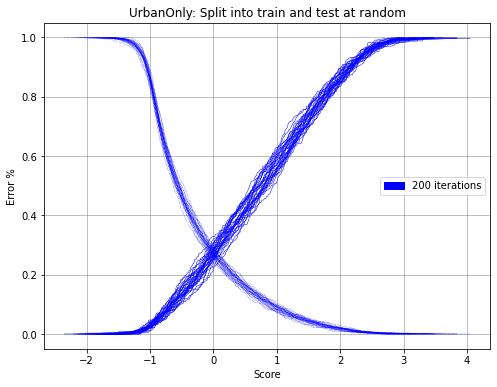

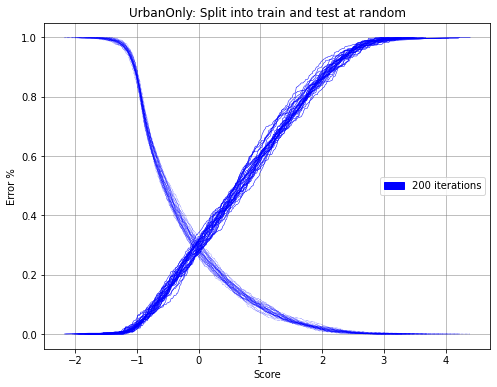

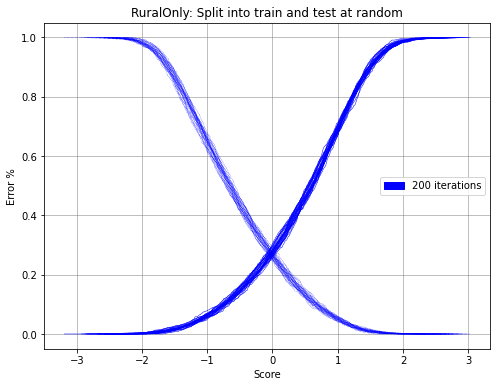

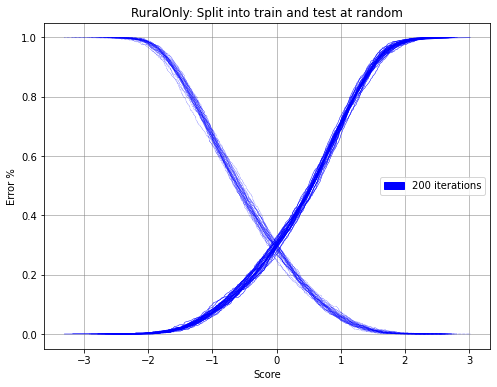

In [16]:
for area in ['Urban','Rural']:
    for feat_country in ['with_country', 'no_country']:
        if feat_country =='with_country':
            enc_data = Enc_data_with_country
        else:
            enc_data = Enc_data
        urban = (True if area=='Urban' else False)
        param = GLOBAL_PARAMS[area]
        selector=df['urban']==urban
        
        D = DataSplitter(enc_data.data)
        subData=D.get_subset(selector)
        subD=DataSplitter(subData)

        train_selector=np.random.rand(subData.shape[0]) > 0.3
        Train=subD.get_subset(train_selector)
        Test=subD.get_subset(~train_selector)

        param['num_round']=100
        log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

        styled_logs=[
            {   'log':log200,
                'style':['b:','b-'],
                'label':'200 iterations',
                'label_color':'b'
            }
        ]


        _mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

        pickle_file=f'data/Checkpoint_{area}_{feat_country}.pk'
        Dump={'styled_logs':styled_logs,
             'tree':tree,
             'mean':_mean,
             'std':_std}
        pkl.dump(Dump,open(pickle_file,'wb'))


In [30]:
parameters = {
    # Parameters that we are going to tune.
    'eta':0.15,
    'max_depth': 3,
    'verbosity': 0,
    'nthread': 16,
    'num_rounds': 100,
    'objective':'binary:logistic',
    'feature_selector': 'shuffle'
}


gridsearch_params = [
    (max_depth, eta/100, min_child_weight, gamma)
    for max_depth in range(2,5)
    for eta in [20, 30, 40, 50, 70]
    for min_child_weight in [1, 5, 10]
    for gamma in [0.5, 1, 1.5, 2, 5]
    #    'subsample': [0.6, 0.8, 1.0],
    #    'colsample_bytree': [0.6, 0.8, 1.0],
]

print(f'Possible combinations: {len(gridsearch_params)}')
for area in ['Rural', 'Urban']:
    print(f'Area: {area}')
    urban = (True if area=='Urban' else False)
    selector= df['urban'] == urban
    subData=D.get_subset(selector)
    dtrain = to_DMatrix(subData)
    max_auc = -float("Inf")
    max_f1 = -float("Inf")
    best_params_f1 = None
    best_params_auc = None
    for max_depth, eta, min_child_weight, gamma in gridsearch_params:
        print("CV with max_depth={}, eta={}, min_child_weight={}, gamma={} ".format(
                                 max_depth, eta, min_child_weight, gamma))
        # Update our parameters
        parameters['max_depth'] = max_depth
        parameters['eta'] = eta
        parameters['min_child_weight'] = min_child_weight
        parameters['gamma'] = gamma
        current_params = parameters.copy()
        # Run CV
        cv_results = xgb.cv(
            parameters,
            dtrain,
            num_boost_round = parameters['num_rounds'],
            nfold=5,
            metrics={'auc','error','logloss'},
            early_stopping_rounds=10,
            feval = calc_f1,
            maximize=True,
        )
        # Update best MAE
        #print(cv_results.columns)
        mean_auc = cv_results['test-auc-mean'].max()
        boost_rounds_auc = cv_results['test-auc-mean'].argmax()
        mean_f1 = cv_results['test-f1-mean'].max()
        boost_rounds_f1 =  cv_results['test-f1-mean'].argmax()
        print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds_auc))
        print("\tF1 {} for {} rounds".format(mean_f1, boost_rounds_f1))
        if mean_auc > max_auc:
            max_auc = mean_auc
            best_params_auc = current_params
            best_params_auc['best_round'] = boost_rounds_auc
        if mean_f1 > max_f1:
            max_f1 = mean_f1
            best_params_f1 = current_params  
            best_params_f1['best_round'] = boost_rounds_f1
    print(f'Best F1 params: {best_params_f1}')   
    print(f'Best AUC params: {best_params_auc}')

Possible combinations: 225
Area: Rural
CV with max_depth=2, eta=0.2, min_child_weight=1, gamma=0.5 
	AUC 0.8255281999999999 for 98 rounds
	F1 0.7282922000000001 for 99 rounds
CV with max_depth=2, eta=0.2, min_child_weight=1, gamma=1 
	AUC 0.8250819999999999 for 79 rounds
	F1 0.728388 for 86 rounds
CV with max_depth=2, eta=0.2, min_child_weight=1, gamma=1.5 
	AUC 0.8250819999999999 for 79 rounds
	F1 0.728388 for 86 rounds
CV with max_depth=2, eta=0.2, min_child_weight=1, gamma=2 
	AUC 0.8259332 for 99 rounds
	F1 0.7286476000000001 for 94 rounds
CV with max_depth=2, eta=0.2, min_child_weight=1, gamma=5 
	AUC 0.8226222 for 60 rounds
	F1 0.7207815999999999 for 61 rounds
CV with max_depth=2, eta=0.2, min_child_weight=5, gamma=0.5 
	AUC 0.8260858000000001 for 99 rounds
	F1 0.7323615999999998 for 99 rounds
CV with max_depth=2, eta=0.2, min_child_weight=5, gamma=1 
	AUC 0.8229188000000001 for 64 rounds
	F1 0.7228338 for 64 rounds
CV with max_depth=2, eta=0.2, min_child_weight=5, gamma=1.5 
	AU

	AUC 0.8055846000000001 for 42 rounds
	F1 0.7259804000000001 for 42 rounds
CV with max_depth=2, eta=0.7, min_child_weight=5, gamma=1 
	AUC 0.8055846000000001 for 42 rounds
	F1 0.7259804000000001 for 42 rounds
CV with max_depth=2, eta=0.7, min_child_weight=5, gamma=1.5 
	AUC 0.8055846000000001 for 42 rounds
	F1 0.7259804000000001 for 42 rounds
CV with max_depth=2, eta=0.7, min_child_weight=5, gamma=2 
	AUC 0.8060877999999999 for 46 rounds
	F1 0.7275602 for 46 rounds
CV with max_depth=2, eta=0.7, min_child_weight=5, gamma=5 
	AUC 0.805626 for 38 rounds
	F1 0.7227593999999999 for 42 rounds
CV with max_depth=2, eta=0.7, min_child_weight=10, gamma=0.5 
	AUC 0.809455 for 52 rounds
	F1 0.7328589999999999 for 61 rounds
CV with max_depth=2, eta=0.7, min_child_weight=10, gamma=1 
	AUC 0.809455 for 52 rounds
	F1 0.7328589999999999 for 61 rounds
CV with max_depth=2, eta=0.7, min_child_weight=10, gamma=1.5 
	AUC 0.809455 for 52 rounds
	F1 0.7328589999999999 for 61 rounds
CV with max_depth=2, eta=0.

	AUC 0.8169225999999998 for 38 rounds
	F1 0.7283609999999999 for 47 rounds
CV with max_depth=3, eta=0.5, min_child_weight=10, gamma=1.5 
	AUC 0.8185636000000001 for 51 rounds
	F1 0.7333860000000001 for 51 rounds
CV with max_depth=3, eta=0.5, min_child_weight=10, gamma=2 
	AUC 0.8184694 for 47 rounds
	F1 0.7325848 for 47 rounds
CV with max_depth=3, eta=0.5, min_child_weight=10, gamma=5 
	AUC 0.8144494 for 44 rounds
	F1 0.7253326 for 44 rounds
CV with max_depth=3, eta=0.7, min_child_weight=1, gamma=0.5 
	AUC 0.8030887999999999 for 26 rounds
	F1 0.7251726000000001 for 26 rounds
CV with max_depth=3, eta=0.7, min_child_weight=1, gamma=1 
	AUC 0.8031026000000001 for 26 rounds
	F1 0.7251726000000001 for 26 rounds
CV with max_depth=3, eta=0.7, min_child_weight=1, gamma=1.5 
	AUC 0.8035154 for 31 rounds
	F1 0.7307330000000001 for 39 rounds
CV with max_depth=3, eta=0.7, min_child_weight=1, gamma=2 
	AUC 0.8036380000000001 for 21 rounds
	F1 0.7287538 for 25 rounds
CV with max_depth=3, eta=0.7, mi

	AUC 0.812561 for 33 rounds
	F1 0.7342736000000001 for 33 rounds
CV with max_depth=4, eta=0.5, min_child_weight=1, gamma=2 
	AUC 0.8126434 for 27 rounds
	F1 0.7295206 for 28 rounds
CV with max_depth=4, eta=0.5, min_child_weight=1, gamma=5 
	AUC 0.8147336 for 33 rounds
	F1 0.733859 for 34 rounds
CV with max_depth=4, eta=0.5, min_child_weight=5, gamma=0.5 
	AUC 0.8157504 for 27 rounds
	F1 0.7408702 for 42 rounds
CV with max_depth=4, eta=0.5, min_child_weight=5, gamma=1 
	AUC 0.8152253999999999 for 16 rounds
	F1 0.734234 for 16 rounds
CV with max_depth=4, eta=0.5, min_child_weight=5, gamma=1.5 
	AUC 0.8134642 for 12 rounds
	F1 0.7336979999999999 for 16 rounds
CV with max_depth=4, eta=0.5, min_child_weight=5, gamma=2 
	AUC 0.8166768 for 34 rounds
	F1 0.7354109999999999 for 35 rounds
CV with max_depth=4, eta=0.5, min_child_weight=5, gamma=5 
	AUC 0.8153137999999999 for 25 rounds
	F1 0.7371502 for 25 rounds
CV with max_depth=4, eta=0.5, min_child_weight=10, gamma=0.5 
	AUC 0.8154308 for 33 r

KeyboardInterrupt: 